In [1]:
import torch 
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
import os
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import copy
from itertools import count

In [2]:
capacity=1000000

batch_size=64
update_iteration=200
tau=0.001
# tau for soft updating

gamma=0.99
directory = './'
hidden1=20
hidden2=64

In [3]:
import numpy as np
import random
import copy

class OU_Noise(object):
    """Ornstein-Uhlenbeck process.
    
    The OU_Noise class has four attributes
    
        size: the size of the noise vector to be generated
        mu: the mean of the noise, set to 0 by default
        theta: the rate of mean reversion, controlling how quickly the noise returns to the mean
        sigma: the volatility of the noise, controlling the magnitude of fluctuations
    """

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.25):
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample.
        This method uses the current state of the noise and generates the next sample
        """
        dx = self.theta * (self.mu - self.state) + self.sigma * np.array([np.random.normal() for _ in range(len(self.state))])
        self.state += dx
        return self.state

In [4]:
class Replay_buffer():
    '''
    Code based on:
    https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py
    Expects tuples of (state, next_state, action, reward, done)
    '''
    def __init__(self, max_size=capacity):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self.storage = []
        self.max_size = max_size
        self.ptr = 0

    def push(self, data):
        if len(self.storage) == self.max_size:
            self.storage[int(self.ptr)] = data
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.storage.append(data)

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        state: np.array
            batch of state or observations
        action: np.array
            batch of actions executed given a state
        reward: np.array
            rewards received as results of executing action
        next_state: np.array
            next state next state or observations seen after executing action
        done: np.array
            done[i] = 1 if executing ation[i] resulted in
            the end of an episode and 0 otherwise.
        """
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        state, next_state, action, reward, done = [], [], [], [], []

        for i in ind:
            st, n_st, act, rew, dn = self.storage[i]
            state.append(np.array(st, copy=False))
            next_state.append(np.array(n_st, copy=False))
            action.append(np.array(act, copy=False))
            reward.append(np.array(rew, copy=False))
            done.append(np.array(dn, copy=False))

        return np.array(state), np.array(next_state), np.array(action), np.array(reward).reshape(-1, 1), np.array(done).reshape(-1, 1)





In [5]:
class Actor(nn.Module):
    """
    The Actor model takes in a state observation as input and 
    outputs an action, which is a continuous value.
    
    It consists of four fully coonected linear layers with ReLU activation functions and 
    a final output layer selects one single optimized action for the state
    """
    def __init__(self, n_states, action_dim, hidden1):
        super(Actor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n_states, hidden1), 
            nn.ReLU(), 
            nn.Linear(hidden1, hidden1), 
            nn.ReLU(), 
            nn.Linear(hidden1, hidden1), 
            nn.ReLU(), 
            nn.Linear(hidden1, 1)
        )
        
    def forward(self, state):
        return self.net(state)

class Critic(nn.Module):
    """
    The Critic model takes in both a state observation and an action as input and 
    outputs a Q-value, which estimates the expected total reward for the current state-action pair. 
    
    It consists of four linear layers with ReLU activation functions, 
    State and action inputs are concatenated before being fed into the first linear layer. 
    
    The output layer has a single output, representing the Q-value
    """
    def __init__(self, n_states, action_dim, hidden2):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n_states + action_dim, hidden2), 
            nn.ReLU(), 
            nn.Linear(hidden2, hidden2), 
            nn.ReLU(), 
            nn.Linear(hidden2, hidden2), 
            nn.ReLU(), 
            nn.Linear(hidden2, action_dim)
        )
        
    def forward(self, state, action):
        return self.net(torch.cat((state, action), 1))


In [6]:
class DDPG(object):
    def __init__(self, state_dim, action_dim):
        """
        Initializes the DDPG agent. 
        Takes three arguments:
               state_dim which is the dimensionality of the state space, 
               action_dim which is the dimensionality of the action space, and 
               max_action which is the maximum value an action can take. 
        
        Creates a replay buffer, an actor-critic  networks and their corresponding target networks. 
        It also initializes the optimizer for both actor and critic networks alog with 
        counters to track the number of training iterations.
        """
        self.replay_buffer = Replay_buffer()
        
        self.actor = Actor(state_dim, action_dim, hidden1).to(device)
        self.actor_target = Actor(state_dim, action_dim,  hidden1).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=3e-3)

        self.critic = Critic(state_dim, action_dim,  hidden2).to(device)
        self.critic_target = Critic(state_dim, action_dim,  hidden2).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=2e-2)
        # learning rate

        

        self.num_critic_update_iteration = 0
        self.num_actor_update_iteration = 0
        self.num_training = 0

    def select_action(self, state):
        """
        takes the current state as input and returns an action to take in that state. 
        It uses the actor network to map the state to an action.
        """
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()


    def update(self):
        """
        updates the actor and critic networks using a batch of samples from the replay buffer. 
        For each sample in the batch, it computes the target Q value using the target critic network and the target actor network. 
        It then computes the current Q value 
        using the critic network and the action taken by the actor network. 
        
        It computes the critic loss as the mean squared error between the target Q value and the current Q value, and 
        updates the critic network using gradient descent. 
        
        It then computes the actor loss as the negative mean Q value using the critic network and the actor network, and 
        updates the actor network using gradient ascent. 
        
        Finally, it updates the target networks using 
        soft updates, where a small fraction of the actor and critic network weights are transferred to their target counterparts. 
        This process is repeated for a fixed number of iterations.
        """

        for it in range(update_iteration):
            # For each Sample in replay buffer batch
            state, next_state, action, reward, done = self.replay_buffer.sample(batch_size)
            state = torch.FloatTensor(state).to(device)
            action = torch.FloatTensor(action).to(device)
            next_state = torch.FloatTensor(next_state).to(device)
            done = torch.FloatTensor(1-done).to(device)
            reward = torch.FloatTensor(reward).to(device)

            # Compute the target Q value
            target_Q = self.critic_target(next_state, self.actor_target(next_state))
            target_Q = reward + (done * gamma * target_Q).detach()

            # Get current Q estimate
            current_Q = self.critic(state, action)

            # Compute critic loss
            critic_loss = F.mse_loss(current_Q, target_Q)
            
            # Optimize the critic
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            # Compute actor loss as the negative mean Q value using the critic network and the actor network
            actor_loss = -self.critic(state, self.actor(state)).mean()
            

            # Optimize the actor
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            
            """
            Update the frozen target models using 
            soft updates, where 
            tau,a small fraction of the actor and critic network weights are transferred to their target counterparts. 
            """
            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
            
           
            self.num_actor_update_iteration += 1
            self.num_critic_update_iteration += 1
    def save(self):
        """
        Saves the state dictionaries of the actor and critic networks to files
        """
        torch.save(self.actor.state_dict(), directory + 'actor.pth')
        torch.save(self.critic.state_dict(), directory + 'critic.pth')
        

    def load(self):
        """
        Loads the state dictionaries of the actor and critic networks to files
        """
        self.actor.load_state_dict(torch.load(directory + 'actor.pth'))
        self.critic.load_state_dict(torch.load(directory + 'critic.pth'))
       


In [7]:
import gym

# create the environment
env_name='MountainCarContinuous-v0'
env = gym.make(env_name)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define different parameters for training the agent
max_episode=100
ep_r = 0
total_step = 0
score_hist=[]
# for rensering the environmnet
render=True
render_interval=10
# for reproducibility
env.seed(0)
torch.manual_seed(0)
np.random.seed(0)
#Environment action ans states
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])
min_Val = torch.tensor(1e-7).float().to(device) 

max_time_steps=5000
# Exploration Noise
exploration_noise=0.1
exploration_noise=0.1 * max_action

In [8]:
# Create a DDPG instance
agent = DDPG(state_dim, action_dim)

# Train the agent for max_episodes
for i in range(max_episode):
    total_reward = 0
    step =0
    state = env.reset()
    for  t in range(max_time_steps):
        action = agent.select_action(state)
        # Add Gaussian noise to actions for exploration
        action = (action + np.random.normal(0, 1, size=action_dim)).clip(-max_action, max_action)
        #action += ou_noise.sample()
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        if render and i >= render_interval : env.render()
        agent.replay_buffer.push((state, next_state, action, reward, np.float(done)))
        state = next_state
        if done:
            break
        step += 1
        
    score_hist.append(total_reward)
    total_step += step+1
    print("Episode: \t{}  Total Reward: \t{:0.2f}".format( i, total_reward))
    agent.update()
    if i % 100 == 0:
        agent.save()
env.close()

Episode: 	0  Total Reward: 	-50.60
Episode: 	1  Total Reward: 	-52.92
Episode: 	2  Total Reward: 	64.42
Episode: 	3  Total Reward: 	-58.05
Episode: 	4  Total Reward: 	-56.96
Episode: 	5  Total Reward: 	-58.29
Episode: 	6  Total Reward: 	-58.44
Episode: 	7  Total Reward: 	-59.93
Episode: 	8  Total Reward: 	-58.49
Episode: 	9  Total Reward: 	-57.50
Episode: 	10  Total Reward: 	-57.34
Episode: 	11  Total Reward: 	56.06
Episode: 	12  Total Reward: 	-55.03
Episode: 	13  Total Reward: 	-58.62
Episode: 	14  Total Reward: 	-58.18
Episode: 	15  Total Reward: 	-57.61
Episode: 	16  Total Reward: 	-56.12
Episode: 	17  Total Reward: 	-57.56
Episode: 	18  Total Reward: 	-58.44
Episode: 	19  Total Reward: 	-59.32
Episode: 	20  Total Reward: 	-56.82
Episode: 	21  Total Reward: 	71.53
Episode: 	22  Total Reward: 	-58.02
Episode: 	23  Total Reward: 	-59.20
Episode: 	24  Total Reward: 	-58.28
Episode: 	25  Total Reward: 	-55.96
Episode: 	26  Total Reward: 	50.71
Episode: 	27  Total Reward: 	-56.52
Episod

In [9]:
import matplotlib.pyplot as plt 
import numpy as np
def plot_learning_curve(x, scores):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    #plt.savefig(figure_file)

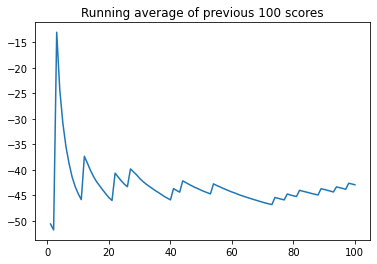

In [10]:
x = [i+1 for i in range(len(score_hist))]
plot_learning_curve(x, score_hist)

In [11]:
test_iteration=100
max_length_of_trajectory=1000    
for i in range(test_iteration):
    state = env.reset()
    for t in count():
        action = agent.select_action(state)
        next_state, reward, done, info = env.step(np.float32(action))
        ep_r += reward
        print(reward)
        env.render()
        if done: 
            print("reward{}".format(reward))
            #print("Episode \t{}, the episode reward is \t{:0.2f}".format(i, ep_r))
            ep_r = 0
            env.render()
            break
        state = next_state
env.close()   

-0.03783425427431589
-0.037798252884044814
-0.03773281841272933
-0.0376385539907492
-0.03751626169951692
-0.037367026338205635
-0.03719214442885601
-0.03699314730176049
-0.03677176504658206
-0.03652991186034029
-0.036269656675926853
-0.03599321540376401
-0.03570292169807523
-0.03540117703481691
-0.03509045160253663
-0.03477324330308562
-0.03445204530231081
-0.034129315086062206
-0.03382678626599365
-0.03355336444350918
-0.03328419507629974
-0.03302108280359484
-0.03276576291253299
-0.03251980857939465
-0.032284709930866386
-0.03206180318406702
-0.03185231585241901
-0.03165733066112786
-0.031477823704007334
-0.03131464180979151
-0.031168526691240928
-0.031040111934999004
-0.03092991974285866
-0.030838397057252467
-0.030765898090138324
-0.030712679822415014
-0.030678949885840724
-0.030664821449194336
-0.030670346996999245
-0.03069551202688814
-0.03074021511938554
-0.030804293787367956
-0.030887523541455054
-0.03098957677485146
-0.031110060622224014
-0.031248474879816968
-0.03140424250672

-0.03699561977941954
-0.03677838694268445
-0.036540597667184115
-0.03628428955551186
-0.036011662473924844
-0.0357249921127508
-0.03542667321958994
-0.035119148844922066
-0.03480488384926872
-0.03448636058650756
-0.03416603347902516
-0.033859845416692735
-0.03358802383254478
-0.03332019464083693
-0.03305818041367594
-0.03280368638431561
-0.03255832410856705
-0.03232356722767236
-0.032100769292982535
-0.031891161223899546
-0.031695848936783476
-0.03151580434476422
-0.03135189646625101
-0.031204875270640642
-0.03107537547821835
-0.03096393989358717
-0.03087102889546465
-0.030796996431636005
-0.03074211866269252
-0.030706602177872713
-0.030690571973254067
-0.03069409205097351
-0.030717145953227387
-0.03075964328247416
-0.030821439026982846
-0.030902292967552116
-0.031001901379577035
-0.03111986876490427
-0.031255718892868246
-0.03140887221366064
-0.031578636013387396
-0.03176424111160294
-0.03196476440336937
-0.032179185005503895
-0.032406366722813475
-0.03264502652612613
-0.0328937639107

-0.03385208370009742
-0.033582317410008854
-0.03331656834974552
-0.0330566382622294
-0.03280422577110045
-0.03256092935363455
-0.03232820320618544
-0.03210739541206955
-0.0318997249255748
-0.03170628597887095
-0.03152805241241232
-0.031365888528657494
-0.03122051966534514
-0.031092595982258688
-0.030982655629339106
-0.030891141028650183
-0.03081840798915927
-0.03076474096890394
-0.03073033482596124
-0.03071531585740104
-0.030719735929298865
-0.030743579407763733
-0.030786763065498237
-0.03084912234044204
-0.03093042360863052
-0.03103034957266715
-0.031148510735707548
-0.03128441663013746
-0.03143747305924229
-0.03160701244159014
-0.031792223557838284
-0.0319922079440861
-0.03220593565538934
-0.032432247586235974
-0.03266988503813906
-0.032917424255004234
-0.03317336067620182
-0.03343605063756492
-0.03373354215804092
-0.03405005932235703
-0.034367949650983574
-0.03468487375499798
-0.03499840022942067
-0.03530610495386668
-0.03560551019481863
-0.035894201400214244
-0.036169775385077686
-

-0.03467450496226689
-0.0344419002653936
-0.03420711514089625
-0.033971924011054
-0.033759047130439514
-0.033560829412090244
-0.03336628705159548
-0.03317673197589244
-0.03299343417677534
-0.032817561641636316
-0.03265022361848082
-0.03249243181487351
-0.03234511650123615
-0.03220914242096029
-0.032085243482910995
-0.0319741199053226
-0.03187633904298117
-0.031792418483588845
-0.031722780678643404
-0.03166777477681535
-0.03162766455240309
-0.03160264961627526
-0.031592839385661264
-0.0315982937931242
-0.031618976571943236
-0.03165479535532576
-0.03170556774794022
-0.03177105414601478
-0.031850929916652504
-0.03194479081049053
-0.032052144654932134
-0.03217242977280108
-0.03230500631126212
-0.03244912695664084
-0.03260398199654766
-0.03276864940330739
-0.032942139930361235
-0.03312338118410061
-0.033311208406141546
-0.03350438972202028
-0.03372199433960397
-0.03395563251595526
-0.034190669755402324
-0.03442538454331192
-0.034658024791225726
-0.03488682230449882
-0.03511000089929439
-0.0

-0.03203528790015895
-0.03193241489853484
-0.03184309927333153
-0.031767795354973316
-0.03170689681718528
-0.03166069110384342
-0.0316294143595087
-0.03161320535583769
-0.03161215975632246
-0.03162626340076855
-0.03165545264708136
-0.03169959399282476
-0.031758470088961134
-0.0318317788341119
-0.03191916583184593
-0.032020169180202986
-0.0321342783949504
-0.032260865093940085
-0.03239924162720662
-0.032548618277593276
-0.03270813479042687
-0.03287684446113417
-0.033053691139527074
-0.03323756837006755
-0.03342727623621755
-0.033628217403446924
-0.0338590754479501
-0.034092010873850144
-0.034325346700279626
-0.034557347918315884
-0.034786263403363195
-0.035010326778462185
-0.035227786001698645
-0.0354369125838744
-0.035636011271379074
-0.035823465814361556
-0.03599772123128311
-0.03615733037179467
-0.036300957974959046
-0.0364273846005986
-0.03653553918757133
-0.03662450992198139
-0.03669351860849588
-0.03674198834369378
-0.03676948800391564
-0.03677579883808448
-0.03676087202350722
-0.

-0.03236247502070775
-0.032507117866140335
-0.03266213149165651
-0.03282659715824963
-0.0329995149223933
-0.03317980131214746
-0.03336628705159548
-0.03355774250201229
-0.03378151998767862
-0.034012235323884
-0.03424391720534601
-0.03447485259957297
-0.034703326597324134
-0.03492758107559304
-0.03514586483902917
-0.035356456749902065
-0.03555767536916541
-0.03574786761869895
-0.03592548320371094
-0.036089035657802526
-0.03623717046265398
-0.03636864045000863
-0.036482316686716844
-0.03657724967275868
-0.03665262234469289
-0.03670778893593365
-0.03674227737991629
-0.036755791092241454
-0.036748217326021404
-0.03671962761311285
-0.036670263055231446
-0.036600540626045584
-0.03651107319625204
-0.036402624001857474
-0.036276111149604516
-0.03613261874637743
-0.03597335021354162
-0.035799631749259576
-0.0356129439398817
-0.035414796559269136
-0.03520681047812104
-0.03499067127455078
-0.034768090772420025
-0.03454081154220745
-0.03431059064134878
-0.03407915616159052
-0.033853179581115354
-0

-0.03283114612022473
-0.03282681571978543
-0.032830497224995626
-0.03284217832025469
-0.03286178126955406
-0.03288918326644854
-0.03292422304817855
-0.03296666638748889
-0.03301625356133542
-0.03307266468437007
-0.033135546574136754
-0.033204491628589496
-0.03327903716859879
-0.03335870604823867
-0.03344295792829577
-0.03353123683132395
-0.03362292230918662
-0.033727207228686495
-0.03384019661176616
-0.03395479894112476
-0.03407020035867845
-0.03418555360013329
-0.034300019628105714
-0.03441273985756119
-0.03452287825300715
-0.034629593777380306
-0.034732068874575715
-0.0348295242165225
-0.03492119135633089
-0.035006369844781206
-0.035084371807798574
-0.03515458630150903
-0.03521645207628445
-0.03526948676257611
-0.03531325235485703
-0.03534740552059965
-0.03537166287125082
-0.03538583692689059
-0.035389808156948276
-0.035383546479451765
-0.03536710423628051
-0.035340609000583355
-0.03530428457188215
-0.035258422191510874
-0.03520339414638194
-0.035139624780800106
-0.03506763920478342


-0.03423258226493751
-0.034345527061038085
-0.03445638363612034
-0.03456432801711031
-0.03466853150048941
-0.03476820323831795
-0.03486255583763729
-0.034950869397347616
-0.03503244317142986
-0.03510664577391687
-0.03517288085686374
-0.0352306162301236
-0.03527940600117887
-0.03531884185724863
-0.03534861039421209
-0.03536847959442326
-0.03537827802261404
-0.03537794476868363
-0.03536746579691261
-0.035346930664287866
-0.035316511073080294
-0.035276453448193835
-0.03522707138699843
-0.03516877335733035
-0.03510201949556091
-0.03502733496961952
-0.03494533023072677
-0.03485663657961737
-0.03476196165608236
-0.03466203217250872
-0.034557628229983095
-0.034449547385628776
-0.03433860401913904
-0.03422564271989046
-0.034111502878376145
-0.0339970323716333
-0.03388305263585245
-0.033775402251663776
-0.03368046485139189
-0.03358792020069501
-0.03349839372649264
-0.03341251468128235
-0.03333086822891005
-0.033253989177248755
-0.03318239010208259
-0.033116554997833704
-0.03305689871194915
-0.0

-0.033551320526612825
-0.033556319946947966
-0.033564448252542435
-0.0335756513197353
-0.03358984087028603
-0.033606915134499
-0.033626765704270055
-0.033649263647683725
-0.033674231755123074
-0.03370150667490499
-0.033734615347071895
-0.0337713771805511
-0.03381008598968407
-0.03385046071902629
-0.03389221976931935
-0.03393505315683711
-0.03397866406613161
-0.03402273408719338
-0.034066937036996946
-0.03411095981139169
-0.03415447456509355
-0.03419716656958514
-0.034238713362816496
-0.034278819672385906
-0.03431716867231991
-0.03435349186736723
-0.03438750638779311
-0.034418970991515606
-0.03444763027850719
-0.03447328475001008
-0.03449572099185048
-0.034514788781701
-0.034530331210829955
-0.03454224080151249
-0.034550417573897006
-0.03455479713438905
-0.03455535773816933
-0.03455208527780975
-0.034545015330458284
-0.034534184088988694
-0.03451969838238824
-0.03450165153934428
-0.03448017935479584
-0.03445545297053378
-0.03442765775578351
-0.034397007181599194
-0.0343637286979984
-0.0

-0.03417957362053272
-0.03422122130634762
-0.03426154763714386
-0.03430025700418504
-0.03433706721246068
-0.03437168163657134
-0.034403866186045205
-0.034433358603294904
-0.03445995247028719
-0.034483441408043804
-0.03450364017233518
-0.034520405785872656
-0.0345336026408777
-0.03454314461309913
-0.03454893909694334
-0.0345509571207586
-0.03454917733279785
-0.0345436140392863
-0.03453431018681528
-0.0345213443323761
-0.03450480256886159
-0.03448481347653711
-0.03446154101081369
-0.03443514939636181
-0.03440583801416466
-0.03437384124886513
-0.03433937942101615
-0.03430272855686702
-0.034264157354417436
-0.034223948043404916
-0.03418241021231019
-0.03413983886763141
-0.03409655618967555
-0.034052876622014595
-0.03400912077064646
-0.03396560842191754
-0.03392264465888708
-0.03388055461614137
-0.033839627970246866
-0.03380016760343416
-0.03376244805986097
-0.03373075886991082
-0.03370187346011022
-0.033675103385391834
-0.03365063284957479
-0.03362863218039571
-0.03360926482646711
-0.03359

-0.03446687373617898
-0.03444187228115112
-0.03441390771513397
-0.03438318637257822
-0.034349935537102284
-0.03431441029170088
-0.034276879404571046
-0.034237618234528
-0.03419691560822145
-0.03415508068016528
-0.034112421924659485
-0.034069247090770104
-0.03402587707842599
-0.033982631978171085
-0.03393981023357675
-0.03389773036136745
-0.03385669623049239
-0.0338170040762634
-0.033778928715891256
-0.0337445310363421
-0.03371516211903014
-0.033687812482413905
-0.03366267334431541
-0.03363992200855961
-0.033619715039705865
-0.0336021952662179
-0.03358748494867179
-0.03357567894983191
-0.03356686552564412
-0.03356110565257495
-0.03355843307359443
-0.03355886813733946
-0.0335624109042417
-0.033569034239013716
-0.03357869069851773
-0.033591319408743915
-0.033606832205694916
-0.03362511357047424
-0.03364604129255646
-0.03366947949327823
-0.03369524395253052
-0.03372541417091703
-0.03376053631470519
-0.033797686501637614
-0.03383658373898015
-0.03387696734336174
-0.033918534453707495
-0.033

-0.03284795132440763
-0.03305268366492307
-0.033264610904240044
-0.03348236104218962
-0.03372850878310061
-0.03399135385993901
-0.03425556101423446
-0.03451916608355532
-0.03478020298871343
-0.0350366697138643
-0.03528652945533395
-0.03552781891230552
-0.03575855961745198
-0.03597686805499656
-0.036180931836624096
-0.036369028661647464
-0.03653956720775255
-0.03669110679284273
-0.03682234078365241
-0.03693213737703651
-0.037019558504397664
-0.03708384916269871
-0.037124440476162944
-0.03714099561366311
-0.03713336773336238
-0.03710162963675998
-0.037046037177589496
-0.0369671006747069
-0.036865488495942955
-0.03674208228034139
-0.03659795157497037
-0.03643432799927417
-0.03625261503095913
-0.036054361345822274
-0.035841227027137636
-0.03561499280218392
-0.035377526430865204
-0.035130770926485866
-0.03487669793049122
-0.03461732545617657
-0.034354651731976917
-0.03409068144364404
-0.03383834507705075
-0.03361461413745168
-0.03339434631985263
-0.03317903224812291
-0.03297010930755597
-0.

-0.03620765408470561
-0.036390649568716425
-0.03655589052797872
-0.036701967809450765
-0.03682763610706843
-0.03693180412779249
-0.03701358941552826
-0.0370722785344757
-0.037107358920895096
-0.037118528302650944
-0.03710570326482845
-0.037068983340830995
-0.0370086868544206
-0.0369253495314311
-0.03681969326471659
-0.03669261597359572
-0.03654523131117458
-0.036378784956596986
-0.03619470769508304
-0.03599455281837436
-0.03578001971779408
-0.035552870198657514
-0.03531499504198656
-0.03506830278475981
-0.034814793813751875
-0.034556436913248945
-0.03429523737324871
-0.03403316492631916
-0.03379082582832815
-0.033569338140750915
-0.03335160781511526
-0.03313910810076983
-0.03293325271180869
-0.032735349896316636
-0.03254661879771135
-0.03236820571046337
-0.03220113257101644
-0.032046334039756985
-0.031904653614677515
-0.031776826311853766
-0.03166350837887535
-0.03156525292807864
-0.0314825257188037
-0.03141572721156116
-0.03136515413479266
-0.03133104100555926
-0.03131353445172778
-0.

-0.03367298658859319
-0.03388226158631404
-0.03409331248769867
-0.03430459973506892
-0.034514578678193075
-0.03472164385846419
-0.034924220588072784
-0.03512073131315709
-0.03530961835295443
-0.035489367274439944
-0.035658530821658374
-0.03581571762475164
-0.03595963084558775
-0.03608907146479545
-0.03620295581975519
-0.03630034029181992
-0.036380381173600894
-0.03644241627399403
-0.03648590973077468
-0.03651049694660493
-0.0365159642982249
-0.036502271478682145
-0.03646953005352458
-0.036418031845370534
-0.03634820475221012
-0.036260647219785724
-0.03615609745711623
-0.036035452506846255
-0.03589970812385133
-0.03575001301823164
-0.03558760125771556
-0.035413817568582216
-0.03523007140231584
-0.035037855167204056
-0.03483869184197488
-0.034634146726208216
-0.03442580420765786
-0.03421525912681354
-0.0340040738286973
-0.03380463104373952
-0.033626261073324316
-0.033450996651723484
-0.03328004120996866
-0.0331145381487886
-0.03295557223607979
-0.03280416432174924
-0.03266124581995342
-0

-0.03648374236238396
-0.0364975397335968
-0.03649231140395983
-0.03646812625230531
-0.036425175803174524
-0.036363823922380335
-0.03628459832813782
-0.03618817441293345
-0.03607537300604378
-0.035947121978223605
-0.035804517763951084
-0.03564874348072067
-0.03548108013342812
-0.03530290337951101
-0.03511564493499044
-0.0349208250395364
-0.034719972067521
-0.03451464871262466
-0.0343064290705545
-0.03409689727459977
-0.03388759094059459
-0.03370686332125707
-0.033531374890516476
-0.03335963555272805
-0.03319281495196833
-0.03303201669076863
-0.032878273046401674
-0.03273256717620576
-0.0325957870784638
-0.03246875491420411
-0.03235222208219035
-0.03224685756768828
-0.03215324986016732
-0.032071908737185593
-0.03200328037378917
-0.03194772850476966
-0.03190554243519763
-0.031876938056143445
-0.0318620586207178
-0.03186099545618539
-0.03187373441074328
-0.03190022989670638
-0.03194032388745747
-0.031993826206474195
-0.032060446447486866
-0.03213983340643267
-0.03223156717851907
-0.0323351

-0.03498880968305116
-0.03479155087843679
-0.0345892687048547
-0.034383514907890246
-0.03417584511014162
-0.033967810821424395
-0.03377614355597416
-0.0336008408703492
-0.03342879943932111
-0.033261200766906994
-0.033099173696450636
-0.03294376151527025
-0.032795964763499795
-0.03265670864403205
-0.032526824541094256
-0.03240709284796708
-0.03229821078481478
-0.03220078757451894
-0.03211536657337923
-0.032042420101143776
-0.03198233742979859
-0.031935426127246556
-0.03190194009529392
-0.0318820467228992
-0.03187584772177985
-0.031883386217090505
-0.03190460648060167
-0.03193940763415846
-0.031987609605196
-0.03204895921181219
-0.03212313602999508
-0.032209731021854184
-0.0323082722123619
-0.03241822326072565
-0.03253895469378598
-0.0326697555777006
-0.03280984521615018
-0.032958384950349286
-0.033114435249973796
-0.033277008501091034
-0.033445026118181787
-0.0336205237548711
-0.033825670012676314
-0.03403297020267928
-0.0342409315744149
-0.03444802908836806
-0.03465271238545178
-0.0348

-0.034958410698669694
-0.03495241283112627
-0.03493957306352833
-0.03491999378932178
-0.03489382151365703
-0.03486126777557388
-0.03482258773616174
-0.03477807985928081
-0.03472809257197618
-0.034673009793707264
-0.034613264552559996
-0.03454931046495666
-0.03448164235959474
-0.03441077482457331
-0.034337234862427124
-0.03426158252575675
-0.03418437568399533
-0.034106197716852193
-0.03402760856702436
-0.03394920036200553
-0.033871527818190826
-0.03379515005036673
-0.033729166493020914
-0.03366708619580692
-0.03360741962026168
-0.03355056097876776
-0.03349691723455841
-0.033446853072440774
-0.03340069813929212
-0.03335878867033557
-0.033321378216885834
-0.03328873436569211
-0.033261070140122584
-0.03323856491292112
-0.033221371489276307
-0.0332096025377723
-0.03320333073763813
-0.03320260261520822
-0.033207424857679156
-0.03321775745047582
-0.03323354111458343
-0.03325466286748089
-0.03328099024929685
-0.03331234365987257
-0.033348523658236574
-0.03338927632051458
-0.033434334265804465


-0.033864722088697265
-0.03378912809242962
-0.03372463880934653
-0.03366330274588769
-0.03360438585200463
-0.03354831691036111
-0.03349546837223762
-0.033446205015030726
-0.033400870377080595
-0.03335975260235955
-0.03332314673887282
-0.033291293010648815
-0.03326439089010478
-0.03324263371185374
-0.03322615386559313
-0.033215071096543626
-0.03320945140309419
-0.03320933461744211
-0.033214706969971884
-0.03322555604973019
-0.033241795188999744
-0.033263325206934626
-0.03328999304164917
-0.03332163282610878
-0.03335803130494384
-0.03339894133921604
-0.03344409542481941
-0.03349317785383086
-0.03354586578294096
-0.033601787562549036
-0.033660563854482815
-0.03372806569792743
-0.033802108193444626
-0.03387793873310017
-0.033955007333873154
-0.03403276157082615
-0.034110639543145284
-0.03418807677873161
-0.034264499276611106
-0.034339337507177346
-0.034412040551135094
-0.03448205536656701
-0.034548855013896686
-0.03461193201088122
-0.03467080570729628
-0.03472502268487574
-0.03477415716147

-0.037022648404070324
-0.03699452491841591
-0.03694342527187509
-0.03686978076987089
-0.03677423011510008
-0.03665760952931265
-0.036520913360721254
-0.0363653119797025
-0.03619214020980941
-0.036002849635247004
-0.035799054008981555
-0.03558242429494527
-0.03535476265722117
-0.035117919630807036
-0.03487379043680825
-0.03462431160934933
-0.03437140906896765
-0.03411700341580968
-0.0338680034610789
-0.03365201591006759
-0.033439173306396695
-0.03323093658610823
-0.03302869385818354
-0.03283375542682876
-0.032647349159789486
-0.03247061614274571
-0.032304593003595984
-0.0321502283792384
-0.03200837892093524
-0.03187979858986445
-0.031765161567649615
-0.031665051225458284
-0.03157994902137808
-0.03151027006970821
-0.031456338026785956
-0.0314184132918772
-0.03139666067907889
-0.03139117694960447
-0.03140199124297318
-0.03142905183226254
-0.03147223926359324
-0.03153134574138825
-0.03160610768348171
-0.031696157660634584
-0.03180106975568755
-0.03192031752263667
-0.032053291993135245
-0.0

-0.034698874435088456
-0.03444870077335196
-0.03419642763042816
-0.033943935618205856
-0.033722112023225746
-0.033509668574143704
-0.03330133595454754
-0.033098529016127996
-0.03290256374464349
-0.032714693748152966
-0.03253607153783413
-0.03236777165229796
-0.032210766160609694
-0.03206592756953484
-0.03193405185760554
-0.03181582736011137
-0.031711857579211154
-0.03162266345491993
-0.031548672019184563
-0.03149024500798738
-0.03144765355608712
-0.031421092804799856
-0.031410682769070775
-0.031416468878978775
-0.03143842218888473
-0.03147645262784273
-0.031530375128591005
-0.031599942269346926
-0.031684829822280845
-0.03178460847814222
-0.031898802521959625
-0.03202682070750349
-0.03216800105116455
-0.032321581449688
-0.032486710521994054
-0.032662431260183665
-0.032847719028053744
-0.03304143114868374
-0.03324235191200984
-0.03344916958429991
-0.0336758435882075
-0.03392641488022861
-0.03417871639359795
-0.034430910328751806
-0.03468111076409208
-0.034927411990597436
-0.0351678967447

-0.03185715340819684
-0.03175070455775
-0.03165882640502247
-0.0315819721789584
-0.031520509195287615
-0.03147473380868746
-0.0314448459005817
-0.03143099663450499
-0.03143324225420798
-0.031451571113444744
-0.031485896938420764
-0.031536065140643645
-0.03160184544171365
-0.03168291744270881
-0.03177889608690663
-0.03188929648218277
-0.032013565558146696
-0.032151053019902065
-0.0323010291816118
-0.032462648557245545
-0.03263500132541743
-0.03281706994852449
-0.0330077398852243
-0.03320583114336593
-0.03341004095814561
-0.03362716664662493
-0.033875329889328044
-0.03412558235414167
-0.03437610576957049
-0.034625027098559615
-0.034870474774743344
-0.03511053773423214
-0.03534331619093791
-0.03556695965074006
-0.03577963466260634
-0.03597959950579686
-0.036165194281494804
-0.03633485241158816
-0.03648714105511317
-0.036620780208274084
-0.03673461107897289
-0.036827672278619515
-0.0368991529953977
-0.036948432200966864
-0.03697510289253501
-0.03697891584802306
-0.03695985303648399
-0.0369

-0.03429132804033088
-0.034039785861529025
-0.033804436974989825
-0.03359172013972511
-0.033382546766519285
-0.033178345591347025
-0.03298045968446992
-0.03279018267716118
-0.032608685691320714
-0.0324370746649695
-0.032276352061217393
-0.03212742652394809
-0.03199112912523141
-0.03186817552580266
-0.03175920907306704
-0.03166477619353181
-0.031585342019047856
-0.03152128556283884
-0.031472914720467315
-0.03144045417657004
-0.03142404641526042
-0.03142377243197849
-0.03143963201574849
-0.031471550438800476
-0.03151937812519101
-0.0315829033891589
-0.03166181129104793
-0.03175572920481642
-0.031864191732167056
-0.03198665222136619
-0.03212248741332111
-0.0322709613352604
-0.0324312564162085
-0.03260246408931522
-0.03278359567935354
-0.032973531871477134
-0.03317110866105146
-0.03337504655836234
-0.03358628974730351
-0.033834704566624296
-0.03408550317731205
-0.03433687162135044
-0.034586948098382565
-0.034833844037084206
-0.03507564493966164
-0.03531044006022057
-0.0355363744439785
-0.0

-0.031793540998677726
-0.0316972583405132
-0.03161579932159988
-0.03154956925897956
-0.031498881833330473
-0.03146396717682052
-0.03144499296514027
-0.03144204505486279
-0.031455141250206965
-0.031484204617123625
-0.03152911670113667
-0.03158966344882721
-0.03166556104389571
-0.031756434568109525
-0.03186184329482309
-0.03198125877738143
-0.03211405599246042
-0.03225953123519254
-0.03241687257827586
-0.03258521824429863
-0.032763558892889934
-0.03295083674502486
-0.03314587484234188
-0.033347429092204096
-0.03355417236026028
-0.033797312265136624
-0.034046031829701916
-0.034295586431666435
-0.03454415353302274
-0.03478984224879902
-0.03503077097043992
-0.035265047983342866
-0.035490801822115614
-0.03570620546927472
-0.03590950127885186
-0.0360989906857867
-0.03627310999920077
-0.036430370540699995
-0.036569449221497054
-0.03668916440013881
-0.0367884727442064
-0.03686653801707962
-0.036922683824583656
-0.03695642515113242
-0.03696747032329917
-0.03695572944750758
-0.03692130030271166
-

-0.032117960791783064
-0.03226150833517103
-0.032416913301958415
-0.032583299296631195
-0.03275969009651227
-0.03294502049478787
-0.03313815422419708
-0.03333784036038345
-0.03354276575284985
-0.03378174170538841
-0.034028512574559855
-0.03427624429286347
-0.034523116398992214
-0.034767261342040355
-0.03500680008876635
-0.03523986479412997
-0.03546460104360882
-0.03567918473854661
-0.035881861016804704
-0.03607096255554012
-0.03624490668917133
-0.03640222122614887
-0.03654157769802602
-0.036661788632659766
-0.036761833320275626
-0.03684083990324929
-0.03689813197502758
-0.03693322406979895
-0.03694580913646774
-0.036935774238259354
-0.03690321549295419
-0.036848415971326175
-0.03677183733480547
-0.03667415411048438
-0.036556207661684326
-0.03641900303715353
-0.03626371246292024
-0.03609165677662531
-0.03590428666829872
-0.03570315675693934
-0.035489963815496496
-0.03526642843499452
-0.035034376483076814
-0.03479565738627031
-0.03455212732128565
-0.03430568895184969
-0.03405818459205569

-0.0340250843634081
-0.034025466812483175
-0.03402593966158385
-0.03402650291259448
-0.03402714961394828
-0.03402787281413886
-0.0340286794695718
-0.0340295487210426
-0.03403048057094935
-0.03403146111335822
-0.03403250425908801
-0.03403357523866966
-0.03403468796257734
-0.03403582156876297
-0.03403696910345424
-0.03403812361242196
-0.034039285096019965
-0.034040439644265064
-0.03404157334623257
-0.03404267924548208
-0.034043750385150416
-0.034044779807983615
-0.034045767512088786
-0.034046692628223595
-0.03404756210973261
-0.034048355086548555
-0.034049071555998366
-0.034049718471783307
-0.034050274963396986
-0.03405074798484407
-0.034051123621863154
-0.034051401872842745
-0.03405158969289666
-0.03405166621232638
-0.03405165925601104
-0.034051547955062135
-0.034051332309991265
-0.034051026234288885
-0.034050629729174275
-0.03405013584006724
-0.03404955848128601
-0.03404889765495369
-0.03404815336350033
-0.034047346477283115
-0.0340464630869576
-0.03404551710687542
-0.03404452245081622

-0.03404254709305441
-0.03404361127515045
-0.03404463374028275
-0.034045614486571195
-0.03404653960062696
-0.03404740212430148
-0.034048195099254386
-0.034048911567020924
-0.03404955848128601
-0.03405011497159229
-0.03405058799192808
-0.03405096362806468
-0.03405124883466328
-0.03405143665429513
-0.03405153404245631
-0.03405153404245631
-0.034051422741712044
-0.034051227965847274
-0.034050935803094616
-0.03405053929850652
-0.03405005932235703
-0.03404949587641113
-0.03404884896274076
-0.03404811858372483
-0.03404731865379098
-0.03404644917539059
-0.03404551710687542
-0.034044536361989584
-0.034043506942837
-0.034042435806998485
-0.03404133686696333
-0.034040217079224534
-0.034039076444811654
-0.0340379288745968
-0.03403678132372647
-0.03403564770155789
-0.034034534961961425
-0.034033436149460174
-0.03403237908075631
-0.03403136375390581
-0.03403039712118385
-0.0340294861345658
-0.034028637745780445
-0.03402786586025428
-0.034027156567759675
-0.034026530727579996
-0.034025988337413084
-

-0.031103391968204976
-0.031007629803121974
-0.030930145155986112
-0.030871227599920205
-0.030831115520527776
-0.030809957607517903
-0.030807840230637852
-0.03082476142742543
-0.030860657410827132
-0.030915395587672735
-0.030988767166617495
-0.031080485967553174
-0.031190160198670824
-0.03131735024997084
-0.03146149311796762
-0.031621952875298474
-0.03179795059107313
-0.031988634426298644
-0.0321930222600205
-0.03241001778961028
-0.0326383928310495
-0.03287681712009203
-0.03312382714034499
-0.03337785645499345
-0.033654872019928915
-0.033962148645119684
-0.034271359014903524
-0.03458025312932165
-0.0348864772912183
-0.03518766559831512
-0.0354814493770391
-0.03576543185252525
-0.03603730595498291
-0.03629480292539853
-0.03653574094358625
-0.036758089393187275
-0.03695992550934903
-0.03713950629930061
-0.037295290212205144
-0.03742592925171415
-0.03753026023162001
-0.03760738290339419
-0.03765662787253774
-0.03767755978984191
-0.03767000138721102
-0.03763401974375178
-0.0375699332658996

-0.0335771088228487
-0.0338812970734935
-0.034187972225283046
-0.03449492282249054
-0.034799841491934914
-0.03510038801056261
-0.0353941909516152
-0.03567889279389114
-0.03595217529866126
-0.036211764419906346
-0.036455493257159334
-0.03668127982468015
-0.03688720576925597
-0.03707148738431556
-0.0372325403625954
-0.037368957443051444
-0.03747955808066763
-0.03756337930549911
-0.03761968015744657
-0.037647974396302075
-0.03764801096849624
-0.03761980445624467
-0.037563583879788004
-0.037479857301656594
-0.03736935824464958
-0.0372330422681344
-0.03707211159383093
-0.036887965989649274
-0.036682189540144704
-0.03645655851926222
-0.03621301263069974
-0.03595361916973481
-0.03568054478914782
-0.03539605620383135
-0.03510249270393082
-0.03480219735959054
-0.034497541412656575
-0.034190864929668406
-0.0338912967542516
-0.033630636971708226
-0.033373579674025676
-0.033121892398071395
-0.03287722040161647
-0.03264113068100052
-0.03241506040029805
-0.03220034111120675
-0.03199817548943997
-0.0

-0.036407054681717455
-0.036633607757175925
-0.03684067348451805
-0.037026492825456
-0.037189447299690315
-0.037328123387286284
-0.03744131871555432
-0.037528040154564124
-0.03758753753413693
-0.03761929263898232
-0.03762302167304519
-0.037598698539318326
-0.037546533063707345
-0.03746699187769451
-0.037360759700166925
-0.03722877981568331
-0.03707219869325087
-0.03689237542241166
-0.0366908612831196
-0.03646940766977913
-0.03622990145872542
-0.035974386957883554
-0.03570500163974124
-0.035423984123917764
-0.03513363965096374
-0.03483629252337472
-0.034534303181374425
-0.034229987699427866
-0.03392638710619309
-0.033667266036013645
-0.033411487971705255
-0.03316080392071541
-0.03291687025953394
-0.032681251301598026
-0.03245540861564713
-0.032240657043661615
-0.03203822975252848
-0.03184922108590662
-0.03167461100410698
-0.0315152689643984
-0.031371957621581716
-0.031245336290340122
-0.031135964117240535
-0.03104429627459382
-0.030970712996856165
-0.030915521524151758
-0.03087892457791

-0.03484562992599791
-0.03498456487552772
-0.035116662181156146
-0.035240876761179506
-0.035356215746793394
-0.03546175433315426
-0.03555663043020019
-0.03564007479821072
-0.03571140567615316
-0.03577003034531714
-0.03581547506144176
-0.03584735777236716
-0.03586541761180797
-0.035869494196734665
-0.03585957800413695
-0.03583572479076338
-0.03579814817867124
-0.03574716913041733
-0.03568318663690349
-0.03560674791288108
-0.03551847579997549
-0.03541909576550815
-0.03530941292763181
-0.035190310351143596
-0.035062754319895716
-0.034927757206232
-0.03478638292961058
-0.03463973835323486
-0.03448895784914754
-0.034335188163754894
-0.034179594528641034
-0.03402333207876751
-0.03386753864813876
-0.033730419621248585
-0.033600301883667784
-0.03347324951016759
-0.033350134561672816
-0.033231788716117094
-0.033118997250996075
-0.033012500011297165
-0.032912971904721644
-0.03282104457329673
-0.03273729377832666
-0.032662233685318044
-0.03259631794726978
-0.03253992710773588
-0.03249341712399314

-0.035641661842698014
-0.03556100221588032
-0.035468874873319935
-0.03536603374406901
-0.035253318774167396
-0.035131632944684556
-0.03500196175955104
-0.03486531504519554
-0.03472277479868922
-0.034575458387463696
-0.03442449626221702
-0.03427101705848514
-0.03411619571418214
-0.03396116215470535
-0.03381070290453501
-0.033680167365321624
-0.03355214222896308
-0.03342751746516548
-0.03330712853272786
-0.03319179162348327
-0.033082263203540664
-0.03297926164105434
-0.03288344081975971
-0.03279540496425994
-0.032715696058446396
-0.032644808570609384
-0.032583156398533576
-0.03253112151141444
-0.03248900033766091
-0.032457038550831284
-0.03243543165270104
-0.032424298285932095
-0.032423694151795246
-0.032433639323139474
-0.032454057158760465
-0.0324848488322349
-0.03252582512823778
-0.032576746720437554
-0.03263730998178858
-0.032707159866362544
-0.032785875456569614
-0.032872968981820704
-0.032967918959869634
-0.03307011445489394
-0.033178901782788726
-0.03329358349397502
-0.03341339669

-0.034696297367590036
-0.034823572589874986
-0.03494521043171837
-0.035060248477761034
-0.03516778363426774
-0.03526695938513171
-0.035356981288919086
-0.035437118379750034
-0.03550674003443568
-0.03556526052239519
-0.035612211201352294
-0.035647213217950835
-0.03566996413673031
-0.03568029556327588
-0.035678109533643365
-0.03566343567445642
-0.03563638132027656
-0.03559718105407548
-0.035546160563032815
-0.03548372878879071
-0.035410391207739166
-0.03532675576212831
-0.03523349610423452
-0.03513135738033988
-0.035021168934895285
-0.03490379343043628
-0.03478015377637043
-0.0346512247041094
-0.034518003445113264
-0.03438150177999866
-0.03424275223573581
-0.03410280040230305
-0.03396266968457127
-0.03382338209760292
-0.03370534763782871
-0.03358966814595341
-0.03347708434149723
-0.03336835286940563
-0.033264219004567865
-0.03316537597968363
-0.033072465872624336
-0.03298609420330791
-0.03290681707767362
-0.0328351215972944
-0.03277146777819304
-0.032716241539887746
-0.03266978283250843


-0.03559240877462031
-0.03554365882707522
-0.03548351575655353
-0.035412469704994363
-0.035331106307669204
-0.035240070017042414
-0.035140105309196555
-0.03503200571415164
-0.034916640710940784
-0.034794904977147566
-0.03466775941020082
-0.034536180664943926
-0.034401188226283706
-0.03426379450007779
-0.034125032211287376
-0.03398592600757446
-0.033847492290206914
-0.03372652876878988
-0.033611310507533076
-0.03349901469076464
-0.03339043356907077
-0.0332862927397489
-0.03318728641857014
-0.03309407814989562
-0.03300726731589663
-0.03292740381116488
-0.032854995759820226
-0.03279049668528877
-0.032734313182843165
-0.03268677841853709
-0.032648180151431914
-0.03261875450819538
-0.03259867968524901
-0.03258806274585737
-0.03258698753689373
-0.032595439974274144
-0.03261337610972568
-0.03264069479670617
-0.03267722382024694
-0.03272275357575296
-0.032777002518345456
-0.03283963699287575
-0.03291027738738563
-0.032988476866377424
-0.033073741020402635
-0.03316553387924195
-0.03326324957845

-0.033517742917002026
-0.033409441490279336
-0.033305442991863644
-0.03320645625950789
-0.03311312501904382
-0.03302607681698646
-0.03294584842377759
-0.03287295531210397
-0.03280786504086599
-0.03275097078999387
-0.032702619502348186
-0.03266311255740675
-0.03263267913103505
-0.032611510794083996
-0.032599734667897805
-0.03259740692245181
-0.032604560580354304
-0.03262113067608539
-0.03264703583781738
-0.032682109984540374
-0.03272614963791511
-0.0327788862109756
-0.032839999057705425
-0.03290910113521619
-0.03298577241345448
-0.0330695248997074
-0.03315982913809421
-0.03325609276323895
-0.033357687050789765
-0.03346393233711673
-0.033574117867198085
-0.03369473880802367
-0.03383012126915332
-0.03396727584715542
-0.03410520913655688
-0.034242933606947544
-0.03437941881387339
-0.03451364722700987
-0.03464461473265068
-0.034771310180667925
-0.03489276524999383
-0.03500801324997873
-0.035116174748863214
-0.035216374259130136
-0.035307812047316034
-0.0353897585151973
-0.03546155556462196


-0.03515982393950914
-0.03513705966273761
-0.03510603833677841
-0.03506701092740059
-0.035020280054745
-0.034966220679257275
-0.034905265394744235
-0.03483788267837475
-0.03476460441980613
-0.03468601111704892
-0.03460268908577433
-0.03451530003624157
-0.034424503256511585
-0.03433097620792438
-0.03423544198061599
-0.034138592087424514
-0.034041162985671745
-0.033943845329326906
-0.033847367452594666
-0.03375832679262771
-0.03367860385548092
-0.0336012554784304
-0.033526791477244446
-0.03345574036536938
-0.033388587491609556
-0.03332578240541615
-0.03326773930894866
-0.033214851246299304
-0.03316747676109486
-0.03312590602214449
-0.03309041618238986
-0.03306125111567191
-0.03303857378059547
-0.03302254877111501
-0.03301326714286148
-0.03301079454537934
-0.0330151370633903
-0.033026282340030376
-0.03304414473491626
-0.03306861315610412
-0.0330995371891877
-0.03313671314174371
-0.0331799043124704
-0.03322882005238945
-0.0332831428306779
-0.03334252097610069
-0.03340654758312809
-0.033474

-0.03362109055249363
-0.03354653551872531
-0.033475256561758114
-0.03340773269185462
-0.03334442773285815
-0.033285763159460656
-0.03323213919211412
-0.033183893981334124
-0.03314135902940372
-0.03310479776978923
-0.0330744608727457
-0.03305053854906106
-0.033033181434533175
-0.03302250081839162
-0.03301856881355434
-0.03302139791536298
-0.03303098899273529
-0.033047269608605136
-0.0330701350208674
-0.03309944117204431
-0.03313500447029618
-0.0331765809160288
-0.03322390693040376
-0.03327667841866777
-0.033334536594162856
-0.03339710191571079
-0.03346395302518346
-0.03353464007326501
-0.03360867048485581
-0.03368779864431417
-0.03378047376705275
-0.03387513561774682
-0.03397111108052151
-0.03406770240758341
-0.03416420789061227
-0.03425992184748452
-0.03435413468147921
-0.03444614700595174
-0.034535262933390244
-0.03462081143044458
-0.03470212574941343
-0.034778586029950986
-0.03484961295162634
-0.034914640211445656
-0.034973157350032126
-0.0350247175132953
-0.035068895776433705
-0.035

-0.03730251241686346
-0.037271670042301606
-0.03721562303327097
-0.03713484966022094
-0.03703006904188442
-0.03690217993312537
-0.03675230041410238
-0.03658171980715821
-0.036391893667365595
-0.0361844598129565
-0.03596116779938576
-0.03572388771754618
-0.03547459028055897
-0.035215327273050434
-0.03494818432664637
-0.03467529818684376
-0.034398769062429224
-0.034120728715155126
-0.03385326974933065
-0.03361739954153222
-0.03338504702315994
-0.03315779037851065
-0.032937152267473735
-0.0327245334176812
-0.032521256579281045
-0.03232852855049373
-0.03214746388236769
-0.03197906107936923
-0.031824219542846775
-0.03168373606830279
-0.03155831466720862
-0.031448556043404
-0.031354973651127695
-0.03127797599195361
-0.03121792864541284
-0.031175069203472107
-0.031149588558875865
-0.031141591821213767
-0.031151118833676963
-0.031178117729501766
-0.031222484649319784
-0.03128402990644332
-0.03136247700813897
-0.031457481337406536
-0.03156861517820211
-0.03169535229722129
-0.031837092396303036


-0.0350771911260054
-0.034808948944396435
-0.03453601953562071
-0.034260514942247154
-0.033984515253918345
-0.03373885287956
-0.03350620449617203
-0.033277819960673936
-0.03305524692979169
-0.032839937574857814
-0.03263324434962591
-0.03243642288652815
-0.03225064180486612
-0.032076945231871434
-0.03191627659376515
-0.031769488561623406
-0.031637319263737494
-0.031520428881948705
-0.031419362133761196
-0.03133459094909909
-0.0312664898330187
-0.03121536437422634
-0.031181432671486677
-0.031164846413902582
-0.03116566497397777
-0.031183889037339797
-0.0312194406157019
-0.03127216931830823
-0.031341844936406814
-0.03142815630782003
-0.03153071651483721
-0.031649047696760135
-0.031782599001988744
-0.03193069714709509
-0.032092583839370546
-0.032267419683762455
-0.03245424052060777
-0.03265197423944279
-0.032859471520920634
-0.03307544811155481
-0.033298549917626374
-0.03352730226381482
-0.03379491442857763
-0.03406995682181311
-0.03434586938898434
-0.034620608018673595
-0.0348920962912760

-0.03199364414991237
-0.03184230549897258
-0.031705205279344284
-0.031583037377367874
-0.03147639243493927
-0.031385767162106504
-0.03131157327525216
-0.03125414606431356
-0.03121373262012561
-0.03119050639579122
-0.031184574706868775
-0.031195952595632903
-0.031224596243396265
-0.03127038275794156
-0.03133310955723232
-0.03141250005796934
-0.03150820236975882
-0.031619774261129406
-0.03174668109628307
-0.03188830691215152
-0.0320439384110216
-0.03221276206333279
-0.03239385421793237
-0.03258620495924482
-0.03278868774604149
-0.033000090157067064
-0.03321908349130922
-0.033444240198491924
-0.03369406067477634
-0.03396626149192663
-0.03424008055392278
-0.034513493153589536
-0.03478444944199168
-0.03505087530460429
-0.03531067382351729
-0.03556176997183833
-0.035802121078587844
-0.0360297493380358
-0.03624276802078299
-0.03643937227166703
-0.036617901893692205
-0.03677683262313316
-0.036914788681406206
-0.03703060585195459
-0.03712325655113915
-0.03719194813852802
-0.037236082869662825
-

-0.03403511914798152
-0.034006228813190376
-0.03397758700214162
-0.033949401791710444
-0.033921867033402366
-0.03389518321843674
-0.03386955748570841
-0.033845155090881464
-0.033822161907869484
-0.03380072898267485
-0.03378102805410812
-0.033763182295212246
-0.0337473218177653
-0.03373454610855475
-0.03372443112472503
-0.03371625578156454
-0.033710081666191626
-0.03370594975456278
-0.03370389427476681
-0.033703928878285085
-0.03370604664741315
-0.033710233935779856
-0.033716463441011514
-0.03372470111485768
-0.03373678254857602
-0.03375107535837039
-0.03376743547590912
-0.03378574660678311
-0.03380588557302531
-0.03382771533559357
-0.03385106413052199
-0.03387577394074839
-0.03390166578123264
-0.03392855351510349
-0.03395625075722961
-0.03398454305173715
-0.03401324341295755
-0.034042136726624504
-0.03407100055736443
-0.03409964689905145
-0.034127845646708364
-0.03415540115697446
-0.03418211051769191
-0.03420777750079651
-0.03423220562835958
-0.03425522611371754
-0.03427664908865644
-0

-0.033708351354120224
-0.03371215809929708
-0.0337180001407944
-0.033725926468273215
-0.03373755804973122
-0.0337513523807079
-0.033767220732352145
-0.0337850467712574
-0.03380470035414227
-0.03382604440614614
-0.0338489210037185
-0.03387317905645091
-0.03389863958270247
-0.03392511645622598
-0.033952423308992154
-0.03398035960790367
-0.03400873146151895
-0.03403731684505864
-0.034065928152541856
-0.03409434265958886
-0.034122358162349896
-0.034149765164562494
-0.03417636778625734
-0.03420196986870714
-0.034226375000489286
-0.03424941445505425
-0.03427090539961597
-0.034290692794778366
-0.03430863550954122
-0.03432458542512542
-0.03433844335137657
-0.03435008225828575
-0.03435943113969451
-0.03436641917615511
-0.03437098973630306
-0.03437310739241752
-0.03437276492875618
-0.03436995539333374
-0.03436470005328864
-0.03435704139428175
-0.03434704309775185
-0.034334769052097515
-0.034320325233750636
-0.03430380377989515
-0.03428533881606342
-0.03426506449867226
-0.03424313590617345
-0.034

-0.03411704519374013
-0.034144289849713516
-0.034170785811940975
-0.03419630912206095
-0.03422068434024119
-0.03424372885562299
-0.034265273841359446
-0.034285157332584505
-0.03430322427448118
-0.03431935450581847
-0.034333420926947154
-0.034345317473341554
-0.034354952182026464
-0.034362254220880926
-0.03436717392660604
-0.03436967584385151
-0.034369731753657005
-0.03436734165005397
-0.03436254072817633
-0.03435534346778155
-0.03434582048488757
-0.03433403561285218
-0.034320073820882514
-0.03430404116906836
-0.03428606475478233
-0.034266278695159615
-0.034244817105616575
-0.034221855908086594
-0.03419755695575901
-0.03417209589730454
-0.03414566908613779
-0.034118472621731046
-0.034090695364244895
-0.034062546759111
-0.03403423591629604
-0.03400597160177519
-0.03397794138905397
-0.033950374219381275
-0.03392345006610675
-0.03389736945246256
-0.03387231874241934
-0.033848477128330855
-0.03382602360645457
-0.03380510235587941
-0.033785871330707096
-0.033768467639953316
-0.03375301453860

-0.03177567721259642
-0.03169311075625956
-0.03162535166326421
-0.031572747910195174
-0.031535536282590114
-0.03151389707296772
-0.03150793471129454
-0.031517664826893464
-0.031543061211937486
-0.031583982002306145
-0.03164024949185205
-0.03171158905712481
-0.031797648094021726
-0.031898001320883294
-0.0320121356500195
-0.03213946170576243
-0.03227929818838362
-0.0324308626679354
-0.032593302942137824
-0.032765660557038244
-0.03294691585171137
-0.0331359171286806
-0.03333146699144187
-0.03353227918525512
-0.0337642351749313
-0.034006353943419755
-0.034249567937899884
-0.03449207329318007
-0.03473206184910538
-0.034967701008567074
-0.03519712069352323
-0.03541852819857958
-0.03563012632890263
-0.035830194434084105
-0.03601707804040508
-0.03618922141956915
-0.036345179060744214
-0.0364836271552349
-0.03660339662147294
-0.03670346276934744
-0.03678296333932316
-0.03684121615567939
-0.03687772901260047
-0.036892172684091305
-0.036884440081155746
-0.03685458883562411
-0.03680287723196365
-0

-0.03218262037079036
-0.03232408231997965
-0.032477022165483406
-0.032640551772806246
-0.03281371697287341
-0.03299546102972641
-0.03318464250014728
-0.03338004660350613
-0.03358097032287901
-0.033819291775616024
-0.0340600351742669
-0.03430146484225247
-0.03454179940945359
-0.034779211718231194
-0.03501189268563145
-0.03523801073835244
-0.03545577022464421
-0.03566340007924431
-0.03585921393676337
-0.03604159268364846
-0.03620901699722623
-0.03636007156519696
-0.03649348522498066
-0.03660811358515872
-0.03670298611216118
-0.03677728807150658
-0.036830377960999174
-0.03686181167077827
-0.03687130085933319
-0.0368587791517939
-0.036824351804263245
-0.03676831698085472
-0.036691150118173255
-0.03659353092785409
-0.03647629027462109
-0.03634042157733006
-0.03618709873695849
-0.03601760745712603
-0.03583338414900936
-0.035635954340949995
-0.03542694993971196
-0.035208083687626866
-0.034981117040348765
-0.03474785690099367
-0.03451011763132215
-0.034269739971026426
-0.03402851952851051
-0.0

-0.032444448364632096
-0.03239886842950455
-0.032364007676196495
-0.032340058996368624
-0.03232715940424811
-0.032325376846396026
-0.03233473751809015
-0.032355178450700704
-0.032386581247564904
-0.0324287649803555
-0.03248149928390518
-0.032544462964745335
-0.03261729753114686
-0.032699572317666535
-0.032790790215985056
-0.032890393345952874
-0.03299776185716752
-0.03311223325365518
-0.03323305318723193
-0.033359442765547344
-0.033490563171022815
-0.03362552141562993
-0.03378644644955706
-0.03394987411198258
-0.03411432968146642
-0.03427861028832382
-0.03444151548305605
-0.03460181955695276
-0.03475829287936314
-0.03490973077778712
-0.03505496885561712
-0.03519284912448626
-0.035322270871019155
-0.035442206695393
-0.03555167606464558
-0.03564978977231057
-0.03573575195278842
-0.03580884769354533
-0.03586846610443537
-0.03591413045586798
-0.03594544952889578
-0.035962161475369216
-0.035964134570532734
-0.03595135330580348
-0.03592391128769492
-0.03588206095981015
-0.03582613435357871
-

-0.03302385035833346
-0.03313857969262699
-0.033259488888868205
-0.033385790919240675
-0.03351663867595143
-0.033655058743196166
-0.03381552751140795
-0.03397797613296838
-0.03414125284144944
-0.03430415986396298
-0.03446548102925249
-0.03462402401282816
-0.034778550879090986
-0.03492789106581462
-0.035070872451555955
-0.035206364860232854
-0.03533329585292364
-0.035450631250998656
-0.03555744078969383
-0.03565282908733849
-0.035736037003690414
-0.03580637239696358
-0.03586325447431058
-0.03590620102928064
-0.03593487254548222
-0.035949023185821716
-0.03594853715804334
-0.03593341475900615
-0.03590378665704499
-0.03585989924158959
-0.035802121078587844
-0.03573093476450175
-0.035646921404128305
-0.035550773369506315
-0.03544328543684969
-0.035325331618936674
-0.03519787036648268
-0.03506192844090492
-0.03491857786893924
-0.03476895535868607
-0.03461423241470243
-0.03445559991689606
-0.03429427398123295
-0.03413144617753829
-0.03396834579990617
-0.03381068904121811
-0.03367326329027698


-0.03556630558816245
-0.03565856641444043
-0.035738574006802894
-0.03580568760379634
-0.03585934243091948
-0.03589910100649583
-0.03592462579071167
-0.03593571578841335
-0.035932271417755145
-0.03591432334471847
-0.03588201811483351
-0.035835639156181286
-0.03577555605708973
-0.03570227350945885
-0.03561640854355232
-0.03551864630964907
-0.035409802429501626
-0.03529076421517772
-0.03516248178357593
-0.035025994481117095
-0.03488238654950351
-0.03473278547628276
-0.034578346408535764
-0.03442027883198797
-0.03425976834144109
-0.03409801799421963
-0.03393622676960639
-0.03378434001402333
-0.03364838543689217
-0.033515175584577506
-0.03338563938418169
-0.03326065763617159
-0.03314105020845091
-0.03302761140448638
-0.03292107663811272
-0.03282210314796998
-0.0327313259029328
-0.03264929042726159
-0.032576494973126556
-0.0325133711485762
-0.03246029175215881
-0.03241756488435819
-0.03238544831169889
-0.03236410262065057
-0.03235366634626189
-0.032354195239760485
-0.032365682788082495
-0.03

-0.03363020144299753
-0.03367639701618828
-0.03373008037429237
-0.033789245893135346
-0.033850245711632
-0.033912668122640356
-0.03397605134687751
-0.03403993887394705
-0.03410387248739113
-0.03416737831390151
-0.034229994673934526
-0.03429126521358548
-0.03435071805370171
-0.034407921780461946
-0.03446244376601868
-0.034513864331049506
-0.03456181201672202
-0.03460590082725048
-0.034645807568347564
-0.03468121606889696
-0.034711859536015764
-0.03473750680172749
-0.034757955530304585
-0.034773046473618764
-0.03478265661966908
-0.03478672744759024
-0.034785215799746895
-0.03477812907015654
-0.0347655322223833
-0.03474752662961613
-0.03472424294111285
-0.034695869035946104
-0.03466260768236431
-0.03462473949906695
-0.03458254546985451
-0.03453634880029064
-0.03448649359758207
-0.034433379588881506
-0.034377384837375756
-0.03431894945793488
-0.034258498440999575
-0.03419649037023511
-0.034133382324858984
-0.03406964370426522
-0.034005742197820155
-0.03394213680856097
-0.03387929176344393


-0.03467989626023069
-0.034645372531773334
-0.03460635665416625
-0.03456316461836195
-0.034516105444911106
-0.034465558012317744
-0.0344118867046749
-0.03435551814964164
-0.03429685701930794
-0.03423635571982828
-0.03417445829555277
-0.034111621239702926
-0.03404831335069645
-0.033984987818384126
-0.033922116983479
-0.03386014369522492
-0.03379951613213485
-0.03374487728086848
-0.033696122774600566
-0.03364953333676226
-0.03360545007402358
-0.033564178904643784
-0.03352599769502582
-0.0334911771638847
-0.0334599465555673
-0.03343251454626994
-0.03340908319021452
-0.03338979294685629
-0.033374791745154654
-0.03336416621183993
-0.033357996879448494
-0.03335631693686061
-0.03335913981538887
-0.03336645231466697
-0.033378200813206506
-0.0333943049867802
-0.03341465083900772
-0.0334391181586625
-0.03346752526058481
-0.03349969085840634
-0.03353538563411327
-0.03357437344018912
-0.03361637660057113
-0.03366111715689648
-0.03371049002631743
-0.03376821132928889
-0.0338279302714227
-0.03388921

-0.0348615633942714
-0.034877697629441685
-0.03488756162441611
-0.03489106821985253
-0.03488820237468104
-0.034878993035307816
-0.0348634990238569
-0.034841844151520716
-0.034814195940568025
-0.034780772448357665
-0.034741841991719015
-0.034697694730187224
-0.034648684491864756
-0.03459517222991195
-0.034537581805338745
-0.03447635748871249
-0.03441194264880245
-0.03434484939646154
-0.03427557429128605
-0.034204626119441174
-0.034132539606506286
-0.034059840373771876
-0.03398707270083747
-0.03391474384332618
-0.033843400510591336
-0.033774079009050696
-0.03371572279191106
-0.03365942268261648
-0.03360556064351137
-0.03355452453214447
-0.03350665992249482
-0.03346229800005318
-0.033421741993993594
-0.033385267435949474
-0.03335310863946326
-0.03332550025336332
-0.033302608627474584
-0.033284600848663005
-0.03327158297896773
-0.03326365522312393
-0.033260850137697064
-0.033263208326593484
-0.033270702834569475
-0.03328328725556275
-0.03330087504656696
-0.03332334630266622
-0.033350554504

-0.03354844809998703
-0.033501643503269916
-0.03345837437484569
-0.033418930250690336
-0.033383586806806774
-0.03335257164338579
-0.0333261058494827
-0.033304362892181416
-0.033287482591346416
-0.03327557127916094
-0.03326872255223776
-0.03326696922644921
-0.03327033152714307
-0.03327878272216402
-0.03329226972363273
-0.033310699268327325
-0.03333394468667485
-0.033361866416337094
-0.03339425676489469
-0.033430915439682
-0.033471587358352296
-0.033515996844199945
-0.03356383358840596
-0.03361478692591078
-0.03366849726263723
-0.03373066194154752
-0.033798670614917016
-0.03386848215236604
-0.03393958799775056
-0.03401147752883027
-0.034083637984182145
-0.03415553352826919
-0.03422664699242119
-0.03429644512293386
-0.03436441353699138
-0.03443004296093797
-0.034492829422163494
-0.03455232352451141
-0.03460803973339956
-0.034659575781720166
-0.03470652895999571
-0.03474853852986293
-0.034785272046520176
-0.03481646085197667
-0.03484185118808547
-0.03486124666000059
-0.034874494419316095
-

-0.033406540693022534
-0.033443757620802116
-0.03348489952476861
-0.03352969058778541
-0.03357782722464755
-0.03362896400379647
-0.03368276176481686
-0.03374729411713453
-0.03381516704037644
-0.033884718033485584
-0.03395544496072631
-0.03402684364695041
-0.03409840085296878
-0.03416958724520249
-0.03423987128820869
-0.034308754212383975
-0.034375714365598144
-0.03444024221864517
-0.03450186160350235
-0.03456009502167632
-0.03461451295698339
-0.034664699209631424
-0.03471025118998661
-0.03475083644139119
-0.03478612278451152
-0.03481585593053893
-0.03483979654136569
-0.034857755639814414
-0.03486959484843375
-0.03487521952872754
-0.034874600017305114
-0.034867722402197286
-0.034854644837668404
-0.03483548338763853
-0.03481037670714251
-0.03477952104934765
-0.03474316297857882
-0.03470157097874029
-0.03465508432080675
-0.03460404949955773
-0.03454886202081333
-0.03448994497461264
-0.03442774868584344
-0.03436274338039915
-0.03429540492106753
-0.0342262564402418
-0.03415580523857251
-0.0

-0.033764283663208515
-0.03359900971525498
-0.03343696743249893
-0.03327925723116465
-0.0331269420569015
-0.032981027906954806
-0.03284243109206386
-0.03271203463198304
-0.032590635153206905
-0.032478958362440837
-0.03237766076195072
-0.03228733130086425
-0.03220847264027817
-0.03214152298202322
-0.03208685059128733
-0.032044754939207463
-0.03201545416499272
-0.0319990993286897
-0.03199578840451665
-0.0320055396005273
-0.03202829142240695
-0.032063922720553605
-0.032112245543220654
-0.03217300451474934
-0.03224586246526542
-0.03233042642492023
-0.03242621254587199
-0.032532685352694914
-0.03264921550007784
-0.032775112055162835
-0.032909620871954814
-0.03305190236865805
-0.03320105022989175
-0.03335609661965897
-0.0335160244497402
-0.033692157786289555
-0.03388664023079855
-0.03408276108266115
-0.03427912677016707
-0.03447425765246095
-0.03466671359252018
-0.03485501784508074
-0.035037699928125575
-0.03521332530921804
-0.03538051157351028
-0.035537895219376024
-0.03568420494934834
-0.0

-0.03202792036729676
-0.0320131406292834
-0.032011312792838
-0.032022449240551865
-0.032046502749381034
-0.0320833325618878
-0.03213274443136562
-0.03219447649417049
-0.032268184880723895
-0.032353462926836586
-0.03244983318850814
-0.03255673924545732
-0.032673557733219026
-0.03279959674778752
-0.032934087334129815
-0.03307618169437809
-0.03322498572466692
-0.033379536939890285
-0.033538795990313376
-0.03371765403418436
-0.033910960386697296
-0.0341057451959248
-0.03430057816136447
-0.034494019641983086
-0.03468462101040792
-0.034870925301311216
-0.03505147520661502
-0.03522485683500385
-0.03538968759847059
-0.03554464671797177
-0.03568846350427215
-0.035819955480987174
-0.03593804547708714
-0.03604175728766137
-0.03613021110464985
-0.036202676085351014
-0.03625852962162668
-0.03629730941118261
-0.03631869346809822
-0.03632248679674035
-0.03630867227444732
-0.036277360468904264
-0.03622881798751365
-0.03616345941660235
-0.03608183881284255
-0.03598464080636319
-0.03587267138063908
-0.0

-0.03202898631321318
-0.03197323687077223
-0.03193071061947563
-0.03190162363776814
-0.03188613260472408
-0.031884315129082096
-0.03189617677446819
-0.03192165782053422
-0.03196063305046302
-0.032012891069202
-0.03207815377936676
-0.032156088964905294
-0.03224626185827084
-0.03234818102632211
-0.03246127657384967
-0.03258489161091802
-0.032718307592075745
-0.032860722055221815
-0.03301126029073522
-0.03316897343680125
-0.03333285035992617
-0.03350180220128927
-0.033687452692744556
-0.033892733332017144
-0.0340996886663536
-0.0343068130975567
-0.034512568720289495
-0.03471542050455447
-0.0349138019910189
-0.035106172537554416
-0.035291012076885765
-0.0354668373177347
-0.035632225496883406
-0.0357858385817341
-0.03592639778885456
-0.036052736508196404
-0.03616380351872728
-0.036258666007441674
-0.036336519523544906
-0.03639671205354631
-0.03643873182400945
-0.036462216185567796
-0.03646696723678957
-0.03645295252592042
-0.03642028359129803
-0.03636925152482071
-0.03630028283319042
-0.036

-0.03540839789395456
-0.035575583886020466
-0.03573144782236035
-0.03587469200000193
-0.03600414431100809
-0.03611871858716
-0.03621746045324734
-0.036299528692893546
-0.03636424086290759
-0.03641104684008134
-0.03643954497761683
-0.03644949065221823
-0.03644081150042098
-0.03641357891700956
-0.03636802219130573
-0.03630452771185446
-0.03622363764048373
-0.03612604091504181
-0.0360125566939562
-0.0358841389718819
-0.03574185941711363
-0.03558690433694665
-0.035420543081758994
-0.03524412506127561
-0.03505909087952119
-0.03486690586243846
-0.03466908600700123
-0.03446716767792033
-0.034262691992910634
-0.034057196707849256
-0.03385415756586241
-0.03367998057241408
-0.0335085161617954
-0.03334093778989633
-0.033178373057481635
-0.03302191168777426
-0.03287255889155496
-0.03273125770178673
-0.03259887026149642
-0.0324761933549528
-0.03236396020402168
-0.032262801608000304
-0.03217329526851387
-0.03209593353580118
-0.03203113175180903
-0.03197924309443465
-0.03194052600392503
-0.0319151990

-0.0338991254311626
-0.03372091442889804
-0.03355000168085098
-0.033382684519268936
-0.03322010036956726
-0.033063334887529904
-0.032913402764168966
-0.03277125622526569
-0.03263777989529935
-0.03251377899223371
-0.03239998802905895
-0.032297065846239904
-0.032205590633163084
-0.0321260819131286
-0.032058961495080494
-0.032004595436370666
-0.03196327492888464
-0.03193521055358275
-0.03192054651626428
-0.03191936788135905
-0.03193168063834406
-0.03195740498500186
-0.031996422254542266
-0.03204852729950858
-0.03211343448920765
-0.03219079700716208
-0.03228019898513743
-0.032381147406255195
-0.03249306377003904
-0.03261530275086102
-0.032747143667508284
-0.032887802298958844
-0.03303639486350818
-0.03319199079356281
-0.033353576793416904
-0.03352008948963068
-0.03370544452981363
-0.03390756586854913
-0.03411122438194667
-0.03431495497579817
-0.03451724003654455
-0.03471655836732488
-0.03491137895662213
-0.03510018319477837
-0.03528148773150406
-0.03545383241874021
-0.035615839397911485
-0

-0.034087083063651845
-0.034022741040553584
-0.033958577895635146
-0.03389506523320875
-0.03383263823069491
-0.03377176512876758
-0.03372104595555925
-0.033672384766356346
-0.033626067517253944
-0.03358242103321487
-0.0335417439480409
-0.033504306919809324
-0.0334703804275037
-0.03344019354768193
-0.033413941075801645
-0.03339181127207134
-0.033373951557145176
-0.03336047556051689
-0.033351477010923246
-0.03334701605308652
-0.033347126196601094
-0.033351800579655234
-0.0333610126202192
-0.0333746953296
-0.03339276190371301
-0.033415091860719316
-0.03344153091455979
-0.033471897715516265
-0.0335059905848766
-0.03354357354199102
-0.03358438990450487
-0.03362816210004702
-0.03367458455649199
-0.03372826647053593
-0.03378771449997799
-0.03384902503743348
-0.033911751771178444
-0.033975446822424614
-0.03403966066980644
-0.03410391425728108
-0.03416775459368324
-0.034230692128188876
-0.03429227044841845
-0.03435203857067428
-0.034409544085156084
-0.034464354286953734
-0.03451605641976698
-0.

-0.033750071161927055
-0.03380967702676152
-0.033870986664828705
-0.033933553184262166
-0.033996942012164764
-0.03406068219419467
-0.03412430797935464
-0.03418736581843405
-0.034249386549119264
-0.03430991332152331
-0.03436848078263353
-0.034424671119794324
-0.03447805140322089
-0.034528215721871904
-0.0345747784582958
-0.03461740260863735
-0.03465574398589446
-0.03468952161134418
-0.034718468894903154
-0.03474236195163485
-0.03476101984435367
-0.034774297756143824
-0.03478208011407311
-0.03478432991906608
-0.034781018512609306
-0.03477216777743628
-0.0347578430809822
-0.03473817427689596
-0.034713299353370884
-0.03468342048618069
-0.03464875466222317
-0.034609582591983566
-0.03456619229930311
-0.03451892795119562
-0.034468140494050205
-0.03441422940393437
-0.034357586416621545
-0.03429865124084053
-0.03423785539458244
-0.03417564997874969
-0.03411249851240861
-0.034048876786858175
-0.0339852241018491
-0.03392202672362288
-0.0338597344296673
-0.03379879536269392
-0.03374401859770302
-0

-0.03129985419133483
-0.03137808740039105
-0.031472807716914984
-0.03158356663357189
-0.03170985711698258
-0.03185106447220143
-0.032006477034432025
-0.032175296771937666
-0.03235660921882442
-0.03254940720491959
-0.032752567195945305
-0.032964879972968576
-0.03318502019633094
-0.03341157754976507
-0.03365806021790583
-0.033932442114839034
-0.03420869784309275
-0.03448481347653711
-0.034758707539823776
-0.03502828743756403
-0.035291436984696035
-0.03554606106048972
-0.03579009606497152
-0.03602152096897413
-0.03623841911123691
-0.03643896929270909
-0.036621465537942655
-0.036784351496948274
-0.036926226048453616
-0.037045863040328086
-0.037142237942632404
-0.037214510377226874
-0.03726204942468634
-0.037284443658178644
-0.03728151026392403
-0.03725325950739524
-0.03719994557121744
-0.037122036329152765
-0.03702021128935975
-0.03689535139542954
-0.03674853529287816
-0.03658104205953805
-0.03639429562896481
-0.03618990269914413
-0.035969582309923
-0.03573519610679945
-0.03548868551937154

-0.03670089896790074
-0.03685034086532966
-0.03697819093640788
-0.037083333744982384
-0.037164872308621
-0.03722209567599499
-0.03725451098860368
-0.03726183111948309
-0.03724399046967086
-0.037201159802079074
-0.037133694626450976
-0.03704220625238044
-0.03692747202443947
-0.03679048283978013
-0.03663243889987058
-0.036454694320795865
-0.03625875932419973
-0.03604630909535587
-0.03581912786646768
-0.03557911777817289
-0.03532824370358902
-0.035068563982855495
-0.03480214109913504
-0.03453108075392244
-0.03425745881475315
-0.03398334775579457
-0.03373928911124757
-0.03350824013782727
-0.033281430388070986
-0.033060401174953215
-0.03284658488706214
-0.03264133500276536
-0.03244590147610928
-0.032261433854279174
-0.03208898446124273
-0.03192948464448477
-0.03178378855043462
-0.03165262902366663
-0.031536654253569905
-0.031436423686103866
-0.03135240375748403
-0.03128495671377927
-0.031234395773669023
-0.0312009398141754
-0.03118472781856987
-0.031185826239619987
-0.03120423599179425
-0.0

-0.03694293981343577
-0.036813530556527495
-0.036662842468345856
-0.036492167378141004
-0.03630298343793505
-0.03609688497546273
-0.03587561307859346
-0.03564102844402441
-0.03539506328778863
-0.03513973077942865
-0.03487707105588846
-0.03460916882198859
-0.03433810106044035
-0.03406591423699865
-0.03381105642007611
-0.03358070781673774
-0.03335410002819437
-0.033132767481101055
-0.03291817660199605
-0.032711693727469536
-0.03251458788972208
-0.0323280405346452
-0.03215312142744011
-0.031990798740595495
-0.031841942249599596
-0.03170731970869589
-0.03158760654538497
-0.03148338188446509
-0.03139513106447254
-0.03132326786540638
-0.031268102967709765
-0.03122987887189801
-0.031208764358041565
-0.031204855293077573
-0.031218155105591807
-0.031248614820598066
-0.03129610614828415
-0.031360407487285615
-0.031441249610685416
-0.03153825425848744
-0.03165097917374169
-0.031778882646591455
-0.031921321059621734
-0.032077593388591195
-0.03224685756768828
-0.032428201535380195
-0.03262059279669

-0.034853553978388165
-0.03486635681521797
-0.034872980865708315
-0.034873361010967587
-0.034867504188049736
-0.03485544715796927
-0.03483729867918015
-0.03481318308477199
-0.03478330343651272
-0.03474789203633897
-0.034707203160437315
-0.034661582997404496
-0.034611363935121986
-0.034556934460681886
-0.034498717710107485
-0.034437150103062565
-0.03437268804939322
-0.034305842560735655
-0.03423709509025343
-0.03416697416385119
-0.03409597843747179
-0.03402463933446285
-0.03395347218895637
-0.03388300406236908
-0.03381373210743277
-0.033750396658448166
-0.033694136791433495
-0.033640081033755466
-0.033588604173857915
-0.03354005938490445
-0.033494785348011646
-0.03345309956467304
-0.033415271026620987
-0.03338156873016942
-0.03335220676390236
-0.033327392759506226
-0.03330728676936623
-0.033292028983186485
-0.033281712353502614
-0.033276403351232275
-0.03327614891486661
-0.033280942109295
-0.033290756512430165
-0.033305525547973856
-0.03332514240369733
-0.03334948744194186
-0.0333783936

-0.03348943868183518
-0.033448914488289815
-0.03341228728786838
-0.03337979177121184
-0.03335165600619803
-0.03332806719286374
-0.03330918563834508
-0.0332951311624484
-0.033286003877251245
-0.033281856775283815
-0.03328272331255135
-0.03328858992898951
-0.03329943043027903
-0.03331515779646601
-0.03333567912812931
-0.0333608473706196
-0.033390509341997186
-0.03342444358426668
-0.033462442813118186
-0.03350423791804502
-0.03354954596006934
-0.0335980561523602
-0.033649436525173826
-0.033705582947176536
-0.033771217845322
-0.03383885129686668
-0.0339079823646987
-0.03397812205760289
-0.034048772446476507
-0.034119412651593
-0.03418952660303063
-0.03425860310223392
-0.034326128936754685
-0.03439158898165715
-0.03445450832282972
-0.03451440359242497
-0.03457083219730208
-0.034623343606302016
-0.034671549754111554
-0.034715083363611045
-0.03475359825210411
-0.03478680478859566
-0.034814442123022
-0.03483629252337472
-0.034852188668891414
-0.03486201386326826
-0.034865681070727204
-0.034863

-0.034043340011468005
-0.034043173080508284
-0.034042971372811336
-0.034042734888686255
-0.03404246362849541
-0.03404215759265448
-0.03404182373694233
-0.03404146901704195
-0.03404107952280953
-0.03404066916522517
-0.03404024489981481
-0.034039806726838505
-0.034039354646564844
-0.03403889561428173
-0.03403842267516666
-0.034037956694252004
-0.034037483761659715
-0.03403701778717192
-0.034036565725418556
-0.034036120621394515
-0.03403568247496338
-0.03403527214991051
-0.03403487573653052
-0.03403451409826772
-0.03403416637098076
-0.034033853417941275
-0.03403356828420243
-0.034033317923855576
-0.03403310233651702
-0.03403292152185635
-0.03403277547959647
-0.03403267811826396
-0.03403260857454029
-0.034032587711437044
-0.03403260162017183
-0.03403266420951354
-0.03403275461644206
-0.03403288674986129
-0.03403306061001423
-0.03403326924278396
-0.034033519602951756
-0.034033797781996
-0.03403410378025775
-0.03403444455266822
-0.03403480619056154
-0.034035188694270246
-0.03403559901882005


-0.034032671163888396
-0.034032650300765965
-0.03403266420951354
-0.03403271289015244
-0.03403280329714562
-0.03403293543065935
-0.03403310233651702
-0.03403330401497442
-0.03403354046634064
-0.03403381864547015
-0.03403411768930233
-0.03403445150722497
-0.03403481314515524
-0.034035188694270246
-0.03403559901882005
-0.03403601630055988
-0.0340364544491397
-0.0340369065101541
-0.03403736552902501
-0.034037824550991046
-0.03403829053100118
-0.03403874955920436
-0.03403921554554614
-0.03403966066980644
-0.03404009884184269
-0.03404052310634285
-0.03404093346304684
-0.034041316001184894
-0.034041684630878775
-0.0340420184859088
-0.034042324521124455
-0.03404260273615058
-0.03404284617523103
-0.03404305483799277
-0.03404322872411605
-0.034043360877866746
-0.03404345825447876
-0.03404352085380289
-0.03404354172025705
-0.03404352085380289
-0.03404345825447876
-0.034043360877866746
-0.03404322176866259
-0.03404305483799277
-0.034042839219816656
-0.034042595780761076
-0.03404231756576337
-0.03

-0.03403733770961139
-0.03403779673138985
-0.03403825575626342
-0.03403871478423213
-0.034039166860256743
-0.03403961198419871
-0.03404005015592162
-0.03404046746494629
-0.034040870866101615
-0.03404125340388795
-0.03404161507795358
-0.03404195588796597
-0.034042261922900253
-0.034042540137670586
-0.034042783576527215
-0.034042992239097104
-0.03404316612506051
-0.03404330523415098
-0.034043402610683414
-0.03404346520995638
-0.034043486076393494
-0.03404346520995638
-0.03404341652162799
-0.034043319145075655
-0.03404318699140596
-0.034043013105389264
-0.034042804442755425
-0.034042567959210145
-0.03404229669968437
-0.03404199761992146
-0.034041663764993756
-0.03404130209066949
-0.03404092650782786
-0.03404052310634285
-0.03404009884184269
-0.034039667624896096
-0.03403922250059033
-0.03403877042419623
-0.03403831139585236
-0.03403785237060362
-0.03403739334845
-0.03403694128420263
-0.034036503132489314
-0.03403607193831846
-0.03403564770155789
-0.03403524433135239
-0.034034868781930426


-0.03229336017827933
-0.032147896460830695
-0.03201491455735237
-0.03189513997060658
-0.03178917876075502
-0.03169758720589222
-0.031620813283140946
-0.03155922543789167
-0.03151311410441373
-0.03148270631527907
-0.031468133176781876
-0.03146947063492611
-0.03148670632555337
-0.03151975960810347
-0.031568481220589105
-0.031632639226603844
-0.03171191799683726
-0.03180594375665038
-0.03191424275634382
-0.03203625950618658
-0.03217136144258461
-0.032318809595393815
-0.032477789843687786
-0.03264740365072072
-0.032826631308441635
-0.03301439045873309
-0.03320949949136356
-0.033410688665103196
-0.033623979912187
-0.033868586216136976
-0.03411531143112292
-0.0343623450645282
-0.03460786441073651
-0.03485001408166433
-0.03508691381817677
-0.035316695265990815
-0.03553752568217448
-0.03574760390293363
-0.035945213673787536
-0.03612870636930552
-0.036296555301773024
-0.03644733875953001
-0.036579765892230755
-0.036692724289197544
-0.036785240799191855
-0.036856528365138176
-0.03690594567487757

-0.033880193798683324
-0.034125157559902065
-0.034370360742102334
-0.03461396590058854
-0.0348541451516212
-0.03508902516902168
-0.03531676610954584
-0.03553552879323298
-0.03574355563164886
-0.03593912459160187
-0.03612062432708285
-0.03628652998205695
-0.036435436126192045
-0.0365660899488617
-0.036677373952352356
-0.03676833143781586
-0.03683818448399876
-0.036886329715470366
-0.03691235511942068
-0.03691603446441718
-0.03689734268527367
-0.036856441519441674
-0.03679367886019271
-0.0367096018127544
-0.03660494005931838
-0.03648058143220432
-0.03633759741801192
-0.036177203268108825
-0.036000753883493886
-0.03580973225831805
-0.035605737819514614
-0.03539044641113378
-0.03516560629255174
-0.03493304133190236
-0.03469459107855677
-0.03445210127907217
-0.03420743586173138
-0.033962426532329816
-0.0337435200124915
-0.0335371460190018
-0.03333466048244169
-0.03313743367905353
-0.03294676531595542
-0.03276386595000567
-0.03258988655858417
-0.03242586634573996
-0.03227275593649779
-0.0321

-0.03577233326751674
-0.035568388656207615
-0.03535343718204444
-0.035129230625217646
-0.0348975678576835
-0.03466027759877797
-0.03441921577260167
-0.034176207498490284
-0.033933067089151336
-0.03371993837063769
-0.03351547234109518
-0.03331502018311063
-0.03311995771230301
-0.03293155613509988
-0.03275101172299379
-0.03257944796225729
-0.032417897465398936
reward-0.032417897465398936
-0.03543987184411925
-0.03542701379835513
-0.03540363119313703
-0.035369925876160835
-0.03532616059431781
-0.03527270806116576
-0.03520997232412846
-0.03513848000579891
-0.03505879442450919
-0.03497154296177065
-0.03487742306280985
-0.034777172979375236
-0.034671577831506185
-0.03456144758971824
-0.03444763027850719
-0.0343309901775001
-0.03421240025422243
-0.03409275564450844
-0.03397292455429266
-0.033853789952917525
-0.03374656005456167
-0.03364759021653505
-0.03355124457144143
-0.0334581950934254
-0.033369075920747095
-0.033284490808455656
-0.03320499995409278
-0.0331311343894388
-0.03306336230601836

-0.03452140736953879
-0.034407481247427894
-0.03429102088790046
-0.0341729181977545
-0.034054045313850166
-0.0339352684333992
-0.03381744774524122
-0.03371661572501239
-0.03361916898966797
-0.03352454820391735
-0.03343339682834454
-0.033346348311923533
-0.03326398524095033
-0.0331868469027544
-0.03311543680523279
-0.033050237004808025
-0.03299166073151163
-0.032940080506637416
-0.032895815048874864
-0.03285915034928486
-0.0328303128033113
-0.03280948331758395
-0.032796783990511356
-0.032792298847965994
-0.03279604668574052
-0.03280802208706888
-0.03282812710427976
-0.03285625987519438
-0.032892239272820235
-0.03293582502436756
-0.032986765174433684
-0.03304472721113285
-0.033109345388155374
-0.033180199580948866
-0.03325682834658892
-0.03333873515857455
-0.033425367112105066
-0.03351614867481203
-0.033610460436557334
-0.03371617963992755
-0.03383243021379521
-0.033950367273419955
-0.0340691427191814
-0.034187888582639304
-0.03430573782736701
-0.03442181749964881
-0.03453525592785276
-0

-0.03314003454079852
-0.0332123985913487
-0.033290330068211915
-0.03337330420638409
-0.03346077403394112
-0.033552149134067476
-0.03364681575008923
-0.033758707739551495
-0.033874747076255575
-0.03399216008240415
-0.034110103445314975
-0.034227714048128986
-0.03434413680793256
-0.03445849692344751
-0.03456993503261998
-0.034677593675452555
-0.03478066699251627
-0.034878338289118814
-0.034969858115943
-0.03505449596768564
-0.03513160468162511
-0.03520055086623621
-0.03526080060926375
-0.03531185681933948
-0.03535331668553319
-0.035384851245376936
-0.03540619183627882
-0.03541718024534966
-0.03541771942356355
-0.035407809132289005
-0.03538753176389129
-0.03535704508447033
-0.03531661025381858
-0.035266534624702216
-0.035207234878731695
-0.03513918665483153
-0.03506293079102676
-0.03497907239217888
-0.03488828686966059
-0.03479126961964454
-0.034688784392807294
-0.034581627122476276
-0.03447063208573695
-0.034356629136665616
-0.03424047118496674
-0.03412304755556761
-0.03400521387650315
-

-0.03139337439148484
-0.03140827093373879
-0.031439384701181794
-0.0314865725418386
-0.031549622825938074
-0.03162822770343077
-0.03172202197604612
-0.03183054803423069
-0.03195326736915973
-0.03208953819858529
-0.032238633202547363
-0.0323997641076005
-0.03257199090185168
-0.03275434102596684
-0.03294569104804488
-0.03314487282689562
-0.03335060269475356
-0.033561520015433645
-0.033811257439541366
-0.03406475229916772
-0.03431898437576173
-0.034572086845560436
-0.03482213752195982
-0.03506720152780964
-0.03530536121236629
-0.03553471157728296
-0.03575339161843658
-0.035959602251409706
-0.03615163190142177
-0.03632786820312539
-0.03648682422113438
-0.03662714319980296
-0.03674764643443531
-0.03684728710950935
-0.03692519740970148
-0.03698071365949005
-0.03701336458683535
-0.03702285875404101
-0.03700911472773818
-0.03697226867467727
-0.03691262309701848
-0.0368306962831074
-0.03672721288163281
-0.03660304322205867
-0.03645927212885489
-0.03629711549658623
-0.03611795917097425
-0.035923

-0.035887059715992466
-0.036081931901777865
-0.03626158759676059
-0.0364245067018615
-0.03656931946132005
-0.03669478231600785
-0.036799810980301474
-0.036883527861224154
-0.0369451932370314
-0.036984280414812075
-0.037000448962322706
-0.03699356783465113
-0.03696369419624403
-0.03691108767099003
-0.03683619479115272
-0.03673968332050528
-0.036622367297276526
-0.036485261673678694
-0.03632954234007144
-0.03615653470933502
-0.03596770915613803
-0.035764626255536315
-0.03554899644405509
-0.03532258969274018
-0.03508723863724903
-0.03484483475556068
-0.03459728275717886
-0.03434649815904436
-0.03409438442364241
-0.03385047459049453
-0.033636665531776445
-0.03342609767301532
-0.03322020343242151
-0.03302036353236559
-0.032827874387522014
-0.03264393675581836
-0.032469678729002284
-0.032306117512195344
-0.032154202974210476
-0.0320147661660485
-0.03188855598615561
-0.03177622824005688
-0.03167834809576107
-0.031595412413566136
-0.0315278114438744
-0.03147586407747873
-0.031439812489154305
-

-0.03512822026245068
-0.034888892420008234
-0.0346440674384386
-0.03439562287831599
-0.03414547404091195
-0.03389547471223331
-0.03368272025363837
-0.033472897765054556
-0.03326742302398635
-0.03306768771492443
-0.03287497846109808
-0.03269052703751676
-0.032515457975563676
reward-0.032515457975563676
-0.03802000154410621
-0.03798220738211491
-0.03791352352664604
-0.03781455438386275
-0.03768617275645739
-0.03752950802710445
-0.037345925893720634
-0.03713705081204388
-0.036904678336492226
-0.0366508397430664
-0.036377720831382375
-0.03608764636019259
-0.03578307170998052
-0.03546653914377771
-0.0351406494409062
-0.03480802759580435
-0.03447128999295188
-0.034133034092873514
-0.03381821030809675
-0.03353174765175595
-0.03324979595270783
-0.03297424378708946
-0.03270688716293115
-0.03244937142064828
-0.03220322288343347
-0.03196983292039022
-0.03175045602269257
-0.031546208023289425
-0.03135807768906638
-0.031186937994562316
-0.031033517191349703
-0.03089846278182904
-0.03078231833214886

-0.03717473476463375
-0.03737524663222338
-0.037550156220877186
-0.03769793393583463
-0.03781727408580515
-0.037907152511274946
-0.03796676590774304
-0.03799560184034476
-0.03799340478157696
-0.03796019211304156
-0.03789626870870144
-0.037802174011938305
-0.03767876715574517
-0.037527105404922524
-0.037348533982219934
-0.037144613682200144
-0.03691711367715733
-0.03666801081330995
-0.03639945220347194
-0.036113732377715736
-0.03581327776064569
-0.035500581664622645
-0.03517822591415012
-0.03484881773574422
-0.03451494986149015
-0.034179204245007
-0.03385940840633204
-0.033574539217784506
-0.033293865510883335
-0.03301929491529023
-0.03275259448527414
-0.0324954557420142
-0.03224938939409903
-0.0320158184027207
-0.031795987746940924
-0.03159105038894836
-0.03140199792316167
-0.031229718987555444
-0.03107496346747354
-0.030938386558660016
-0.03082053234720661
-0.030721863491323022
-0.03064273743368631
-0.030583435124578173
-0.03054416275285945
-0.03052505963348864
-0.03052617930663928
-0

-0.03796675856240342
-0.03796376172312108
-0.0379299820135671
-0.037865731953590755
-0.03777157262857181
-0.03764832549009931
-0.03749708276679975
-0.03731915818377871
-0.03711611708449745
-0.036889725386888374
-0.03664194181726863
-0.036374902412774544
-0.03609089048340799
-0.03579229978640832
-0.03548162689868981
-0.03516142853016078
-0.034834273219553326
-0.034502764886669014
-0.03416944091000573
-0.033852929885145856
-0.03357019459850221
-0.033291671313273596
-0.03301923326483269
-0.03275466850753084
-0.03249962151700494
-0.032255611068853794
-0.032024041283478154
-0.03180615217053493
-0.0316030852151016
-0.0314158341180363
-0.03124526299183259
-0.031092143974462163
-0.03095711446939653
-0.030840714090146906
-0.0307434009438353
-0.030665540996523435
-0.03060740372703208
-0.030569196880714244
-0.03055105451678628
-0.030553031265577603
-0.030575129079446484
-0.030617270836279433
-0.03067929983701312
-0.030761005268886168
-0.030862087856835176
-0.030982177879838348
-0.0311207931373758

-0.03567785319579322
-0.035509062880100827
-0.03532954744948178
-0.03514076250776412
-0.03494421681256341
-0.03474146959038684
-0.034534100023898874
-0.03432370542950345
-0.03411187885035929
-0.03390018042837859
-0.033715778167263365
-0.033538133235453314
-0.03336421441199491
-0.033195184464378615
-0.033032174272547364
-0.032876229290435786
-0.032728338759335784
-0.0325894169899815
-0.03246029175215881
-0.032341733488374304
-0.03223439620245614
-0.03213890077972934
-0.032055775713230615
-0.03198544539878299
-0.031928299108636794
-0.031884624769419646
-0.03185465721045979
-0.031838538569107656
-0.03183636595910144
-0.03184813122567256
-0.03187378825219298
-0.03191319892455482
-0.031966166293409516
-0.03203240690501765
-0.03211157677077523
-0.03220324994293868
-0.03230693059815657
-0.03242203111498476
-0.032547910971567263
-0.03268382056909935
-0.032828967223736426
-0.032982451907697906
-0.03314332179175814
-0.03331053414338534
-0.03348298875582856
-0.03367024038601727
-0.033879944003107

-0.03185715340819684
-0.03187625827759213
-0.031909084373262786
-0.03195549113590914
-0.03201521134099181
-0.032087951281170035
-0.03217331555370926
-0.03227083943962761
-0.03237998743176753
-0.03250013801015861
-0.032630602165003
-0.032770607922160265
-0.032919305138604214
-0.03307577719443202
-0.03323902538949284
-0.03340798074052742
-0.033581529878867755
-0.03378573274858354
-0.03399505144159463
-0.034205316343207316
-0.034414998665857864
-0.034622522918665764
-0.03482631618436791
-0.03502478806339617
-0.035216402556267214
-0.035399623724232755
-0.035572967354619324
-0.035735039330507236
-0.035884503165761215
-0.036020104353298166
-0.03614073079638871
-0.03624535883184343
-0.03633311348210988
-0.03640325693961586
-0.036455176560616566
-0.03648845161027481
-0.03650279004473624
-0.036498065467904794
-0.03647433197785723
-0.03643177361505536
-0.03637077563966251
-0.03629185127231018
-0.03619565438860981
-0.03608302749596284
-0.03595489151580047
-0.03581234321482931
-0.03565655900928419

-0.0331796365119633
-0.03334524689780984
-0.03351585881666921
-0.03370588054546921
-0.033912876386062864
-0.03412139720160532
-0.03432994246720824
-0.03453696530006347
-0.034740893426220866
-0.034940172012306904
-0.03513323689193761
-0.03531856555966648
-0.03549466530260794
-0.03566011827700919
-0.03581356312057693
-0.03595374068495971
-0.03607947582623616
-0.03618973058580401
-0.03628356430404587
-0.03636019376535025
-0.036418967066856565
-0.03645938009949532
-0.0364810926439759
-0.03648393677486048
-0.03646785989307233
-0.03643302561190609
-0.036379719674016896
-0.036308399315041484
-0.03621967011825156
-0.03611427683212156
-0.035993115277466715
-0.03585720803006467
-0.035707680010023425
-0.03554577676827684
-0.03537281852834582
-0.035190218419565156
-0.03499944398581647
-0.034802007480735496
-0.03459947048129699
-0.03439337868824168
-0.034185309651337904
-0.033976815695838526
-0.03378345311344368
-0.03360765458752581
-0.033435071817749316
-0.033266893593827264
-0.033104242199815205


-0.03059574464810453
-0.030621103344191526
-0.030666313364059762
-0.03073121374423096
-0.03081557562565287
-0.030919094250066694
-0.03104136056554694
-0.031181898641312957
-0.03134010977565573
-0.03151531580999887
-0.03170671557882976
-0.03191339422081718
-0.032134305425474
-0.03236827353231462
-0.032614009239934204
-0.03287006423088314
-0.03313489467765329
-0.033406809407665605
-0.03371172896454624
-0.03403961198419871
-0.03436904686167317
-0.03469761046631881
-0.03502280563261593
-0.035342075973062846
-0.035652878913254325
-0.03595267564674067
-0.036238978857240055
-0.03650940208480371
-0.036761630940964095
-0.03699350982997238
-0.03720303571865315
-0.0373883878626259
-0.03754795746956461
-0.03768035505429204
-0.037784409631200694
-0.037859225591324736
-0.03790413600757212
-0.037918742579794086
-0.03790293971452599
-0.037856849111358316
-0.037780885099927275
-0.03767570853302829
-0.03754226000824588
-0.037381696697947574
-0.03719542328092338
-0.03698506338412386
-0.03675245217927028


-0.031125721138835518
-0.031273482606047766
-0.03143851576582257
-0.03162008931761342
-0.031817333567829564
-0.03202928990864997
-0.03225484602099336
-0.03249279196061252
-0.032741768336576625
-0.03300028190307245
-0.03326672170182441
-0.03354244125909567
-0.033866178915164726
-0.03419270517156434
-0.034519656358646955
-0.03484456031831229
-0.035164934723481166
-0.03547823986219214
-0.03578193789394959
-0.03607354721866649
-0.036350641208129274
-0.03661087610713629
-0.03685202699799994
-0.03707201723624145
-0.03726897003107297
-0.03744114365173381
-0.037587055170479645
-0.0377054292599329
-0.037795211401538964
-0.037855638895596046
-0.03788617158149102
-0.037886545796936844
-0.037856761095014235
-0.03779707292088155
-0.0377080205902022
-0.0375903733103403
-0.037445170223151435
-0.037273678739433436
-0.0370774103280894
-0.03685804818138969
-0.036617512356048466
-0.03635786480953165
-0.036081330406160815
-0.035790224435233144
-0.035487002464584805
-0.03517413224259691
-0.0348541521894279

-0.03360379846395176
-0.03376654187011496
-0.033935046212443254
-0.03410471485178199
-0.03427431107695753
-0.0344425788867543
-0.03460826414705629
-0.03477010112777954
-0.03492683428661714
-0.03507725466863896
-0.03522016617680492
-0.03535443660219961
-0.0354789712211673
-0.03559277148507398
-0.03569491591272289
-0.03578454783701233
-0.035860941488565244
-0.03592345400949313
-0.03597157705784504
-0.03600490252972044
-0.036023145103039056
-0.03602617167080666
-0.036013944545431185
-0.03598657161074357
-0.0359442774081117
-0.035887416783328165
-0.035816473856813504
-0.03573203214274123
-0.035634787277175305
-0.035525545190103
-0.03540519877808492
-0.03527472587257172
-0.035135187115011846
-0.03498769557243264
-0.034833414857259014
-0.034673571355583375
-0.03450938932451777
-0.034342131819088094
-0.034173057571692665
-0.03400343429805162
-0.033835606008105756
-0.03369227541783779
-0.03355141719695531
-0.033414009984520376
-0.03328099024929685
-0.03315324629818441
-0.033031612460968064
-0.

-0.03539418385949524
-0.035264644471809346
-0.03512611479791907
-0.034979699881296254
-0.034826555374650424
-0.03466788575165971
-0.034504921610574966
-0.03433890439900757
-0.03417109939391736
-0.03400273916286665
-0.0338359804565588
-0.03369372853036943
-0.03355393758003089
-0.03341757266207566
-0.03328556370823641
-0.033158799453703126
-0.033038107842600084
-0.032924270929493106
-0.032817998705272446
-0.0327199782100255
-0.0326307860249031
-0.032550964684347504
-0.032480996526851415
-0.03242128445926973
-0.032372166625668795
-0.03233393763946566
-0.03230680863461011
-0.03229092823752957
-0.03228638976295919
-0.03229321791738506
-0.03231137564893096
-0.032340757261044926
-0.03238119489103362
-0.03243246483100535
-0.03249427333577302
-0.032566249002735505
-0.0326479826196735
-0.0327389853436685
-0.03283870109869582
-0.03294652582796154
-0.033061772052480266
-0.03318372230389741
-0.03331157306129171
-0.033444488382659544
-0.033581571327644964
-0.03373833355979947
-0.03390498364951533
-0

-0.032325376846396026
-0.03235511064257004
-0.03239582185956955
-0.03244727313455407
-0.03250916371083044
-0.03258114224916007
-0.03266278553385291
-0.032753597375995015
-0.03285303472085275
-0.032960486009878665
-0.03307526985901319
-0.03319665429138787
-0.033323862418696136
-0.033456043753847454
-0.033592307422205536
-0.03374969718913832
-0.03391521592244864
-0.03408202338059461
-0.03424891214996393
-0.03441464900028137
-0.034578002923982255
-0.03473771758266686
-0.03489258216591793
-0.0350413693074362
-0.03518293499155334
-0.03531612852010859
-0.03543989313420894
-0.03555323270759345
-0.035655206534124774
-0.035745002434675044
-0.035821860457634004
-0.035885153006489645
-0.03593435802923182
-0.03596906039576062
-0.035988974461866975
-0.03599393774760671
-0.03598390425389688
-0.03595895888540923
-0.03591931005849034
-0.03586529624593062
-0.03579736361049903
-0.035716079061791105
-0.035622107364989476
-0.03551623079411037
-0.03539931164767864
-0.03527229742591231
-0.03513622584287077


-0.03204372921952405
-0.03182339910438401
-0.03161780351788934
-0.031427955819021136
-0.0312547525316532
-0.03109896432364998
-0.03096124014607291
-0.03084215069425369
-0.030742145101208963
-0.03066160669406237
-0.030600808952527814
-0.03055998334002972
-0.030539254656986616
-0.03053870128568157
-0.030558316088003325
-0.030598039359119866
-0.030657732048916843
-0.03073718807815027
-0.03083611321001314
-0.030954149723606862
-0.031090834499833877
-0.031245616158159708
-0.031417838648124884
-0.03160674436376354
-0.03181144342270272
-0.03203092934887195
-0.03226406782169455
-0.032509591919028934
-0.03276609727492996
-0.033032044096268365
-0.03330577321691841
-0.03359715097111717
-0.033928838208595734
-0.0342629362176524
-0.03459700228473004
-0.034928518095695436
-0.03525489718418271
-0.03557355748780857
-0.03588191100250384
-0.03617742554276937
-0.03645760220330807
-0.03672008993087026
-0.0369626215504141
-0.037183122879023145
-0.03737967051565647
-0.037550557993023405
-0.03769428901819971

-0.030756178948081827
-0.030678520703165547
-0.030620536038739845
-0.030582426473210945
-0.030564326316734027
-0.03056629690413537
-0.03058832699001677
-0.030630345885926148
-0.03069220320368551
-0.03077368112229948
-0.030874486444233542
-0.030994228909094448
-0.031132445397639687
-0.03128857072675295
-0.03146193442944565
-0.031651757146397584
-0.03185713995134307
-0.03207706676075759
-0.032310379551519476
-0.03255579378755193
-0.032811907393238825
-0.03307716210281484
-0.033349893612103186
-0.03364691947275702
-0.03397669756861923
-0.03430852378940621
-0.03463995585349302
-0.034968476431663474
-0.03529152904839208
-0.035606548738407184
-0.03591096572388466
-0.036202274417327374
-0.036478018227186125
-0.03673586826859356
-0.03697360965935701
-0.03718920012832463
-0.0373807637726614
-0.037546628023257256
-0.03768535312847235
-0.03779571708532928
-0.037876765439566286
-0.03792777951127988
-0.03794830931197027
-0.037938190568644364
-0.03789750158964331
-0.037826599520659344
-0.03772611846

-0.0320751830888927
-0.03188949170529476
-0.031717953336383074
-0.031561442147926756
-0.03142070523725948
-0.03129639958127974
-0.031189075016301616
-0.031099210295634807
-0.03102716883525183
-0.030973247296418906
-0.030937663817327633
-0.03092055256486539
-0.030921984398307602
-0.03094196060548171
-0.030980386352016255
-0.031037123293664592
-0.03111194233585515
-0.031204522334634534
-0.03131448837949371
-0.03144134987620397
-0.03158454476430315
-0.0317434034062817
-0.03191714537188659
-0.03210489618388159
-0.03230566354365152
-0.032518340218064525
-0.0327417069457514
-0.03297442176719336
-0.033215043615223296
-0.03346202216651051
-0.033743104527628985
-0.034040683075611256
-0.03433952611965339
-0.034637444117908346
-0.034932167662213943
-0.03522141132862089
-0.03550287589683343
-0.03577428688811644
-0.036033413053360164
-0.03627810001862599
-0.03650628325926988
-0.03671603030249493
-0.036905532882271073
-0.037073171310390764
-0.03721749204196954
-0.03733723535115132
-0.037431369904439

-0.0309528696870931
-0.030942159538085434
-0.030949905144575497
-0.030976053722930885
-0.031020515711333376
-0.031083104508497075
-0.0311635753378571
-0.03126158402621435
-0.03137671182057602
-0.03150844995485045
-0.0316561971388424
-0.031819236550876796
-0.03199677964083527
-0.03218789550118153
-0.03239156775771903
-0.032606643524565014
-0.03283187698884582
-0.03306588485559168
-0.03330721109092707
-0.0335565202077305
-0.0338500029621688
-0.03414611490588868
-0.03444271880951568
-0.03473759814005604
-0.0350284849880925
-0.03531311067486662
-0.03558920846836031
-0.03585452405761913
-0.0361068769017411
-0.03634414417380327
-0.03656433828635706
-0.03676557743801965
-0.036946135202953555
-0.03710445428557172
-0.037239167243023986
-0.037349094951702
-0.03743328808406119
-0.03749100960878913
-0.03752176733122639
-0.03752527245309381
-0.0375015138546587
-0.037450699817114595
-0.037373264350947365
-0.03726989428266769
-0.03714148963672983
-0.03698916685882523
-0.03681425385236849
-0.036618262

-0.031594916561497044
-0.03174897154976861
-0.03191785926043309
-0.03210072201426364
-0.032296598391945965
-0.032504406031708656
-0.03272295815282291
-0.032950953075265944
-0.03318697051628341
-0.03342949557537054
-0.033699638177484205
-0.03399251454530692
-0.034286986149608366
-0.0345808700208309
-0.03487196715514642
-0.03515800733261045
-0.0354367422704982
-0.035705927660658075
-0.03596335533445405
-0.03620688656104996
-0.03643448630208788
-0.036644222123527824
-0.0368342992064985
-0.037003081217239144
-0.03714911108532171
-0.037271131487779385
-0.03736807568710141
-0.037439093976617245
-0.037483586717121396
-0.037501141545604716
-0.03749162274184279
-0.03745511357227684
-0.03739193048634348
-0.03730262890976519
-0.03718798609265974
-0.0370490048296702
-0.03688688720303936
-0.03670305111068615
-0.03649907373607597
-0.03627669272660228
-0.03603782120771939
-0.03578445513248631
-0.03551871025088218
-0.035242773353943234
-0.03495886884131529
-0.0346692755229018
-0.03437622458907441
-0.0

-0.03308962758294456
-0.03311338569119471
-0.03314328747723181
-0.033179155847097165
-0.033220746232758815
-0.03326778743940082
-0.033319974442960996
-0.03337695424489908
-0.03343835298854323
-0.03350374800756164
-0.03357270187230519
-0.03364472750105598
-0.0337269372285224
-0.033816664394169395
-0.03390810731404237
-0.03400061904443739
-0.0340935213050674
-0.03418613908079351
-0.034277800675967286
-0.034367809880178866
-0.03445550895006342
-0.034540223032264804
-0.03462133048387841
-0.03469818627145891
-0.03477021359692891
-0.03483685540595083
-0.03489758898425386
-0.03495193358776625
-0.03499947924812865
-0.035039838023864435
-0.03507270092564028
-0.03509780313793307
-0.03511493852271066
-0.03512398113649375
-0.035124857201555316
-0.03511756641233923
-0.035102153688655234
-0.035078744406872885
-0.03504753712012452
-0.03500876795971095
-0.03496275260186508
-0.03490984347253665
-0.034850464476037145
-0.0347850822138426
-0.03471419837642351
-0.034638370222106474
-0.034558174841004076
-0

-0.03510456920821561
-0.0351146206395029
-0.03511658447433206
-0.035110431779643035
-0.035096221186336506
-0.0350740705474891
-0.03504413558192745
-0.03500668018443918
-0.034961977242234356
-0.03491039990552878
-0.03485234349645907
-0.03478826022172967
-0.03471865152161548
-0.0346440674384386
-0.03456506391197003
-0.034482265371060805
-0.0343962940521866
-0.03430779761296243
-0.0342174417123843
-0.03412589572863602
-0.03403383950895069
-0.03394194234550838
-0.033850869928534165
-0.033765426611254055
-0.03369026187083932
-0.03361735807065003
-0.03354723287958485
-0.03348036067534146
-0.033417214318411936
-0.03335820343268701
-0.033303736855160436
-0.033254167910726905
-0.03320984298001441
-0.03317104000325379
-0.03313801011454167
-0.0331109779427269
-0.033090114456274834
-0.03307555094977808
-0.03306738609244917
-0.03306566549963499
-0.0330704092344579
-0.033081584405355004
-0.03309911197146711
-0.03312288720530354
-0.033152752096743045
-0.03318850883723634
-0.03322993328574775
-0.03327

-0.03562303231034356
-0.035905200983595266
-0.03617412734372216
-0.03642755008323242
-0.03666333330109559
-0.03687945196870714
-0.03707404958011331
-0.037245445501321583
-0.03739214188277664
-0.037512866517946365
-0.037606571443066984
-0.03767243052976852
-0.037709879961136394
-0.03771856983377262
-0.037698446287780386
-0.03764967867942346
-0.03757270261384385
-0.03746818856815395
-0.037337045962489414
-0.03718043334587584
-0.03699970208610672
-0.03679644114350857
-0.0365723905139248
-0.03632948485833509
-0.03606978839013806
-0.035795502078600806
-0.035508906600638566
-0.03521236325497092
-0.034908265762596
-0.034599021711736455
-0.03428704199211694
-0.03397467554041356
-0.03370295306588247
-0.03343991091171326
-0.03318182014761852
-0.03293040686602957
-0.03268726913461286
-0.03245392133550382
-0.032231729607156014
-0.03202196354041895
-0.03182575284963605
-0.03164411196778474
-0.031477944092608824
-0.03132803171844536
-0.031195053740162848
-0.031079595422926688
-0.030982124796787858
-

-0.03591360894416198
-0.03563465206980254
-0.03534469108647187
-0.0350460903876467
-0.03474124474526583
-0.03443253317529447
-0.03412233030822485
-0.033830301544277575
-0.033567445684140294
-0.033308655875976
-0.03305568557331107
-0.03281018663172155
-0.0325737122095493
-0.03234767252207007
-0.03213339990912232
-0.031932064608216494
-0.0317447467013924
-0.03157238620161849
-0.03141582075471696
-0.03127578925938366
-0.031152908637545808
-0.031047697088469307
-0.030960603367745778
-0.030891969237751483
-0.030842064629471012
-0.03081107587654266
-0.030799126667355736
-0.030806258862245174
-0.030832439372347056
-0.03087757323180007
-0.03094148980086722
-0.031023935142007988
-0.03112458387310113
-0.031243024097024376
-0.03137875516845412
-0.031531171699373674
-0.03169957385752333
-0.03188315062562062
-0.032080982814756
-0.032292039196315514
-0.03251514528712427
-0.03274904014588742
-0.03299231806473735
-0.033243451625482125
-0.03350082931934253
-0.033801609179264246
-0.034110785752375604
-0

-0.03365797031003694
-0.03339948559782933
-0.03314619741218081
-0.03289978076394142
-0.032661811285885634
-0.03243374794776379
-0.032216929978219254
-0.03201258755149503
-0.03182181878141286
-0.031645614105423193
-0.03148484006840455
-0.03134026326870867
-0.031212533807556397
-0.031102221869335624
-0.031009773949421417
-0.030935581839025873
-0.03087992485806268
-0.030843037830550202
-0.030825046023836934
-0.030826018956375736
-0.030845957525912484
-0.030884787377749492
-0.030942345209092538
-0.03101843094705181
-0.031112720304760446
-0.031224836050392925
-0.031354299461046155
-0.03150054778637958
-0.03166291137441455
-0.031840617079639345
-0.032032777986115944
-0.032238403070790865
-0.03245636619760859
-0.03268543578365666
-0.03292426408930318
-0.03317136956133062
-0.03342517413508439
-0.03370934800845049
-0.03401557250346201
-0.03432334225999547
-0.0346303724577357
-0.03493434481102078
-0.0352328946466006
-0.035523662318979986
-0.03580427523856997
-0.03607243744891662
-0.0363259067097

-0.03239520442076014
-0.03221264027766644
-0.03204236611745479
-0.03188530463717463
-0.03174227506035301
-0.03161400297222237
-0.03150110980457477
-0.03140413561997235
-0.03132351472284114
-0.031259611147220666
-0.031212713627974155
-0.03118301032624551
-0.03117064311549065
-0.03117565493489707
-0.031198023341586636
-0.031237653741845863
-0.03129437892284983
-0.03136794487721808
-0.0314580362851391
-0.031564234911565237
-0.0316860443810274
-0.031822874567302505
-0.03197405249767513
-0.032138799408076936
-0.03231623438496314
-0.03250537113275165
-0.03270512143572546
-0.03291431236559674
-0.03313163529142571
-0.03335571795116863
-0.033590172502249514
-0.03386257159261028
-0.0341373383649227
-0.034412474120282255
-0.03468593388817141
-0.034955633713651936
-0.035219465788580706
-0.035475335802405895
-0.03572118024023894
-0.03595498444083347
-0.036174808481206355
-0.03637880652686363
-0.036565253759057725
-0.03673255916051552
-0.0368792927021687
-0.037004190708103124
-0.03710616074504856
-0

-0.031212660347796375
-0.03119424811033902
-0.031193116251302302
-0.031209243851350623
-0.03124258432354168
-0.03129297850478565
-0.031360220566183726
-0.03144400362837132
-0.0315439382861328
-0.031659577643985415
-0.031790354989584914
-0.03193562822821718
-0.03209466387222761
-0.03226660032362396
-0.03245051905565823
-0.03264536027192122
-0.032849980536306944
-0.033063136103828585
-0.033283466067759095
-0.03350955126180111
-0.03377085761053742
-0.034043047882557076
-0.03431628178848456
-0.03458854657425583
-0.03485777675433042
-0.03512189699336545
-0.03537881690463109
-0.0356264831739793
-0.0358628689715065
-0.03608602077271463
-0.036294084750581136
-0.0364852976766997
-0.03665803536832222
-0.03681082549306325
-0.036942345674611944
-0.037051471916983304
-0.03713726148676102
-0.03719896402183167
-0.03723604649809751
-0.03724818103776819
-0.03723527542509295
-0.03719743719297099
-0.03713500221319386
-0.03704850416609453
-0.03693870124465981
-0.03680653665231013
-0.03665317084622224
-0.0

-0.03133520486950516
-0.03132913933281465
-0.03133968266653007
-0.03136678316552697
-0.03141032199002893
-0.0314701059375011
-0.031545853162242565
-0.03163721198107261
-0.03174375266027631
-0.03186495213300624
-0.03200018502543713
-0.03214876838564038
-0.03230989167267495
-0.032482674663549815
-0.032666123976243
-0.03285915034928486
-0.033060572533089784
-0.03326912823027648
-0.03348345092237857
-0.033725303404432694
-0.033984105237411556
-0.03424427995442016
-0.03450392026609315
-0.034761076071561446
-0.03501376899889728
-0.03526002195176261
-0.03549786845781
-0.03572539112424842
-0.0359407254270824
-0.03614207811547345
-0.03632776761243441
-0.03649621461186712
-0.03664600456421709
-0.0367758422133889
-0.03688461383861217
-0.036971398859779826
-0.037035430062988796
-0.037076154566421236
-0.03709322893888647
-0.03708650616155218
-0.03705604350175804
-0.03700210226852505
-0.036925161190288235
-0.036825870956960216
-0.03670510942707814
-0.036563905783555485
-0.03640346552258258
-0.036225

-0.03486152820150359
-0.035109916136258336
-0.03535109108101473
-0.03558311406082204
-0.03580409691160789
-0.0360122276196936
-0.03620576039620573
-0.03638308475615624
-0.03654268745469871
-0.03668321478855354
-0.036803455784337656
-0.036902389940587456
-0.03697915507041536
-0.03703308683552677
-0.03706373601098676
-0.03707081237296315
-0.037054280142791995
-0.03701426390570397
-0.0369511278228174
-0.03686540887770775
-0.03675785088691761
-0.03662939418629776
-0.03648112864493989
-0.0363143256380738
-0.036130411738396616
-0.035930928015028486
-0.03571756093083991
-0.0354920730544336
-0.03525630575030938
-0.0350121889422784
-0.03476164537460136
-0.03450665824244794
-0.034249163302048656
-0.03399111755516628
-0.03375807052045197
-0.03354042529051391
-0.03332671833297276
-0.033118386679263166
-0.03291680186535473
-0.03272325820034894
-0.03253894109369391
-0.03236495712700425
-0.03220230963179915
-0.03205191518975568
-0.03191457947991729
-0.031791027130114814
-0.031681884110748015
-0.03158

-0.03601589759821309
-0.035810666770066744
-0.035592536789863516
-0.03536329023866216
-0.03512481481105887
-0.03487901415625494
-0.034627825995018215
-0.03437319825040994
-0.03411707304570797
-0.03386676165452549
-0.033649325883529
-0.033435071817749316
-0.033225452978573246
-0.03302187058583428
-0.03282565461996114
-0.03263803187929994
-0.03246013554043579
-0.03229302823668014
-0.032137650540522956
-0.031994864613063
-0.03186542991162611
-0.0317500194094066
-0.03164922206378975
-0.03156351829136526
-0.03149332897467048
-0.031438976968479436
-0.031400715339999864
-0.03137871510216996
-0.031373079366403545
-0.0313838304379388
-0.031410916608445305
-0.03145422529692077
-0.03151354908574291
-0.03158860483869184
-0.03167905930872763
-0.0317844606215445
-0.03190429000985127
-0.032037939609708486
-0.03218471008227795
-0.03234380802037009
-0.03251434318017665
-0.032695339216184394
-0.03288571722971625
-0.03308429963988182
-0.03328984172415552
-0.03350098111559561
-0.03374146338742925
-0.03399

-0.03504525764785882
-0.0349094490417091
-0.034767408951807965
-0.034620243281822026
-0.03446909232743565
-0.034315108605427726
-0.03415943511320165
-0.03400326051358924
-0.03384768648250578
-0.0337136808575508
-0.03358397540048976
-0.03345744349577586
-0.033334963321425805
-0.03321734521519524
-0.03310538078033041
-0.03299979569107201
-0.032901257712015665
-0.03281040513861946
-0.032727786357304466
-0.032653915644415575
-0.032589240051965264
-0.03253414043877321
-0.032488939184264966
-0.03245390775319379
-0.03242925375586516
-0.032415101122842314
-0.03241155157046229
-0.03241861014480243
-0.032436239575021376
-0.032464346596643524
-0.03250276131505849
-0.032551257140971755
-0.032609557035266336
-0.03267731240853777
-0.03275411588334123
-0.032839486702400576
-0.032932931179801984
-0.033033846032823534
-0.03314159236174454
-0.033255474054570654
-0.033374750424185605
-0.033498621412724104
-0.033626254160597925
-0.033777764754496786
-0.03393261571823736
-0.034088579465532474
-0.0342445241

-0.03258489161091802
-0.032646668026985994
-0.032717673450307315
-0.03279748034151595
-0.03288559417851502
-0.03298147975001484
-0.0330845259144553
-0.03319407868139592
-0.03330941956073197
-0.033429791952324095
-0.03355438642530295
-0.033690621675509645
-0.03384315085068899
-0.03399742856456669
-0.03415234972139878
-0.034306778185922225
-0.03445956058926782
-0.03460956856584154
-0.03475564332769778
-0.03489666646330534
-0.035031540036824536
-0.03515919483686645
-0.03527862005774161
-0.03538885787804702
-0.0354890263960872
-0.035578307171704536
-0.03565596818803307
-0.035721379735065284
-0.03577400168470355
-0.03581339903847756
-0.035839243033294464
-0.03585132626415231
-0.03584954184318576
-0.03583391221394692
-0.035804567695749155
-0.03576174614227625
-0.03570580656493263
-0.035637213937320666
-0.035556523804638474
-0.035464416465402236
-0.03536162433769654
-0.035248987175765835
-0.035127421874177854
-0.03499789246166642
-0.034861422623306736
-0.034719094042179675
-0.0345720167528785

-0.032945684205630245
-0.032946867953933534
-0.03295530534242062
-0.03297091701662715
-0.03299362590344259
-0.03302327491661039
-0.03305967462138746
-0.033102602952618555
-0.033151777432474105
-0.03320687529669932
-0.03326753991173206
-0.03333337343210587
-0.033403936284020476
-0.03347875352733922
-0.03355732816247361
-0.03363910614607448
-0.0337330644213182
-0.033834233048171215
-0.03393701844885335
-0.034040696986000187
-0.0341445057889306
-0.03424769128489267
-0.0343494814020918
-0.03444912757658791
-0.034545877138643634
-0.03463899464783395
-0.03472776941957569
-0.03481150909152007
-0.0348895683893943
-0.03496134286347683
-0.03502626963192803
-0.03508383517293545
-0.035133576057279826
-0.03517510791471388
-0.03520809076107732
-0.035232264890579755
-0.03524743720765997
-0.03525348864619424
-0.035250367313034305
-0.03523810273233643
-0.03521679164305489
-0.03518660489649541
-0.03514778007559336
-0.03510064226547094
-0.03504554698852793
-0.03498295022399454
-0.03491333709999402
-0.034

-0.03510913208302533
-0.03515313736124348
-0.03518877581667681
-0.035215751724990696
-0.03523384990524079
-0.035242943200561073
-0.035242943200561073
-0.03523384990524079
-0.03521574465077073
-0.03518877581667681
-0.03515315149710183
-0.03510915327353814
-0.03505714276953
-0.03499752574280137
-0.03493077967719138
-0.03485742484656527
-0.034778044708676605
-0.03469324292923979
-0.034603698874890655
-0.034510075613412995
-0.03441310349971083
-0.034313509477488326
-0.03421205161939476
-0.0341094768428011
-0.034006541639195476
-0.03390399104847006
-0.03380257948799716
-0.0337164357530483
-0.03363304971358616
-0.033552349382404145
-0.03347489790894862
-0.033401221743546115
-0.03333181799266782
-0.03326716174623847
-0.033207672161603696
-0.033153740503309236
-0.03310572373010565
-0.03306393809690213
-0.033028639049975085
-0.03300006961288524
-0.03297839906326914
-0.032963764344009404
-0.032956270270759445
-0.03295594862641025
-0.03296281299435044
-0.03297681085431492
-0.03299785772671839
-0.

-0.03383701366766587
-0.0337460199004088
-0.03366253501508822
-0.03358153678699551
-0.03350358930493371
-0.03342920609217259
-0.033358919488864915
-0.033293177666861594
-0.033232441565047566
-0.033177095894248866
-0.033127518401130374
-0.03308401851194418
-0.03304687899131409
-0.03301634945774481
-0.03299261249736816
-0.032975825088682596
-0.03296609144420017
-0.0329634768843917
-0.03296798740713349
-0.03297960393695263
-0.032998254902055636
-0.03302380925518698
-0.03305611736586798
-0.03309496281288062
-0.03314011002907513
-0.03319124219187906
-0.03324804999947197
-0.03331014197328841
-0.03337711953438571
-0.03344852839888155
-0.03352388558984707
-0.03360267898564331
-0.03368703063423517
-0.03378535164920926
-0.03388564095896527
-0.03398716999691374
-0.034089219796371494
-0.034191046163414285
-0.03429190046444006
-0.03439102271700598
-0.03448769070879543
-0.0345811574380722
-0.03467072147608441
-0.03475569252269715
-0.03483539895662489
-0.03490924478376343
-0.034976647093902004
-0.035

-0.0346675909552804
-0.034571939651010554
-0.034472472841926914
-0.03436994840458283
-0.03426514125758331
-0.03415884289400175
-0.034051840120440956
-0.03394490102218697
-0.033838816624155756
-0.03374373468067269
-0.033655985451520466
-0.033570774785766845
-0.033488686733340954
-0.03341029590587965
-0.03333611962838212
-0.033266666696477286
-0.033202403413292815
-0.03314374729336045
-0.0330910744986884
-0.03304472721113285
-0.03300501409707159
-0.03297218336008569
-0.032946436875499786
-0.03292794421412317
-0.03291681554418489
-0.03291312920228826
-0.032916897617225514
-0.032928108388052026
-0.032946683205688033
-0.03297250508364904
-0.03300541131547483
-0.03304519319580237
-0.03309160252795209
-0.03314433064677047
-0.033203049104430706
-0.0332673542665848
-0.03333684921332782
-0.03341104697377695
-0.03348946627643592
-0.03357156219078803
-0.03365678077107646
-0.03375800125786874
-0.033862869883149925
-0.03396916564523487
-0.03407612901028756
-0.0341829677871889
-0.03428891274243284
-0

-0.03307937664527607
-0.03312921315665882
-0.033185123204754065
-0.03324675774864581
-0.03331369222883609
-0.03338550162533558
-0.03346169116775997
-0.033541750852075225
-0.03362513430830383
-0.03371897617100252
-0.03382225203476743
-0.03392724116298531
-0.034033192744027475
-0.03413934433197596
-0.03424490779389657
-0.03434911809624488
-0.03445118466532939
-0.03455034750318511
-0.034645856685551736
-0.03473695877427794
-0.03482298167597584
-0.034903244092858186
-0.03497711240623893
-0.035044015613677
-0.0351034179414512
-0.03515485488883883
-0.03519791987346856
-0.035232257814701386
-0.03525760108972378
-0.0352737488198418
-0.035280574311656564
-0.03527801113461102
-0.035266088629004246
-0.035244903543230066
-0.03521462693294133
-0.03517550384349057
-0.03512783873063974
-0.03507201612474411
-0.03500847877090827
-0.03493774101677936
-0.034860345734830746
-0.03477690583871187
-0.03468807526617788
-0.03459454118774943
-0.03449701628634081
-0.034396252103627845
-0.034293003441439394
-0.03

-0.033334818784466334
-0.033245774829993024
-0.03316210136488031
-0.03308434763745396
-0.03301302056388664
-0.03294857176772439
-0.03289140518093205
-0.03284188455964454
-0.0328003204378561
-0.032766963895614155
-0.03274202754291764
-0.03272565181055178
-0.03271794619870185
-0.032718955377646707
-0.03272866611088752
-0.032747027697590525
-0.03277393139642868
-0.03280919653145844
-0.03285261792220275
-0.032903931345857985
-0.03296279930596633
-0.0330288719851751
-0.03310171132892634
-0.033180858789734556
-0.033265800368258526
-0.03335597957644154
-0.03345077602206494
-0.03354958048426262
-0.033651704718978694
-0.03377407208114711
-0.033898715930087066
-0.034024597613148445
-0.03415081012185652
-0.034276418773515616
-0.034400503020950525
-0.034522135803149466
-0.0346403768236744
-0.0347543502144859
-0.034863161164640034
-0.03496595986257809
-0.0350619496171678
-0.035150359720228154
-0.035230503018803816
-0.03530172761652608
-0.0353634674644784
-0.03541522221161451
-0.03545657233562451
-0

-0.03417286941694329
-0.03429730382495109
-0.034420055028647666
-0.034540202014145295
-0.03465681770951647
-0.03476902565072493
-0.03487596576570127
-0.03497678809731362
-0.03507071007971376
-0.035156982419465875
-0.0352349254712081
-0.0353039233343452
-0.0353634036631334
-0.03541289534335625
-0.035452008232269704
-0.03548041265946864
-0.035497882662811266
-0.03550426809864895
-0.035499530462244876
-0.03548370748553822
-0.035456920156480366
-0.035419393739966054
-0.035371428906161385
-0.03531341528719736
-0.03524583065568301
-0.0351692116677075
-0.03508416703874815
-0.03499139053907498
-0.03489159633684267
-0.0347855814045861
-0.03467417503967205
-0.034558237911784674
-0.03443864717336318
-0.034316330671547136
-0.034192189341189304
-0.03406716664727014
-0.033942164589042534
-0.0338180855244957
-0.033712407275567104
-0.03360965875345414
-0.033509820390421295
-0.03341357586077862
-0.03332157777538356
-0.03323444138430922
-0.03315274523286007
-0.03307702498187979
-0.03300776728065138
-0.0

-0.03395454192428247
-0.03407855767963532
-0.034202499716261416
-0.03432545146357633
-0.03444650382803616
-0.03456474151897204
-0.03467927146595038
-0.034789216464902496
-0.03489371588657129
-0.034991968776699876
-0.03508319262869577
-0.035166666677824664
-0.03524172597551036
-0.03530777663002027
-0.035364282708953
-0.03541079555225544
-0.03544693340786722
-0.03547239636171504
-0.035486988261760645
-0.03549058876864741
-0.03548316780527472
-0.035464785622295734
-0.035435592665913875
-0.0353958292503652
-0.035345825041055434
-0.035285962951547845
-0.035216749197119056
-0.035138727332152085
-0.03505252681193838
-0.034958826551099165
-0.03485837500160791
-0.03475196082945473
-0.03464040488844411
-0.034524566305507064
-0.03440534155566333
-0.03428362870234345
-0.0341603408701431
-0.03403638490155778
-0.03391267506474414
-0.03379323044970448
-0.03368972908668333
-0.0335885696295918
-0.033490459689634024
-0.033396068553941304
-0.033306041525980844
-0.033220979844395516
-0.0331414413819008
-0

-0.0371426956480164
-0.03716106431173927
-0.037155091091386795
-0.0371248181740075
-0.03707052204738979
-0.03699267601774068
-0.03689194822445785
-0.036769213317819904
-0.0366255271495902
-0.03646212980568322
-0.036280419237997207
-0.036081946223163186
-0.03586836615180324
-0.03564148392115385
-0.03540316305232558
-0.03515535672580974
-0.03490005379468961
-0.03463927529044355
-0.034375050381812856
-0.03410937937181622
-0.033852978437067804
-0.03362762289428112
-0.03340563120532671
-0.033188536307577364
-0.032977782943186186
-0.032774723049647035
-0.032580618308344356
-0.032396642858748236
-0.03222387259082247
-0.03206326795180416
-0.031915710884135605
-0.03178198071441365
-0.031662743677544826
-0.031558595933222834
-0.03147003906324386
-0.031397475598143744
-0.031341250972127456
-0.0313016082458617
-0.031278729365695666
-0.031272702629800975
-0.03128356317413363
-0.03131126643006752
-0.03135568122475121
-0.031416609195420976
-0.031493783889260385
-0.03158684276115764
-0.031695359008540

-0.03138330285791859
-0.031446189548649174
-0.03152517423728831
-0.031619881514224346
-0.03172987800867055
-0.03185461011332933
-0.03199346209386853
-0.03214570656228979
-0.03231053540248219
-0.03248703666291739
-0.032674198261478084
-0.032870904886781106
-0.03307596230426988
-0.03328806720830393
-0.03350582497660071
-0.03375569485442611
-0.03401816588312876
-0.03428179299508116
-0.03454462296606522
-0.03480468693027348
-0.03505998025207759
-0.035308484979310606
-0.03554823593353298
-0.03577726733179567
-0.035993701733474735
-0.03619574762424804
-0.03638169700043505
-0.03654998056062233
-0.03669916574441601
-0.03682797612034996
-0.03693528883009236
-0.03702020403616189
-0.03708196899424365
-0.03712006077416987
-0.03713413775049048
-0.03712409183370404
-0.03709000541454408
-0.037032165524908935
-0.03695109159068899
-0.03684748248820178
-0.036722228188356
-0.036576420564955824
-0.036411298605152354
-0.036228279845582634
-0.036028912147984114
-0.0358148757909035
-0.035587956832165445
-0.0

-0.03655250304922255
-0.03678439487729612
-0.0369956342809985
-0.03718438045086856
-0.03734900024227308
-0.03748806809969807
-0.03760037246750336
-0.03768492136374313
-0.03774097631287674
-0.03776804869608128
-0.03776591683336825
-0.03773458319788894
-0.037674325608012184
-0.03758568849025892
-0.037469436357216425
-0.037326593910026774
-0.037158404643383845
-0.036966332391388336
-0.03675205469973299
-0.03651741224250351
-0.03626443033717806
-0.035995246567290806
-0.03571213943445493
-0.035417442739493765
-0.03511358929500261
-0.03480300610866358
-0.03448814575651937
-0.03417141994586927
-0.03386717096255012
-0.03359831181644637
-0.03333335278444203
-0.03307409066199085
-0.03282223290991091
-0.03257935950672142
-0.032346947062922383
-0.032126331914015795
-0.031918748264878616
-0.03172528513303554
-0.0315469311425435
-0.031384538337084676
-0.031238859699530865
-0.031110539356690482
-0.03100010928158703
-0.030908032063786096
-0.030834670126955645
-0.030780294497391482
-0.03074511289694079

-0.031677965654353456
-0.031864864652801826
-0.03206614358393978
-0.0322807475968375
-0.03250749848353394
-0.03274510399126349
-0.03299215373081701
-0.03324708768263953
-0.033508267740172924
-0.033815187836729876
-0.03412872312801518
-0.03444302664059116
-0.03475575577346177
-0.035064519051190145
-0.03536689155441906
-0.03566045285730901
-0.03594280513713244
-0.036211613775230946
-0.036464620466745146
-0.036699678485434005
-0.03691477419568088
-0.03710805605028931
-0.037277856420573484
-0.03742269859547065
-0.037541317777456486
-0.037632674148813196
-0.037695972391995625
-0.03773065825470532
-0.037736435900571054
-0.037713247442505704
-0.037661302480006854
-0.03758105511764285
-0.03747321633626122
-0.03733872134039871
-0.03717874698552102
-0.036994698934976
-0.03678816906547731
-0.036560936000072174
-0.036314964991519004
-0.03605233567282653
-0.03577527084861778
-0.035486093489568306
-0.03518715645944646
-0.034880879865148984
-0.034569696725208134
-0.0342560075508036
-0.033942178479287

-0.03676386437207135
-0.03652272161712631
-0.03626323149114263
-0.03598760854558556
-0.035698163703188256
-0.03539729736846908
-0.03508747872187747
-0.0347711906803184
-0.03445091178267745
-0.034129113123328024
-0.03382731319942458
-0.033554662639270205
-0.03328625147360107
-0.03302389146150553
-0.03276928403889521
-0.032524023504393894
-0.03228957343560559
-0.032067297923248715
-0.03185839145090199
-0.03166396452090794
-0.031484967159430256
-0.0313222604302851
-0.03117658013551683
-0.03104856060601833
-0.0309387180942057
-0.030847506808138192
-0.03077527488071077
-0.030722292977065992
-0.030688742669235936
-0.03067476383221788
-0.03068039592341201
-0.03070561792029025
-0.03075034158933363
-0.030814397718404864
-0.030897561596157176
-0.03099950528986142
-0.031119822214135697
-0.031258031555877606
-0.0314135423503231
-0.03158566360364148
-0.03177358738357725
-0.03197639832559531
-0.032193062842853594
-0.03242241123392411
-0.032663160248478464
-0.032913888339307106
-0.03317305170618425
-

-0.03291481162585832
-0.03317193256016573
-0.033435809377829175
-0.033734823063049646
-0.03405275140622166
-0.03437205205068814
-0.03469035713515609
-0.03500524840157517
-0.03531426537506945
-0.03561493588854638
-0.035904822398505586
-0.036181526991302705
-0.03644272571870175
-0.036686211195251416
-0.03690989991049811
-0.03711186133031994
-0.037290347190941375
-0.037443820714044306
-0.03757091969739612
-0.03767055013244694
-0.037741833163253
-0.03778414583522682
-0.03779713155215667
-0.037780657952822955
-0.03773488343515652
-0.03766021244387616
-0.037557293475209974
-0.03742703777086298
-0.03727057110409646
-0.03708927941487481
-0.036884729677143825
-0.03665869217571185
-0.036413118532837886
-0.03615011238516708
-0.03587188599624511
-0.035580788794328556
-0.035279207744351025
-0.03496959728569813
-0.03465443167961126
-0.03433614514496099
-0.03401717857948405
-0.03373415837417184
-0.033465118463269404
-0.03320089911467541
-0.03294327571982336
-0.03269390097837146
-0.0324543152237311
-0

-0.033979518780671826
-0.03370389427476681
-0.033437263842572305
-0.03317563336654672
-0.032920748325725314
-0.03267423233230602
-0.03243761102922349
-0.032212268156223446
-0.03199948370369299
-0.03180041095386663
-0.03161606073490475
-0.03144733935983801
-0.031295052468411556
-0.03115986873531398
-0.031042383398643382
-0.030943068005104025
-0.0308623328902641
-0.030800482911708116
-0.030757745807983385
-0.030734293361547316
-0.03073019605054128
-0.030745483055230595
-0.030780089472091633
-0.030833889022689222
-0.03090667345360352
-0.03099817785619621
-0.031108026041835046
-0.03123578155531881
-0.03138089207400441
-0.03154273314915059
-0.0317205448819724
-0.03191346829886612
-0.03212054835877467
-0.03234066235084043
-0.03257261002309839
-0.032815041753373464
-0.03306649494317213
-0.03332538326383805
-0.03360046772526317
-0.033914334247926094
-0.03423055263676957
-0.034546809024631385
-0.03486072581121711
-0.03516986913839446
-0.0354718141681051
-0.03576410583044698
-0.03604436237512942

-0.032441005842542836
-0.0325349019921223
-0.03263880145808038
-0.0327520964568123
-0.03287408990826499
-0.03300404160693269
-0.03314112569788428
-0.033284463298432244
-0.03343311422110027
-0.03358607558051894
-0.03376419361357854
-0.03394934622483561
-0.03413563194628786
-0.03432170103714185
-0.034506182064843925
-0.03468767506920045
-0.03486480120490256
-0.035036182837052364
-0.035200465993967
-0.03535634333657214
-0.03550256336548365
-0.035637939816525945
-0.035761368314240725
-0.03587182887771547
-0.03596840979573699
-0.03605030289918432
-0.036116827225818326
-0.03616742385904814
-0.03620166474690656
-0.03621926118165817
-0.0362200718827669
-0.03620408911378412
-0.036171445875311646
-0.036122422646571194
-0.036057425015920685
-0.03597700391004679
-0.035881839594372876
-0.035772725413357874
-0.035650551368361504
-0.03551634446358811
-0.03537119494184573
-0.035216282293513146
-0.035052858529641996
-0.034882224614577594
-0.03470572133267069
-0.03452473441257986
-0.03434062986230515
-0

-0.034252128361544364
-0.03406736842663385
-0.03388290691550679
-0.03372173128283897
-0.03356725229741784
-0.03341615308114001
-0.03326949265503032
-0.03312824569981245
-0.03299333146628989
-0.03286561508477668
-0.03274590893951803
-0.03263494003476808
-0.03253338569380162
-0.032441840993843486
-0.03236084746169219
-0.03229086727083228
-0.03223228457475358
-0.03218543371986904
-0.03215057310478677
-0.0321278927523597
-0.03211751490303847
-0.032119494402458315
-0.032133818877788656
-0.032160415460760206
-0.03219913702861312
-0.03224976849965664
-0.03231202616981399
-0.03238557720759481
-0.032469991198746585
-0.03256477959330937
-0.03266939445257009
-0.03278321344901656
-0.032905538313602635
-0.03303560690803842
-0.03317261228463764
-0.033315653206898686
-0.0334637806248228
-0.03361636277715121
-0.03379792906343937
-0.033981714681945975
-0.034166402783375814
-0.03435064119899813
-0.03453306322953722
-0.0347122809428825
-0.034886934962266025
-0.0350556534900651
-0.035217117062746085
-0.03

-0.034356174957409634
-0.034314850228520655
-0.03427151952564742
-0.03422651448339629
-0.034180152080555005
-0.03413279033154062
-0.03408477240526651
-0.03403644749437831
-0.03398817771446581
-0.0339403033219142
-0.033893177497488124
-0.0338471316488441
-0.03380250324894973
-0.03375960816809744
-0.03372438958787747
-0.03369114062793734
-0.03366008663480358
-0.033631438904965096
-0.03360540169992987
-0.033582151613211764
-0.03356185841366575
-0.033544650609309556
-0.03353065698581901
-0.03351995835546404
-0.033512642855663445
-0.0335087576837001
-0.03350832294489834
-0.03351135237392135
-0.03351781193267165
-0.03352766119724606
-0.03354084642962931
-0.03355725220050232
-0.03357678416301866
-0.03359930684269017
-0.033624657339841234
-0.033652665958317486
-0.03368313536657439
-0.03371747405944916
-0.033758257529781587
-0.03380108244606994
-0.033845647491151355
-0.03389162987102203
-0.033938699061721776
-0.03398651672593047
-0.03403475055383751
-0.03408303250335507
-0.03413102134680379
-0.

-0.034333721284145115
-0.03437345684689177
-0.034410739860081564
-0.034445300435459104
-0.034476861458928455
-0.034505201709534104
-0.034530093039961685
-0.034551349521122175
-0.03456881359313826
-0.03458234918084067
-0.034591855817129515
-0.03459725470988282
-0.03459850983750954
-0.03459561396285018
-0.034588581628965186
-0.034577470175804946
-0.034562372677402566
-0.034543396841698736
-0.03452068594767219
-0.03449441872028416
-0.03446478818553409
-0.03443202952917126
-0.034396377949380864
-0.03435811048064039
-0.03431751784232837
-0.03427489731717657
-0.034230566585898715
-0.03418485660588431
-0.03413810452593822
-0.034090667523046035
-0.03404287399689565
-0.03399508619425582
-0.03394764451131529
-0.033900895337139046
-0.033855177182022446
-0.03381081381117248
-0.03376811434712899
-0.03373179739682861
-0.03369862090622178
-0.03366759113299089
-0.03363891946706623
-0.03361279642977166
-0.03358941251475613
-0.03356893754329491
-0.03355150005735972
-0.03353722195821298
-0.03352619786530

-0.03351860561797935
-0.03352302972303143
-0.03353080884963333
-0.03354188893291088
reward-0.03354188893291088
-0.03470565812745043
-0.03469964687178084
-0.034688721203011495
-0.03467295363776977
-0.034652487827731095
-0.03462746823503018
-0.034598082109895144
-0.034564566306016786
-0.034527172011127406
-0.03448617857176863
-0.034441907261455997
-0.03439469303366991
-0.034344884327461855
-0.03429286382311716
-0.03423901330546677
-0.0341837344600723
-0.03412744173053319
-0.034070541311752224
-0.0340134589373875
-0.03395661197945543
-0.03390040253514748
-0.033845238313210756
-0.03379151879401299
-0.03374332611923734
-0.03370051705685597
-0.03365984456814353
-0.033621595144640894
-0.033586034128962085
-0.03355341278013526
-0.03352394080743615
-0.0334978348635687
-0.03347527035613531
-0.0334563954103956
-0.03344134478457796
-0.03343021239630275
-0.03342307899185961
-0.0334199984235525
-0.03342098391430035
-0.03342602875183367
-0.03343509938994238
-0.033448135417307866
-0.033465049501871034

-0.03439764341113829
-0.03444401310853209
-0.03448741768160204
-0.03452752224787368
-0.03456401964445064
-0.034596651695767734
-0.03462514634748004
-0.03464929497636291
-0.03466891754885779
-0.0346838487409773
-0.03469398721676988
-0.03469925363020856
-0.03469959771646245
-0.03469502642403519
-0.03468557582813538
-0.034671311096716194
-0.03465234747952515
-0.0346288361508428
-0.0346009500390565
-0.034568904709417224
-0.03453295114459252
-0.034493347515325824
-0.034450414999085764
-0.03440447450996977
-0.034355867514694084
-0.03430495582326785
-0.034252128361544364
-0.0341977800345731
-0.03414230463406831
-0.03408612259975143
-0.034029632169767864
-0.03397325807197973
-0.033917402802421746
-0.03386247447504367
-0.03380885910833662
-0.03375817441446003
-0.03371525902512076
-0.03367437702605116
-0.03363582205393847
-0.03359985273140218
-0.0335667135801998
-0.03353664896446986
-0.03350985489416871
-0.033486513718628784
-0.033466794247091515
-0.033450824284740575
-0.033438711445527146
-0.03

-0.033895634340319704
-0.03395065205841661
-0.034006340040049564
-0.03406230324960156
-0.0341181314289102
-0.03417342691400336
-0.03422776286806908
-0.03428075301543778
-0.03433200297931229
-0.03438111733519378
-0.034427741691219184
-0.03447152096186734
-0.03451212051466115
-0.034549233388412405
-0.03458258753185852
-0.03461191798426313
-0.03463699510214759
-0.03465763880350927
-0.0346736836685043
-0.034685014169057025
-0.034691529693944644
-0.0346931937784575
-0.034689985009862666
-0.034681932145809925
-0.03466909302609942
-0.034651582586798214
-0.03462951661133538
-0.034603067754966334
-0.03457245833796065
-0.0345378900600398
-0.03449965596173712
-0.0344580350736635
-0.03441333427361002
-0.03436591601379213
-0.03431611418967719
-0.034264303892291535
-0.034210887191945004
-0.034156244157499314
-0.034100795509181124
-0.034044925875997833
-0.03398906034831839
-0.03393360179396474
-0.03387894483001084
-0.03382548281671838
-0.033773614841081566
-0.033729484965391875
-0.033688442118958405


-0.03444901562794236
-0.034450233079229876
-0.034448399913643256
-0.03444354435959305
-0.03443569503787991
-0.03442492291548582
-0.03441129230112807
-0.03439491675454178
-0.034375917056662784
-0.03435444211644132
-0.03433064792371319
-0.03430470446670029
-0.03427682357033888
-0.03424720294495707
-0.034216068000248255
-0.03418363688304602
-0.03415016921282046
-0.034115889347100394
-0.034081069947298204
-0.03404595531660313
-0.03401079621571377
-0.03397587068383388
-0.03394140062994211
-0.03390766305075523
-0.03387487890258321
-0.03384330342051989
-0.03381314982448771
-0.03378463103081266
-0.03375795277410276
-0.03373535620365296
-0.03371590968390734
-0.03369848250315499
-0.03368317687800868
-0.03367010895847535
-0.03365937426969232
-0.033651033934191686
-0.03364516312381625
-0.033641788849769226
-0.03364094530769677
-0.03364262548800845
-0.033646829579769034
-0.03365352347837849
-0.0336626595113799
-0.03367417641389956
-0.03368798545890037
-0.03370400500608781
-0.03372291504636138
-0.03

-0.03391857610994329
-0.033952207978023806
-0.03398648892730449
-0.0340211556928157
-0.03405595839436195
-0.03409065360245087
-0.03412497650086586
-0.034158682647336035
-0.03419152016163594
-0.03422325065786005
-0.034253635358618695
-0.03428244909773639
-0.03430948738155202
-0.034334531556627114
-0.034357404742027954
-0.034377937010612314
-0.03439596545582759
-0.034411369223650824
-0.03442402065185348
-0.034433827282919084
-0.03444071094511401
-0.03444462878362629
-0.03444554531015207
-0.03444346040489599
-0.03443838133607393
-0.03443035073536329
-0.03441942558565394
-0.034405698166337116
-0.03438926103457085
-0.034370248921513635
-0.03434879671190494
-0.03432506034808434
-0.034299237689183214
-0.03427149858944212
-0.03424206861010113
-0.034211145177156156
-0.034178981226787995
-0.0341458084044973
-0.03411185796297254
-0.03407738856725508
-0.03404265837929223
-0.03400791113886612
-0.03397339703816584
-0.03393937965232432
-0.03390609426930702
-0.03387378960852061
-0.033842686208322446
-

-0.03372958881540313
-0.033867268086851254
-0.03400647212218111
-0.03414617759952456
-0.034285373716787505
-0.03442303447024564
-0.03455811177028103
-0.03468959182304197
-0.03481646085197667
-0.03493774806302099
-0.035052484465110466
-0.0351597815279181
-0.03525877611764372
-0.03534868835732965
-0.03542878057697294
-0.03549841535241036
-0.035557014283546094
-0.03560411600943212
-0.03563932043070963
-0.035662346469010585
-0.03567301143159831
-0.03567121721419007
-0.03565698611203203
-0.03563042518972139
-0.03559176870185752
-0.03554132774326355
-0.03547951086951606
-0.03540683023818616
-0.03532387207908414
-0.03523130965342638
-0.03512988772208736
-0.03502042114607917
-0.034903772301987955
-0.03478085681314589
-0.034652649228519294
-0.03452012562520999
-0.03438430479708501
-0.03424621929937075
-0.03410689390875632
-0.03396735921949166
-0.033828637484454305
-0.033710247778486746
-0.03359499516871125
-0.033482781816616125
-0.033374392310192035
-0.03327055843699078
-0.03317195315777468
-0.

-0.03339472520754185
-0.033290955979211743
-0.03319229298379014
-0.033099386305167754
-0.03301284932902924
-0.03293321166508214
-0.03286100223283626
-0.032796667932729305
-0.03274059509965497
-0.0326931375664131
-0.032654569604348184
-0.032625141081212304
-0.03260501664414939
-0.032594323808622504
-0.032593119187868426
-0.03260140906250264
-0.03261914939543011
-0.032646232105720686
-0.03268249844005346
-0.03272771815984612
-0.032781636772429935
-0.03284390675231066
-0.032914148226063845
-0.03299192777234481
-0.03307675074086234
-0.03316807405423141
-0.033265312204152055
-0.03336782263673399
-0.03347491170325192
-0.03358587523156444
-0.03370934800845049
-0.03384542556382577
-0.033983174022668906
-0.03412159217805346
-0.03425967763348616
-0.03439639892369541
-0.03453075151436593
-0.03466170230925769
-0.034788253190578544
-0.03490943495493504
-0.035024280104255824
-0.03513190144431633
-0.03523145116922457
-0.03532211500314588
-0.03540318433138623
-0.035473986768611
-0.0355339583256864
-0.

-0.035643953511882744
-0.03564569722257147
-0.03563520001705776
-0.035612552670797014
-0.035577937424452345
-0.03553164887763138
-0.03547405066963307
-0.03540561727948308
-0.03532691164024051
-0.03523856978056905
-0.035141299577823304
-0.0350358794227791
-0.03492314273009391
-0.034803990685435694
-0.034679341667274245
-0.03455017232671622
-0.03441746735536846
-0.03428223272276263
-0.03414548100680328
-0.03400823787636433
-0.03387148619085565
-0.0337482428702117
-0.03363417661121879
-0.0335228778768343
-0.03341511942467292
-0.0333116281037519
-0.03321310621079334
-0.03312019782980578
-0.03303351030707837
-0.03295360135453542
-0.032880979924656016
-0.03281610023123882
-0.03275936941288506
-0.032711127829898955
-0.03267167706950467
-0.03264124646325541
-0.03262002087916507
-0.03260814110726642
reward-0.03260814110726642
-0.03675416497931714
-0.03672865055892203
-0.0366822906203371
-0.036615485351012465
-0.03652879509277831
-0.03642298146162517
-0.03629892538629633
-0.03615769594937355
-0.

-0.035492875575943474
-0.03529020475909341
-0.03507869498377012
-0.03486004308289381
-0.034635970795836
-0.03440820847807835
-0.03417849337697056
-0.033948533564486995
-0.033743111452355735
-0.03354955976974452
-0.033359731946527305
-0.03317491928022633
-0.03299634437363217
-0.03282514920645241
-0.032662410821376754
-0.03250912972617357
-0.03236620499781715
-0.03223445711582009
-0.032114643723895143
-0.032007400993512646
-0.03191330667414292
-0.03183286168865642
-0.031766465009974355
-0.03171444887576378
-0.03167708000943072
-0.03165454048893004
-0.03164693521129358
-0.031654305744473275
-0.03167660364493372
-0.03171373726564788
-0.03176551094131952
-0.031831677947980454
-0.03191189920947899
-0.03200576215553532
-0.03211277921511737
-0.0322323793257965
-0.03236391273188168
-0.03250663530086264
-0.03265971976765201
-0.032822267057832734
-0.03299328353478472
-0.03317169225520047
-0.03335635136148909
-0.03354603839461703
-0.033765662130224784
-0.03399449540143138
-0.03422441529569511
-0.0

-0.036595167906341784
-0.03665500402584918
-0.03669458734257205
-0.036713588854712854
-0.03671184088575252
-0.03668936657988162
-0.03664634373800233
-0.03658316184426127
-0.03650035569714625
-0.03639862511323031
-0.03627884675609039
-0.036142042282194
-0.035989360641850966
-0.03582207450311934
-0.035641597790890954
-0.03544941044460792
-0.035247090415808556
-0.035036253398699556
-0.03481859922104036
-0.034595831324537585
-0.03436968283257471
-0.03414184490814911
-0.03391402878855985
-0.03371534208759499
-0.03352396841624774
-0.033336491302734216
-0.03315417293581504
-0.0329782073808488
-0.03280973596354251
-0.03264980810833471
-0.032499397251518757
-0.032359389474828505
-0.032230599383041535
-0.0321137384846125
-0.03200945128610897
-0.03191829029134539
-0.03184073816001387
-0.031777189189620005
-0.031727964270089615
-0.031693305377931226
-0.03167338324652178
-0.03166829132563045
-0.03167805958711689
-0.03170264120881825
-0.03174191238199207
-0.03179567853729317
-0.03186367358812028
-0.

-0.03239707711045412
-0.032209460400085634
-0.032034188113891915
-0.0318721932185273
-0.031724338397367546
-0.03159135190169913
-0.031473877760623735
-0.03137247842918356
-0.03128761052582298
-0.031219647099067417
-0.03116889273432122
-0.031135551705034816
-0.03111976901329996
-0.03112160446841159
-0.031141059628854252
-0.03117804450988082
-0.031232417090656384
-0.031303922605932046
-0.03139226564219975
-0.03149704197653911
-0.031617776705479626
-0.03175389529691621
-0.03190474114948216
-0.03206953240515418
-0.032247419435022094
-0.0324374277143594
-0.03263847455625104
-0.03284937928180263
-0.0330688667977995
-0.03329553700146768
-0.03352791659335743
-0.03380034086813453
-0.03407962242443006
-0.03435974558606745
-0.03463862279812737
-0.03491414009552649
-0.03518416534298154
-0.03544654305180508
-0.03569917510670315
-0.03593998217760408
-0.03616697220273899
-0.036378245702009336
-0.03657200842758677
-0.03674661305967817
-0.036900565068123115
-0.0370325354986619
-0.037141380660770905
-0.

-0.03714678606102417
-0.03704597913179022
-0.036921923246524456
-0.036775697629140326
-0.03660857520037695
-0.03642197424501461
-0.03621750349802575
-0.03599689156566832
-0.03576198852357635
-0.03551476731583172
-0.03525723301271597
-0.0349914892622337
-0.034719655977119145
-0.03444384519809773
-0.03416616587092136
-0.03389222670932988
-0.033656151430477975
-0.03342333398933448
-0.03319534930317083
-0.03297373038563478
-0.03275990843519914
-0.03255520203311448
-0.03236084746169219
-0.03217796779408424
-0.032007583089211165
-0.03185061371223128
-0.03170786343049627
-0.031580062906010654
-0.03146781219105641
-0.03137164380370372
-0.03129199156230698
-0.031229219351622817
-0.031183589475348585
-0.03115530399454656
-0.031144472391275713
-0.03115115210093791
-0.03117530882020816
-0.031216836319615384
-0.03127556259025823
-0.03135122898403928
-0.03144350228122086
-0.031551966424888535
-0.031676113865453104
-0.031815349953498995
-0.03196898364616487
-0.03213622462170775
-0.032316186947838686


-0.03241188412065554
-0.032240927796454245
-0.03208203613903606
-0.03193607958936049
-0.03180381259579725
-0.03168592359513731
-0.03158299718087534
-0.031495523298872286
-0.03142391944724956
-0.03136851238787699
-0.03132954635265293
-0.03130720420836077
-0.03130158823735805
-0.03131270728137139
-0.031340523540396605
-0.0313849056463912
-0.031445661444740834
-0.03152251036901852
-0.03161509552192001
-0.03172298210563582
-0.03184563538143834
-0.031982452037686925
-0.03213271740149857
-0.03229562962062893
-0.032470296877125195
-0.03265571404998724
-0.03285078677257367
-0.03305432167566238
-0.03326504405919515
-0.03348156778611724
-0.033726009543886805
-0.033987434086965605
-0.034250237685250796
-0.0345124706750596
-0.0347721818364878
-0.03502735613543315
-0.035276007389781226
-0.03551615264644994
-0.0357458363196713
-0.03596317661177295
-0.03616637716777973
-0.0363537246278046
-0.03652362936430933
-0.03667466667674866
-0.036805524146263126
-0.03691508563940182
-0.03700239957750604
-0.0370

-0.03669493396237158
-0.03681881077955609
-0.036921256841711526
-0.037001391632385604
-0.03705852533730791
-0.037092161675451506
-0.03710202174096509
-0.0370879944128788
-0.03705023110692061
-0.03698904360626933
-0.036904975253819215
-0.03679874071498581
-0.03667126648015397
-0.03652365097747499
-0.036357160386970476
-0.03617320244098323
-0.035973343063632514
-0.03575925821700743
-0.035532736085366425
-0.0352956295455531
-0.03504985901173683
-0.03479740131906652
-0.034540223032264804
-0.03428032027687813
-0.034019639912415654
-0.033780369838736134
-0.03356020096922272
-0.03334384262119592
-0.033132767481101055
-0.03292836149032752
-0.03273193289626306
-0.032544694186313804
-0.03236776487016222
-0.03220218110112718
-0.032048857982104904
-0.03190862646906432
-0.031782222652313764
-0.031670297184996345
-0.03157338425438674
-0.03149196425061405
-0.0314264120766893
-0.03137703234133369
-0.03134405399901539
-0.03132761803617292
-0.03132779151550302
-0.03134458124903041
-0.03137791378185852
-

-0.03135561447218151
-0.03134575589791986
-0.03135241710730874
-0.03137558333343726
-0.03141513254761321
-0.031470888371589824
-0.031542605941590196
-0.031629937299761934
-0.0317324700413625
-0.03184971220185986
-0.03198106327357806
-0.03212585218344124
-0.03228330107313049
-0.032452542745531686
-0.032632617842566346
-0.03282246511612961
-0.03302093209849808
-0.03322676542991445
-0.03343864251134256
-0.03367024730326342
-0.033926928701936275
-0.03418537935090491
-0.03444371926554055
-0.03470001904889273
-0.03495232121081813
-0.03519865540993159
-0.03543706160841431
-0.035665635493035454
-0.035882482270109504
-0.03608583458441537
-0.03627397874049763
-0.036445330863443814
-0.036598434761395994
-0.036731995615477686
-0.03684485577355758
-0.03693604954580145
-0.037004785344039705
-0.03705047781603845
-0.03707272129191921
-0.0370713349618601
-0.03704632740726801
-0.03699791106414665
-0.036926523052449055
-0.036832765410341396
-0.03671745331394192
-0.036581590025213016
-0.036426334154384676

-0.034557305871663856
-0.03475560818843384
-0.03494910752829696
-0.03513628943895277
-0.03531568221092698
-0.035485844943739055
-0.03564540541495411
-0.03579304150726479
-0.0359275553273676
-0.0360478121138442
-0.036152821733611874
-0.036241691533723495
-0.036313686290256796
-0.03636818035000857
-0.036404724225582184
-0.036423003044990666
-0.036422866350450535
-0.0364043070530343
-0.03636750458340998
-0.03631274523797856
-0.036240514592833506
-0.03615141687359689
-0.03604621605238414
-0.0359257761554975
-0.03579111590173376
-0.035643362795076426
-0.03548372168770584
-0.035313507379555985
-0.03513409894038979
-0.03494693696668492
-0.03475349283746709
-0.03455528766244811
-0.03435384820922991
-0.03415069169255993
-0.0339473319563254
-0.03376224025885257
-0.03359109831681195
-0.03342326507100211
-0.033259894510605646
-0.03310207483559715
-0.03295083674502486
-0.03280714809558418
-0.03267190192862159
-0.03254593191573498
-0.03242997334873543
-0.032324712635886856
-0.03223074150594272
-0.03

-0.032043641494260554
-0.031997824838617815
-0.03196508117391126
-0.03194557238568905
-0.03193940763415846
-0.031946616746782654
-0.03196716381081046
-0.032000940303602475
-0.0320477647114533
-0.03210738865726768
-0.03217949607433788
-0.032263695403322856
-0.03235952510012794
-0.03246643184977529
-0.0325838096495378
-0.03271097783377321
-0.03284715878728548
-0.03299152378791383
-0.0331431639450841
-0.03330111581899473
-0.03346433230754009
-0.0336366033076402
-0.033835800166304254
-0.03403703865163301
-0.034238873797093915
-0.03443982946215698
-0.03463837723809462
-0.03483302789410949
-0.03502226946880569
-0.03520460363617985
-0.03537859000643948
-0.035542827303652304
-0.0356959842485427
-0.03583679523167262
-0.03596410597456412
-0.03607685514977312
-0.036174091494558525
-0.03625500521400262
-0.03631890899282695
-0.036365276035930094
-0.03639369153535341
-0.036403933038299384
-0.03639591376155273
-0.03636969006402637
-0.03632549717388578
-0.03626370528421354
-0.03618484704034586
-0.0360

-0.03512179808641491
-0.035321569468297655
-0.035512160125841775
-0.03569203148586553
-0.03585972077616049
-0.03601383008244206
-0.036153079772092055
-0.0362762978281328
-0.036382437612889264
-0.036470617118158445
-0.036540078832647184
-0.03659022823690208
-0.036620643143109886
-0.036631046396681556
-0.03662137175560929
-0.03659169928607895
-0.03654226949241526
-0.036473518436201856
-0.03638604011689637
-0.036280570025724046
-0.03615799701464972
-0.03601937459245761
-0.03586586024204195
-0.03569872638365723
-0.03551937808497883
-0.035329264024415254
-0.03512994424683633
-0.034923001834855326
-0.03471008263186128
-0.034492850425864675
-0.034272964139256956
-0.034052076636189456
-0.03383813010813732
-0.03365104776473835
-0.03346695286254864
-0.03328709743474434
-0.033112692854317415
-0.03294488364802284
-0.03278474238373406
-0.03263325796941139
-0.03249135818470315
-0.032359877727236606
-0.03223956727516821
-0.03213111590216755
-0.03203509897847567
-0.03195204769965052
-0.031882383276581

-0.03229368534721431
-0.03241712370805914
-0.032551399969102945
-0.03269573456671857
-0.03284924946621146
-0.03301102056845053
-0.033180021046362994
-0.03335516027966925
-0.033535288986869104
-0.03374075708621014
-0.03395856400203492
-0.03417764313275349
-0.03439639193225652
-0.034613187404710644
-0.03482636542935893
-0.03503429886734786
-0.03523533588886494
-0.03542787944341832
-0.03561039005862909
-0.03578136029646295
-0.03593940330593028
-0.03608318503374939
-0.03621150617208322
-0.03632329865227781
-0.03641760740265774
-0.036493643656257645
-0.036550744505123946
-0.036588439942433125
-0.03660639697910142
-0.036604456829951816
-0.03658265712804223
-0.03654117415432303
-0.03648035822818798
-0.03640073960610977
-0.036302997803122496
-0.036187952105254696
-0.036056580346215485
-0.03591000132989599
-0.0357494214232279
-0.03557618826157274
-0.035391722936770974
-0.03519752381855632
-0.034995163273095285
-0.03478623527957012
-0.03457239525420484
-0.03435527359516186
-0.034136530422620125


-0.03500176428382851
-0.03498419822649481
-0.03495955253669223
-0.03492801788039266
-0.034889850045237834
-0.03484533437486448
-0.03479482762713815
-0.03473872231393358
-0.03467746029635954
-0.03461150420030812
-0.03454137203252827
-0.03446759459553874
-0.0343907291001333
-0.03431135874408575
-0.034230078368069884
-0.034147494179173066
-0.034064223519650126
-0.03398085993978839
-0.033898021866116325
-0.033816310849312005
-0.033743111452355735
-0.03367626557663108
-0.03361175973637387
-0.03355006382483374
-0.0334915772970934
-0.03343671927623859
-0.03338585979892663
-0.033339333991763455
-0.033297463050874755
-0.03326051326039305
-0.033228744463146144
-0.03320236219917803
-0.033181531738791036
-0.03316639203558793
-0.03315704902692893
-0.03315356203992259
-0.03315594387930929
-0.0331641883124437
-0.033178235726922266
-0.0331979936480721
-0.033223343490681144
-0.03325410604139165
-0.03329008933477873
-0.03333104716887334
-0.03337670631143652
-0.03342676621216469
-0.03348088490363388
-0.0

-0.033986273488338624
-0.03406892006032649
-0.0341514371039068
-0.03423322394684227
-0.03431367706993491
-0.03439219020601882
-0.03446817548769197
-0.03454105675616326
-0.03461029091585175
-0.034675347324947835
-0.03473572221540202
-0.0347909461734389
-0.0348405986907526
-0.03488428051197765
-0.03492167038888425
-0.03495246216518808
-0.03497641443889421
-0.03499334387316857
-0.035003111361425
-0.03500564337323375
-0.035000925018222516
-0.03498898596800224
-0.03496992156128478
-0.03494389265617883
-0.034911097213893426
-0.03487179116523045
-0.034826281009395645
-0.03477493043565261
-0.034718124715097075
-0.0346563334791572
-0.03458999785407855
-0.03451964235073888
-0.034445811175089956
-0.03436906083899238
-0.034289966807066107
-0.034209123156972866
-0.034127114420903125
-0.03404457113993544
-0.03396208612065408
-0.033880256247721265
-0.033799668603578324
-0.03372981036262814
-0.03366410506851061
-0.0336008408703492
-0.033540446002211864
-0.03348332675791745
-0.03342989533994256
-0.0333

-0.03321013838167488
-0.03319122158828236
-0.0331779336006921
-0.03317036716059683
-0.03316855463882042
-0.03317252302749161
-0.03318223216240348
-0.03319763648364784
-0.03321861628219267
-0.033245046242326735
-0.03327674718570428
-0.033313513335464506
-0.03335509831645709
-0.033401221743546115
-0.033451575808038925
-0.03350581807626476
-0.03356358496181464
-0.03362447761347198
-0.03368902332714505
-0.03376614702480971
-0.03384531460043583
-0.033925963553560125
-0.034007514884857315
-0.03408939380035605
-0.03417098789793869
-0.034251695803692785
-0.03433093429921428
-0.03440810358856794
-0.03448262938036493
-0.03455393521494763
-0.034621498826368224
-0.034684789506698975
-0.03474332459039751
-0.03479664889108882
-0.03484435625028972
-0.03488606891035637
-0.034921459050588056
-0.034950256261879885
-0.034972233830788825
-0.034987223138475444
-0.03499508570081531
-0.03499578385443023
-0.03498930328203329
-0.03497569532830767
-0.034955062824309734
-0.03492758107559304
-0.03489345534044332


-0.03259132250674988
-0.032581196684811076
-0.03258063872154402
-0.03258966198187387
-0.03260820237274551
-0.03263615223829817
-0.032673346496552826
-0.03271956225626269
-0.032774518310829136
-0.0328378881795377
-0.03290925842353296
-0.032988202992682146
-0.03307422777684366
-0.03316676962789735
-0.03326522969789636
-0.0333689726272187
-0.033477291263102414
-0.03358946778628393
-0.033715085978628066
-0.03385252759913193
-0.03399158321535687
-0.03413125117293845
-0.03427052157364052
-0.034408362316316145
-0.03454373314793067
-0.03467562109502218
-0.03480300610866358
-0.03492490394455707
-0.03504036020897274
-0.03514847268321297
-0.03524837850842779
-0.0353392696175181
-0.03542042956569027
-0.035491185319969885
-0.03555097949573316
-0.035599314814550455
-0.035635797782504496
-0.03566013251443678
-0.0356721143172539
-0.03567165152458216
-0.03565874437861716
-0.03563350637551856
-0.035596135534787264
-0.035546942373574454
-0.035486334934921614
-0.035414796559269136
-0.035332927381013235
-0

-0.03492696814443121
-0.034806515485230706
-0.03468056318168387
-0.03455006722104805
-0.03441605466668172
-0.03427952460342887
-0.0341415105639701
-0.03400303111877889
-0.03386508282376077
-0.03374188578678883
-0.033626883221609206
-0.033514706297882314
-0.03340612039792745
-0.03330187253800574
-0.03320265756756591
-0.03310913960682207
-0.03302191168777426
-0.03294153783304523
-0.032868526473521696
-0.03280334500256608
-0.03274639327755722
-0.03269801810364612
-0.03265850712651286
-0.032628109893014214
-0.03260699749555442
-0.03259530385548857
-0.032593091965057754
-0.032600374472142236
-0.032617113709251556
-0.03264321479300669
-0.03267850495491054
-0.03272278085265867
-0.032775780877060255
-0.032837170906283575
-0.032906570896562924
-0.03298356100649471
-0.033067646584505894
-0.033158291481959166
-0.033254910347239174
-0.03335686773304793
-0.03346349099321664
-0.03357405570094194
-0.03369515399501246
-0.033830974113402947
-0.033968561182042833
-0.03410692871853804
-0.0342450682426861

-0.03362930274187335
-0.0335310435489319
-0.03343622985964636
-0.033345501598206796
-0.03325946826410018
-0.03317870265198373
-0.03310374150494368
-0.03303506562233451
-0.03297312115442743
-0.03291829287457091
-0.03287093906001246
-0.03283133737477897
-0.03279975377419966
-0.03277637463283014
-0.03276134812413147
-0.032754750378177634
-0.03275663343129374
-0.032766984367107455
-0.03278574576651785
-0.032812788276714855
-0.03284795815666577
-0.032891035996095754
-0.032941736250871045
-0.032999768298953215
-0.033064740099702304
-0.033136253374411596
-0.03321384131858771
-0.033296995290897156
-0.03338515722946376
-0.03347776028777503
-0.03357415240403192
-0.033676867433547385
-0.03379616877755467
-0.033917430572779496
-0.03403977195132626
-0.0341623196424635
-0.03428417314208367
-0.034404425564167694
-0.03452217782839995
-0.03463654608929723
-0.03474664825593123
-0.03485163270000591
-0.03495068616089725
-0.035043034704509424
-0.0351279447114905
-0.03520475217144714
-0.0352728355001787
-0.

-0.03512109161224686
-0.035037022525262175
-0.03494556278232928
-0.03484745955614841
-0.03474345106947432
-0.03463437122449342
-0.03452105015971121
-0.034404348649406204
-0.03428516431270943
-0.03416438208587493
-0.034042894863151575
-0.033921596255191845
-0.03380265572713057
-0.03370109836919397
-0.033601787562549036
-0.03350543165858575
-0.03341268694953534
-0.033324192735052806
-0.03324052367862009
-0.03316225925664327
-0.033089888162591306
-0.03302389831203669
-0.032964702018617585
-0.03291267782767058
-0.032868150582748966
-0.03283140568011191
-0.032802662244396076
-0.032782107723802766
-0.03276985726341799
-0.032765994918912966
-0.03277053968010115
-0.032783459168263106
-0.0328046832291907
-0.03283406964351911
-0.03287145166061443
-0.03291658984385073
-0.032969198935462886
-0.0330289473467392
-0.03309545658340909
-0.033168300615103875
-0.033247012072621374
-0.033331060933505796
-0.03341990194272171
-0.03351293269989952
-0.03360952053319579
-0.03371804859586156
-0.0338369651271936

-0.03161673103036833
-0.031548223404071506
-0.0314952690744704
-0.03145811651895123
-0.03143693166072268
-0.0314318119990503
-0.03144278703287142
-0.03146979831650611
-0.0315127326617187
-0.03157138146644343
-0.03164546657246916
-0.03173463238796934
-0.03183845112516792
-0.03195638740317328
-0.03208784998990133
-0.03223213568053893
-0.03238845368800334
-0.032555929823815076
-0.03273359022132105
-0.03292036529667577
-0.033115100665135344
-0.03331656834974552
-0.03352342314432377
-0.03376185929199806
-0.03401122724974961
-0.03426170114717344
-0.03451144120855396
-0.034758559948528854
-0.03500116480736892
-0.035237359707436154
-0.035465261269587246
-0.03568302285374081
-0.035888873636466555
-0.03608110842690202
-0.03625811328756754
-0.03641840593252397
-0.03656062605389252
-0.036683554134492626
-0.036786137342416224
-0.03686750793265361
-0.0369269504505386
-0.03696396236013335
-0.03697821268365296
-0.03696959402651032
-0.036938179591462374
-0.036884230124775284
-0.036808221782536066
-0.03

-0.035080813147974156
-0.03484226634666356
-0.0345985729450863
-0.034351605382414975
-0.03410323898052958
-0.03386085818170272
-0.033650100378862645
-0.03344246846604761
-0.03323938277649319
-0.033042205468747456
-0.03285221479159759
-0.032670614109608566
-0.032498506993130505
-0.03233691350915855
-0.03218676604586932
-0.0320488917253229
-0.03192404887409204
-0.03181289573660706
-0.03171597953589789
-0.03163379914623334
-0.03156675319286286
-0.03151515519665651
-0.03147924831721447
-0.03145921305797152
-0.03145512787853022
-0.03146700973390502
-0.031494814149154136
-0.03153840823599694
-0.0315975767863975
-0.031672054879869904
-0.03176147310516377
-0.031865389535829534
-0.03198329474905428
-0.03211455590161485
-0.032258488542482054
-0.032414300250833604
-0.03258110142245165
-0.03275792976743084
-0.03294372046199534
-0.03313731015781549
-0.033337461795532874
-0.03354286931501669
-0.033782469221734245
-0.034029806021607455
-0.0342780938103715
-0.03452550490856687
-0.03477017142097658
-0.

-0.0352323710288406
-0.03545599027188615
-0.03566952271695847
-0.03587122199614647
-0.03605942219804916
-0.036232549214822996
-0.03638914661085124
-0.03652788728140344
-0.03664759219971216
-0.03674723452807029
-0.0368259577666322
-0.03688309347474537
-0.03691814944650105
-0.03693081163351621
-0.0369209815893047
-0.03688874069849
-0.03683437879113285
-0.03675834958272759
-0.036661326682065364
-0.03654413592869332
-0.03640777397336592
-0.036253426105261964
-0.036082383026780816
-0.035896086923401425
-0.03569611244991542
-0.03548410514730591
-0.03526180579802372
-0.035031010861800736
-0.03479355488023863
-0.03455132149245088
-0.03430615676180082
-0.03405991690247134
-0.033825593747593884
-0.03361710924589403
-0.03341196342585704
-0.03321156731988282
-0.03301723993105412
-0.03283025815994876
-0.03265177669620698
-0.03248289887133069
-0.03232461097161519
-0.03217783254979203
-0.03204337157112604
-0.03192195417160661
-0.03181420688179948
-0.03172069930383401
-0.03164188565079371
-0.031578153

-0.037376019153132135
-0.03723199481693342
-0.037063394911115564
-0.036871684505911516
-0.03665851895121364
-0.03642572979493366
-0.036175324715992475
-0.03590940841261272
-0.03563022594903629
-0.03534007749632941
-0.0350413199106697
-0.034736354543895585
-0.03442757382045016
-0.03411733067694946
-0.03382602360645457
-0.033563184398687794
-0.033304452326521884
-0.03305155969777083
-0.032806171696990204
-0.03256982062218903
-0.03234394361301298
-0.03212983878573574
-0.031928710002091874
-0.0317415967191792
-0.031569472513655585
-0.0314131548293517
-0.03127337594205528
-0.03115075954839064
-0.03104583060310553
-0.030959018083480318
-0.03089067723640291
-0.030841064962716304
-0.030810381091625063
-0.030798729723438
-0.030806159614536456
-0.03083264457192314
-0.03087808991947192
-0.030942305422401263
-0.031025050647537
-0.031125993819672716
-0.0312447299143642
-0.03138073848149112
-0.03153342758887447
-0.03170209081976196
-0.03188592392896261
-0.032083994287815186
-0.032295270569215974
-0.

-0.032241110555231954
-0.03245926619510477
-0.03268850275657229
-0.03292747905688067
-0.03317471329521595
-0.03342862712953689
-0.033713487050044934
-0.0340197789734308
-0.034327581685283805
-0.03463462378593398
-0.034938572478197115
-0.03523706249966949
-0.03552773364640984
-0.03580822707800877
-0.03607622505596488
-0.03632951359919758
-0.036565938568964285
-0.03678349112533397
-0.03698030769824214
-0.03715469144049486
-0.03730512627009297
-0.03743029778743221
-0.03752912097334935
-0.03760074526880999
-0.03764452937526244
-0.03766008807834034
-0.03764730147109994
-0.03760626440630724
-0.03753736638020797
-0.03744118012332933
-0.037318575592054516
-0.03717059920558228
-0.03699856365822143
-0.036803947557431015
-0.036588439942433125
-0.03635388994304236
-0.03610229978323929
-0.03583580328922018
-0.03555661621344939
-0.03526704433752457
-0.03496943514846862
-0.034666159104981276
-0.03435957788115616
-0.034052020985351206
-0.03377245789898211
-0.03351260144944632
-0.03325716520523123
-0.0

-0.03408979749131049
-0.034090180303906335
-0.03409019422440487
-0.03408982533215408
-0.03408907363336766
-0.03408796002076997
-0.034086470592355055
-0.03408464017116195
-0.03408246182520003
-0.034079970383851334
-0.03407715892253691
-0.03407406923248004
-0.03407072222632088
-0.03406713185778507
-0.03406333295289734
-0.034059346417870985
-0.0340552140257401
-0.034050949715578226
-0.034046602202784014
-0.034042185414037716
-0.03403774109222155
-0.03403329706053491
-0.03402888808891227
-0.03402455589185962
-0.03402031436099264
-0.0340162051955506
-0.03401225618074797
-0.03400849509635009
-0.03400494971738368
-0.03400164781496109
-0.03399860325542967
-0.033995850757296255
-0.0339934041858303
-0.03399128435845
-0.03398951209448775
-0.03398808041694714
-0.03398702405285157
-0.033986336035064825
-0.03398601635240226
-0.033986078898891846
-0.03398652367558874
-0.03398734374025345
-0.03398852520674076
-0.03399007504391562
-0.03399196547610615
-0.03399419653172266
-0.03399674739217886
-0.033999

-0.03403007027725415
-0.03403444455266822
-0.03403883997421531
-0.03404322872411605
-0.03404758297742525
-0.0340518679457805
-0.03405605578898907
-0.034060111703185215
-0.03406400783444639
-0.03406770936553727
-0.034071195389771346
-0.03407444499811305
-0.03407743032092334
-0.03408012348655944
-0.034082517500907274
-0.03408458449372098
-0.03408631051553677
-0.03408768858045654
-0.034088697787082366
-0.03408934507919561
-0.034089616526104295
-0.03408950516313922
-0.034089031872566976
-0.03408817578179004
-0.03408696474490434
-0.03408539182106587
-0.0340834709544513
-0.03408122305247616
-0.03407866206564449
-0.03407580194681579
-0.03407267056749994
-0.0340692818813352
-0.03406567767319899
-0.034061864934678
-0.03405787848555839
-0.03405375313901118
-0.03404950978860057
-0.03404518323469006
-0.03404081522442084
-0.03403641272058202
-0.034032038318686376
-0.03402769896723754
-0.0340234363801617
-0.03401928530811347
-0.0340152665885185
-0.03401141495897377
-0.03400775819844881
-0.0340043240

-0.03398989434359123
-0.033991478962798284
reward-0.033991478962798284
-0.03628089314333671
-0.03625997245298187
-0.0362219515963492
-0.03616715860023909
-0.03609603984369301
-0.036009208791188387
-0.035907393959134025
-0.03579143683239181
-0.03566231087434204
-0.03552107611696762
-0.03536889078916374
-0.03520699438473827
-0.03503669088249808
-0.03485933220792994
-0.03467632307451005
-0.03448906986267417
-0.03429901427969959
-0.034107583145740604
-0.033916201745327966
-0.033744821881624885
-0.033584120476604085
-0.03342672485903364
-0.03327371462692099
-0.03312611871670015
-0.03298489605755641
-0.032850964419182914
-0.03272514716750017
-0.0326082296018658
-0.032500905961514094
-0.032403815169971394
-0.03231752197735318
-0.03224250495406977
-0.032179198530204546
-0.03212793329412058
-0.032089004719841795
-0.03206261318974022
-0.032048905222615075
-0.0320479469219336
-0.032059751215487965
-0.03208425087725573
-0.032121311812290186
-0.032170732623598396
-0.03223225750305261
-0.03230553480

-0.03436531501913045
-0.03455296819617537
-0.03473729602142761
-0.03491689429947655
-0.0350903527398728
-0.03525630575030938
-0.0354134344889534
-0.035560461948137244
-0.035696190795312076
-0.03581951313410627
-0.03592940599866701
-0.036024955304414165
-0.03610537265238669
-0.0361699689592232
-0.036218213740562534
-0.03624970098044855
-0.036264164722874526
-0.036261472740903855
-0.03624165565109685
-0.03620488529931123
-0.03615147421428766
-0.03608186029489389
-0.03599664838962759
-0.03589653688511731
-0.03578238000875587
-0.03565510687907505
-0.03551577611801839
-0.03536553749489748
-0.03520559387721391
-0.03503725538175786
-0.03486183789846997
-0.034680745708672946
-0.0344953639149427
-0.03430712730306631
-0.03411743512232448
-0.0339277133290782
-0.033755895709251506
-0.03359646000127583
-0.03344024869630289
-0.033288321690230306
-0.03314170216548327
-0.03300135706063578
-0.03286817792018724
-0.03274300298650168
-0.032626611851828004
-0.03251970660878669
-0.032422913537368814
-0.0323

-0.03228229186220801
-0.032357904396394944
-0.032444550217179825
-0.032541735972336026
-0.03264889535762485
-0.03276540125716707
-0.032890530079500026
-0.033023521533877796
-0.033163529269276994
-0.033309646603834155
-0.03346092573941952
-0.03361712998125519
-0.03380241314836816
-0.033989901293594825
-0.03417824945336747
-0.034366083734170515
-0.03455200819817037
-0.034734605115795604
-0.03491247776412685
-0.035084244709696934
-0.03524854129103829
-0.03540405677837875
-0.0355495437323615
-0.03568382753115316
-0.03580578033582107
-0.03591440907326273
-0.036008822504729567
-0.03608821210186797
-0.036151932941450936
-0.036199434114179495
-0.03623033198158545
-0.0362443540741797
-0.03624138294371484
-0.03622144220349952
-0.03618471796431919
-0.036131508068351435
-0.03606226416187077
-0.035977561633467305
-0.035878126469475545
-0.035764768838413376
-0.03563845220629815
-0.035500191013273154
-0.035351140695638605
-0.035192509673164805
-0.03502555706410391
-0.034851618624901805
-0.03467206918

-0.034135032968635313
-0.03417576845131407
-0.03421553107457385
-0.034253998159161726
-0.034290909196448636
-0.034325975282457934
-0.0343589489913839
-0.03438956862666522
-0.03441761422070755
-0.03444287272488147
-0.03446514510415568
-0.034484274446373676
-0.034500111088391704
-0.0345125267008882
-0.0345214423902096
-0.0345267867527582
-0.034528516929919206
-0.034526611636028194
-0.03452109218430088
-0.03451200846370881
-0.034499424898584506
-0.03448342740748558
-0.03446415833365144
-0.0344417393561546
-0.034416355385111785
-0.034388198454283626
-0.0343574746168148
-0.03432441780604201
-0.03428927572974914
-0.03425230278080562
-0.034213794811296695
-0.034174019259612366
-0.03413327089043037
-0.03409185774444268
-0.03405008019081492
-0.03400824482824305
-0.03396665750552188
-0.03392560943781433
-0.03388540502193251
-0.03384633408342239
-0.03380867195890147
-0.03377268651471219
-0.03374080555762617
-0.03371328632142969
-0.03368779172526537
-0.03366451315006458
-0.03364360734119352
-0.033

-0.03357752328448704
-0.03357819333621279
-0.03358183383716131
-0.03358841763503193
-0.03359791104614942
-0.03361023237056351
-0.03362530021117074
-0.03364301269600425
-0.03366325433017323
-0.03368586825725437
-0.033710711510810044
-0.03374210044977168
-0.03377588721618032
-0.033811569367480844
-0.033848914068143186
-0.03388763951736564
-0.03392747724562106
-0.03396813736623052
-0.03400932933002423
-0.03405075494106633
-0.03409210832001577
-0.034133096774499806
-0.034173406007781536
-0.03421274889082646
-0.0342508306961836
-0.034287377048123346
-0.034322113085147876
-0.034354770514397615
-0.034385108675934715
-0.034412900699044256
-0.03443794060809182
-0.034460043442985366
-0.03447903137276285
-0.03449476879087001
-0.03450712742065356
-0.034516028405414546
-0.034521393361275445
-0.03452317943777281
-0.034521379353014935
-0.034516007394657676
-0.034507106412605994
-0.03449473378373149
-0.03447899637361083
-0.034460001455571286
-0.03443789863414537
-0.034412865733472485
-0.03438507372448

-0.031119290207824692
-0.031281762953553026
-0.03146153992358371
-0.03165782029537354
-0.03186966951261638
-0.03209603483982768
-0.03233572043333801
-0.032587409452220585
-0.032849638913754475
-0.03312082213938652
-0.03339923069134443
-0.03371145210486617
-0.034047123889664375
-0.03438437469922064
-0.034720716641709615
-0.03505357843303649
-0.03538035557718935
-0.0356984272365267
-0.03600519580513719
-0.03629811380318735
-0.03657471912098096
-0.03683264965343689
-0.03706968736769909
-0.03728379582669028
-0.037473099577298184
-0.037635957735255944
-0.03777094255788747
-0.0378768681524381
-0.03795281838829965
-0.037998122290341385
-0.03801237212048961
-0.03799545487790965
-0.03794752355571838
-0.037869003684051356
-0.037760561801042064
-0.03762318253749619
-0.03745805378821707
-0.037266626704378324
-0.03705057940238454
-0.03681178020999596
-0.03655229403971703
-0.03627435926682132
-0.03598033601420525
-0.03567271239223011
-0.0353540184033946
-0.03502686226811456
-0.034693867849364325
-0.

-0.03744204085814005
-0.03725336137135891
-0.03704013850575052
-0.03680425130127709
-0.0365477103953026
-0.036272736659029546
-0.03598166603877786
-0.03567694890017634
-0.035361106853044076
-0.03503673321978482
-0.03470640957101665
-0.03437272998358054
-0.03403822793648601
-0.033740334693915484
-0.033458064080383564
-0.03318077638827823
-0.032910325258558616
-0.032648425364101286
-0.03239670392521852
-0.03215662300099211
-0.03192953179693383
-0.0317166374625689
-0.03151900333720938
-0.03133759387788473
-0.031173238828234064
-0.031026637621508615
-0.030898396517729056
-0.03078903846983394
-0.030698959732995947
-0.030628505182889756
-0.030577910819718924
-0.030547358168150043
-0.030536955563826497
-0.03054673224889939
-0.030576645178124195
-0.030626605160350453
-0.03069643668002442
-0.03078589658188413
-0.03089464608549406
-0.031022268560991863
-0.031168280445287168
-0.03133206192736715
-0.031512906652837104
-0.03170999137421724
-0.03192237175954347
-0.032148964401372736
-0.0323885893741

-0.031558093673362465
-0.03175602478467141
-0.03196901060707802
-0.032195951053495264
-0.03243564211889094
-0.03268671707928661
-0.03294770959138447
-0.03321699481721794
-0.03349284670102328
-0.033816491087635826
-0.03414757777238862
-0.034479465363723705
-0.034809666338766476
-0.035135653480722694
-0.035454840355129136
-0.035764676159510955
-0.03606260062343978
-0.03634614928063264
-0.03661291019777515
-0.03686063194093094
-0.03708717405601512
-0.037290565579661816
-0.03746905691039082
-0.0376210840146328
-0.03774531192921274
-0.03784065582667609
-0.037906293786321404
-0.037941634314586636
-0.03794637063837314
-0.037920475003136646
-0.03786416216000568
-0.03777793956788287
-0.03766256079636357
-0.03751902906867635
-0.03734862140575821
-0.03715281674318227
-0.036933325495272486
-0.036692045514064374
-0.03643106847687392
-0.03615262103765282
-0.03585905688866298
-0.03555284176666227
reward-0.03555284176666227
-0.0351836703714298
-0.03517322728345427
-0.03515423996672986
-0.0351268495837

-0.03350582497660071
-0.033436133355388975
-0.03337046006945208
-0.03330925443896184
-0.03325293053495706
-0.03320186076283029
-0.0331563763261844
-0.0331167813826827
-0.03308331912567155
-0.03305622017403529
-0.03303564801852623
-0.033021740429859746
-0.03301458224627964
-0.03301422606985085
-0.03302067179050461
-0.03303387343908213
-0.03305374596851749
-0.03308016512256131
-0.0331129603845298
-0.033151921572061836
-0.03319679852850186
-0.03324728701855406
-0.03330306266802587
-0.03336375995477425
-0.03342896485713176
-0.033498241936101535
-0.033571120137709444
-0.03364709925909324
-0.033734802291423095
-0.033829088163281895
-0.03392500536227807
-0.03402188578258034
-0.03411900878532492
-0.03421567750843089
-0.034311177191753826
-0.034404796154678154
-0.03449582601482213
-0.0345835900171906
-0.03466741548184018
-0.03474665528287666
-0.034820702483614595
-0.03488897691582338
-0.03495094692060583
-0.03500613003780586
-0.0350540936625535
-0.035094455657457856
-0.035126899040756145
-0.035

-0.03358727077807657
-0.03351451996437049
-0.03344526741116738
-0.033379970842452165
-0.033319086777652274
-0.03326300206766888
-0.03321210317963619
-0.033166728435904604
-0.03312716847725063
-0.033093673540533074
-0.03306647437833057
-0.033045734564470665
-0.033031591906976486
-0.03302413808107509
-0.03302342562705327
-0.033029440624554596
-0.03304215750175423
-0.03306149787470112
-0.03308733041203062
-0.033119491200785944
-0.03315776978529925
-0.03320192945251712
-0.03325165881162775
-0.03330665382506801
-0.0333665349463562
-0.033430908547063966
-0.03349933897439428
-0.033571361885126196
-0.03364648383862665
-0.033732967489642364
-0.03382626626992078
-0.033921214390321454
-0.03401713686274412
-0.034113347945936214
-0.03420913710173501
-0.03430380377989515
-0.03439664362450436
-0.03448695563804449
-0.03457406348844394
-0.034657301943258646
-0.03473603837892938
-0.03480965227213915
-0.034877584986590195
-0.034939291207055946
-0.0349943099827442
-0.035042187887492915
-0.0350825571511691

-0.03337039120565386
-0.03352909004745221
-0.0337056936812715
-0.03389851465080405
-0.03409289485487967
-0.034287418930239254
-0.03448064835295419
-0.03467113561386128
-0.03485742484656527
-0.03503806685741075
-0.03521164879671801
-0.03537677484710002
-0.03553213918494293
-0.035676450474420564
-0.03580854808537346
-0.03592733382164148
-0.036031817310703575
-0.03612113301052524
-0.036194528398461046
-0.03625138767028524
-0.036291226485224114
-0.03631371502486935
-0.036318664731516036
-0.03630602892124024
-0.03627591729164124
-0.0362285812045716
-0.03616443437687487
-0.036084015693220194
-0.03598798756687671
-0.03587717679723177
-0.035752486366016356
-0.03561496434535947
-0.03546574401935345
-0.03530604120428826
-0.035137151524853395
-0.03496042654876561
-0.034777264369837725
-0.034589107451737176
-0.03439739870677307
-0.034203594282757876
-0.034009134674585086
-0.033821621149003535
-0.033657292546890004
-0.033495778840097044
-0.033338191395165494
-0.03318559704555959
-0.0330390054613761

-0.03205490505039599
-0.032037089431335986
-0.03203208980105501
-0.03203994364621963
-0.032060608444375305
-0.032093961515933245
-0.03213984016464657
-0.0321979803187844
-0.0322680765337001
-0.032349733684037575
-0.03244249282671809
-0.032545823103413696
-0.03265912706945109
-0.03278172550214009
-0.032912869319554616
-0.03305175159324882
-0.033197492244713446
-0.03334914323187697
-0.033505700770662374
-0.03367583667038652
-0.03386653965798736
-0.03405902639201628
-0.03425189115206173
-0.03444372626178769
-0.034633080369289714
-0.034818521844698934
-0.0349986118004054
-0.03517194056471773
-0.03533712949196719
-0.03549284716794752
-0.035637847302098534
-0.03577092869005014
-0.035891001837825696
-0.035997063219838664
-0.036088240747134036
-0.03616376050587213
-0.03622299909149298
-0.036265442551954054
-0.03629074533101893
-0.036298695556530446
-0.03628921571271917
-0.03626239877142758
-0.036218464838075094
-0.036157781967895986
-0.036080872127151054
-0.03598838089296841
-0.035881082672553

-0.03428479436706766
-0.03433518117853964
-0.034383417046143804
-0.03442913363544484
-0.034471989901136625
-0.03451167231194319
-0.034547867045762716
-0.03458030921014057
-0.03460874102849267
-0.03463294707582918
-0.03465275449010541
-0.034667998055372
-0.03467856243656229
-0.03468436826673873
-0.034685372226194035
-0.034681567086067844
-0.03467298171573283
-0.03465967403568051
-0.03464176604342164
-0.03461938054653189
-0.0345926901639416
-0.03456190312377316
-0.034527256067784506
-0.034489013855888116
-0.0344474693558837
-0.03440292224577526
-0.034355727768459944
-0.034306233566724485
-0.03425480051333949
-0.034201830435822346
-0.034147703162403786
-0.03409282524965853
-0.03403758808474322
-0.03398240960219177
-0.033927678610871224
-0.03387379654664393
-0.03382114972172445
-0.033770109436739304
-0.03372713799777216
-0.03368685074124791
-0.03364880033820015
-0.03361323875715385
-0.03358042458757815
-0.033550588598538766
-0.03352391319863592
-0.03350060162560773
-0.0334808159259925
-0.0

-0.03358745731371791
-0.03362029565473712
-0.03365583330450228
-0.033693804646651414
-0.033739573009574995
-0.03378888556221149
-0.03384003017960744
-0.033892650051315344
-0.03394635957222505
-0.03400077196880069
-0.034055506206846074
-0.03411014521902054
-0.034164298472093436
-0.0342175742038453
-0.03426957248591158
-0.03431990621281535
-0.03436820123914828
-0.034414096532291084
-0.03445724433803754
-0.034497324359961466
-0.03453403697514865
-0.034567082406653425
-0.03459623099135776
-0.03462125332704069
-0.03464194846828583
-0.034658172168920844
-0.03466978792033757
-0.03467671618612691
-0.034678899400120144
-0.03467632307451005
-0.03466900177787835
-0.03465699315613371
-0.034640397872250615
-0.03461933846215857
-0.03459397325472402
-0.03456449622095903
-0.03453114379997402
-0.034494166670562265
-0.03445383658122978
-0.03441046713765559
-0.034364385584245837
-0.034315939608021394
-0.03426549016280802
-0.034213411305267984
-0.034160090043941695
-0.03410592620393551
-0.0340513114411496

-0.033527585268859995
-0.03350544545917877
-0.03348678965309695
-0.033471745985167445
-0.03346041545872289
-0.03345287203319778
-0.03344917647880017
-0.033449348841537586
-0.03345338225637171
-0.033461249838639164
-0.03347291155894574
reward-0.03347291155894574
-0.03518621597650053
-0.03517575130010755
-0.03515671382400889
-0.03512927301837863
-0.03509362940519765
-0.03505009191088426
-0.034998985577374596
-0.034940714593867384
-0.0348757475257603
-0.03480459550378647
-0.034727811569803535
-0.03464599000385284
-0.03455975863580676
-0.03446978521441544
-0.03437674879521957
-0.03428136024995752
-0.034184312955302686
-0.034086352274670516
-0.033988184664293895
-0.033890526427990154
-0.0337941729183072
-0.0337129748471753
-0.033633893156662965
-0.033557486992327766
-0.033484278691335946
-0.033414767985116
-0.033349432368212105
-0.033288713731858266
-0.03323301195409876
-0.03318268538162137
-0.03313808560051257
-0.033099489180598594
-0.03306714616646254
-0.03304126669249321
-0.0330220144427

-0.03364592374174578
-0.03373363909054241
-0.03382811747415282
-0.03392424853959852
-0.03402133647621817
-0.03411867455297966
-0.03421555896671293
-0.03431128193342516
-0.03440511780089004
-0.03449637213685186
-0.0345843541591254
-0.03466838410077031
-0.034747828792730216
-0.03482206717625367
-0.03489053306537961
-0.034952680645023194
-0.03500802030330306
-0.035056133443973535
-0.035096616670893255
-0.03512917410104279
-0.035153526098383736
-0.03516948738047319
-0.0351769320336647
-0.03517580079153539
-0.035166108206254876
-0.035147914356129205
-0.03512138126579636
-0.03508671610295586
-0.03504419203764577
-0.03499415484016168
-0.03493698707302997
-0.03487315685862633
-0.03480314676163552
-0.03472751651874582
-0.03464685307063888
-0.03456176996735429
-0.034472927789244066
-0.03438099151736083
-0.03428666505606657
-0.03419064187340979
-0.03409366051700182
-0.03399640680854397
-0.03389960434233785
-0.033803944874586024
-0.03372197357192732
-0.033643455222156504
-0.033567535471022224
-0.0

-0.03356968348530387
-0.03364494185476019
-0.033731354290054937
-0.03382483803460588
-0.03391998549432742
-0.03401612176329003
-0.03411254028758073
-0.03420855839649448
-0.03430344769767544
-0.034396517778265336
-0.03448706064767215
-0.03457439994392395
-0.034657863377919186
-0.03473681825511541
-0.03481065804315655
-0.03487879590677636
-0.034940714593867384
-0.034995924896410104
-0.03504398738588321
-0.035084527150235446
-0.03511721319564778
-0.035141801318033926
-0.035158092153677954
-0.035165952683315994
-0.03516531645669261
-0.035156190772642405
-0.03513866373386385
-0.035112854647883295
-0.03507898446243871
-0.03503731183193395
-0.03498817506090433
-0.03493195629215649
-0.03486910913386652
-0.03480011575302342
-0.03472552144448606
-0.034645898786040165
-0.03456186107435002
-0.034474068670335
-0.034383172392386994
-0.034289862097934075
-0.03419483824118288
-0.03409880459725088
-0.0340024750133594
-0.03390653852231686
-0.033811701070820634
-0.033729201109510144
-0.033651282884466484

-0.03687733085620017
-0.03681120882488962
-0.03672363687172862
-0.03661536272261436
-0.03648734267745226
-0.03634064435283655
-0.03617652210807911
-0.035996376605612924
-0.035801714505993586
-0.03559415833620392
-0.0353754205983936
-0.035147278292703275
-0.034911562090005434
-0.03467015291808053
-0.03442490892681214
-0.03417771979368354
-0.03393040751611274
-0.033714518389249194
-0.03350657711747864
-0.03330273245640889
-0.03310437937715314
-0.032912814607530906
-0.032729245799943386
-0.03255480753314401
-0.03239055685593293
-0.03223744194115739
-0.0320963184919524
-0.0319679591398895
-0.03185305592755618
-0.03175218907118769
-0.03166586962020688
-0.03159452122277031
-0.031538488572238066
-0.031498038837730745
-0.0314733561120434
-0.03146455561594763
-0.03147167750300106
-0.03149469372829685
-0.031533494530448535
-0.03158789464183407
-0.031657639197334574
-0.03174238923730286
-0.03184173371848829
-0.031955167674118455
-0.03208211716469691
-0.03222189664442432
-0.03237375377270979
-0.03

-0.036182817705014615
-0.036343023062910616
-0.03648575851693749
-0.03660980859281473
-0.03671411614277531
-0.03679778616715943
-0.03686009636428622
-0.036900521619328684
-0.03691869993122623
-0.03691447723893795
-0.03688790082759432
-0.03683919743917983
-0.036768786833546584
-0.03667728009845952
-0.03656545559710054
-0.036434277630269206
-0.03628487837886496
-0.036118510821561145
-0.03593658762625296
-0.03574063360645283
-0.03553226709175448
-0.03531321693483278
-0.035085254439854906
-0.03485019001661982
-0.03460989818093054
-0.03436621651309366
-0.034121014213775426
-0.03387838280161901
-0.033670081289551845
-0.033464746072562335
-0.03326379273035265
-0.03306856516994685
-0.032880344208388125
-0.03270031535408613
-0.03252959170305445
-0.0323691755696931
-0.03222001549147855
-0.03208292742693288
-0.03195867193071535
-0.03184789576449134
-0.03175117476187097
-0.031669002425696036
-0.031601771726224116
-0.03154981031065098
-0.03151336170880228
-0.031492599780196785
-0.031487616062351266

-0.0341030858259078
-0.03389396867444248
-0.03371245572661543
-0.03353705627277215
-0.03336537811201801
-0.03319857061004683
-0.03303774468732321
-0.03288394668182981
-0.03273814637636328
-0.032601232091935016
-0.03247403985571964
-0.032357307662147505
-0.03225171822057895
-0.032157853328853035
-0.032076236317957196
-0.03200729982945951
-0.031951421027685
-0.031908889090188096
-0.0318799130138828
-0.031864662775865325
-0.03186319582266748
-0.031875531393695054
-0.03190160343840489
-0.03194127384041536
-0.031994345407662196
-0.03206052744587993
-0.03213948198028902
-0.0322307753447749
-0.03233391052510939
-0.032448305292698265
-0.03257331079380634
-0.03270819614977007
-0.032852146464621514
-0.03300428815237275
-0.03316365970438397
-0.03332922338021014
-0.03349990474959128
-0.03368751496389599
-0.033894857024483825
-0.03410385856410016
-0.034313020668523465
-0.034520784004570614
-0.03472559169260627
-0.03492586206387536
-0.03512003191431745
-0.035306579535870596
-0.0354839986305425
-0.03

-0.03464820733531191
-0.034848775512145734
-0.03504384624708479
-0.035231875718324444
-0.03541137724490717
-0.035580895456266505
-0.03573905148655854
-0.035884553153300656
-0.03601618376424085
-0.0361328552155161
-0.03623357533601599
-0.03631750809352106
-0.036383940432200744
-0.03643231326623244
-0.036462208987240174
-0.03647337444747336
-0.0364657218555525
-0.03643931470310804
-0.036394367545204885
-0.0363312811840899
-0.03625059097360008
-0.0361529650882094
-0.03603924532819214
-0.035910379942288274
-0.0357674494494006
-0.03561163497537656
-0.035444222251959444
-0.035266591259278356
-0.03508016357081978
-0.03488642800374606
-0.034686923828477136
-0.034483189398430626
-0.03427679565323984
-0.0340692818813352
-0.03386292537920923
-0.03368691301184299
-0.03351357450231127
-0.03334409043256734
-0.03317962964529784
-0.03302125405980405
-0.032870009554449096
-0.032726831599353544
-0.03259260876206014
-0.03246815036604609
-0.032354181678334724
-0.03225135941334543
-0.03216025321191331
-0.0

-0.03653548154309796
-0.03631500809420096
-0.03607772153774391
-0.03582561348116577
-0.035560796060599385
-0.03528543893959437
-0.035001792494611904
-0.03471211237982885
-0.03441866326795662
-0.03412368124638512
-0.03384297747629859
-0.03359286707264033
-0.03334654106126358
-0.03310569629405826
-0.03287189591770243
-0.032646633970532336
-0.032431283571349924
-0.032227107318769654
-0.03203526765852338
-0.03185680353092266
-0.031692634271241006
-0.031543590133084366
-0.03141037543864513
-0.031293612023361915
-0.031193821996291504
-0.03111143699374317
-0.031046807013717627
-0.031000188929286666
-0.030971774470964775
-0.030961677934971378
-0.030969936805428235
-0.030996518604082725
-0.031041314073533856
-0.031104149884899714
-0.03118475444673017
-0.03128280307468145
-0.03139786970214118
-0.03152943130564587
-0.03167689885631262
-0.03183954754632943
-0.032016580610596534
-0.03220707221226462
-0.03240999742993154
-0.032624215057461825
-0.03284847057805109
-0.03308139927978573
-0.033321522724

-0.03403555033611703
-0.03432825219497317
-0.034620053899983814
-0.03490874470648784
-0.03519207828947266
-0.03546781704098976
-0.035733735250131814
-0.03598765145355607
-0.036227461877502164
-0.03645114599751196
-0.03665680116375967
-0.036842677769886124
-0.037007178439404244
-0.037148878579617774
-0.03726654665414664
-0.037359163977454556
-0.03742592195887937
-0.03746624760424311
-0.037479784320817444
-0.03746640813318578
-0.037426242844281886
-0.037359652162976785
-0.0372672016131137
-0.037149706884509116
-0.037008193715359995
-0.03684387892009546
-0.036658201374029885
-0.036452750998620685
-0.03622928438042017
-0.035989703914687254
-0.03573601562483333
-0.03547033740574399
-0.03519484343406134
-0.034911759311109236
-0.03462332256290779
-0.03433178644801416
-0.03403934769150716
-0.03377310218165839
-0.03352605291435431
-0.033283245991277965
-0.0330463102018431
-0.03281678995825956
-0.03259613418450158
-0.03238567218368225
-0.032186637546221065
-0.03200013782084774
-0.031827185314350

-0.031046886721384226
-0.031091472616004978
-0.031153866769295747
-0.031233796166137397
-0.03133092757082956
-0.031444839215837204
-0.03157499858789379
-0.031720813441973306
-0.0318815755507277
-0.032056470902123026
-0.03224458307042575
-0.032444903307249716
-0.032656272655736986
-0.032877459637587945
-0.033107109265282375
-0.03334376001761008
-0.03359273579619391
-0.033880117472159556
-0.03416986597977747
-0.0344598614977091
-0.034747948252928394
-0.03503191398958485
-0.035309540432934126
-0.035578605815118534
-0.03583691654931762
-0.036082354383839645
-0.03631286735857806
-0.03652651117614738
-0.036721469677731024
-0.03689606825358318
-0.03704880891743336
-0.03717836174477185
-0.03728360657360987
-0.03736363791633721
-0.037417754429975504
-0.03744547660157913
-0.037446570820481286
-0.03742102862693777
-0.0373690740396583
-0.037291162512093835
-0.037187971553430545
-0.037060404911344234
-0.03690957400394836
-0.03673677143533496
-0.036543516180087464
-0.03633143926288227
-0.03610235708

-0.03400528339223143
-0.03401131067600751
-0.03401752621997822
-0.03402390226167427
-0.03403037625875847
-0.0340369065101541
-0.034043444343525665
-0.034049948024022926
-0.03405636884409091
-0.03406265112059579
-0.034068753066662794
-0.034074632881706535
-0.03408024875266733
-0.03408555885550335
-0.034090521356938554
-0.03409510137721696
-0.03409926403330701
-0.03410298140249921
-0.03410622556439193
-0.034108975564933884
-0.03411120349476029
-0.03411289537757654
-0.03411405117349773
-0.0341146430042901
-0.034114677818026
-0.03411415561385276
-0.03411307640456016
-0.03411145414141892
-0.03410929582536859
-0.03410661543114202
-0.03410343390509105
-0.034099786123491425
-0.03409567912198987
-0.034091154745667394
-0.03408624091703736
-0.03408097947621833
-0.034075405297477344
-0.03406956020649545
-0.03406349297575275
-0.034057238449145544
-0.03405083841578893
-0.03404435551695748
-0.03403781759608968
-0.0340312872572909
-0.03402480621997626
-0.03401842314065675
-0.03401219361017525
-0.03400

-0.033996100979794976
-0.034001626961349986
-0.03400742451145931
-0.03401344503256496
-0.034019639912415654
-0.03402597443002975
-0.03403239298944847
-0.03403885388422765
-0.03404531539223434
-0.03405172186287473
-0.0340580245816696
-0.034064188731667853
-0.03407015860943972
-0.03407589241102329
-0.03408136223930001
-0.034086505391713116
-0.03409130091313273
-0.0340957069652351
-0.0340996886663536
-0.0341032320189484
-0.03410628822139792
-0.03410885024604262
-0.03411089715009474
-0.034112414962141104
-0.03411338972162845
-0.034113814442618205
-0.03411368215219035
-0.034113006778740386
-0.03411177441348947
-0.03411001293570735
-0.034107722386380955
-0.03410492370406679
-0.034101644796989204
-0.034097892695459465
-0.034093709241246016
-0.034089122354334124
-0.03408415995472893
-0.03407886387904888
-0.034073268997758886
-0.034067424090011754
-0.03406136400679003
-0.03405513054565432
-0.034048779402496974
-0.03404234538721198
-0.034035891115769344
-0.034029444410279906
-0.03402307480267872

-0.033205178555869
-0.0332445101168787
-0.033289126409750125
-0.0333387420416841
-0.033393009896801475
-0.033451589597536115
-0.033514064484633364
-0.03358002392397772
-0.03364900087474929
-0.03372791338807133
-0.0338140232507854
-0.03390185318787644
-0.033990783949826665
-0.0340801722011296
-0.03416935729003399
-0.03425770302084317
-0.03434454200442474
-0.03442923156222868
-0.03451113307190532
-0.0345896262674561
-0.03466411666381788
-0.0347340149572176
-0.034798814780532795
-0.03485798086164813
-0.034911076083234606
-0.0349576635801796
-0.03499739880210342
-0.03502995957927766
-0.03505508178455017
-0.0350725809085052
-0.03508230296177004
-0.035084188221725654
-0.03507820781504876
-0.03506442022506384
-0.03504292885182281
-0.03501391007711483
-0.03497757772167098
-0.034934246168507245
-0.03488423122605724
-0.03482794128745468
-0.034765806348241314
-0.03469831969040484
-0.034625995125140106
-0.034549394548557544
-0.03446910632508349
-0.03438573081471219
-0.03429990792199966
-0.03421227

-0.03370715400416522
-0.0336368107216515
-0.03356910330746956
-0.03350449322492786
-0.03344342671239851
-0.03338632129465537
-0.03333356614394347
-0.03328550868731419
-0.03324246188253852
-0.033204725183067295
-0.03317253675935241
-0.03314610819057897
-0.03312561785641641
-0.03311119058935219
-0.03310292531183201
-0.03310087458530688
-0.03310505155021737
-0.03311542308519542
-0.03313193034505311
-0.03315446122571899
-0.03318287079037532
-0.033216974205629766
-0.03325653961196764
-0.03330131531680856
-0.03335100887170626
-0.03340527981566908
-0.03346376683281314
-0.033526073621614215
-0.03359177541315148
-0.03366041169711629
-0.03374068091691242
-0.033826196937413046
-0.03391335539436149
-0.034001515742198764
-0.03409005501954745
-0.03417832611497751
-0.034265685550509774
-0.034351479618593216
-0.034435058456529076
-0.03451581129456862
-0.03459311785822514
-0.03466639072581899
-0.03473506178956463
-0.0347986038143123
-0.03485653100882793
-0.03490838549826094
-0.03495375895872712
-0.0349

-0.03327460856412614
-0.03329654817046048
-0.033323401354852324
-0.03335500192935257
-0.033391129305533694
-0.03343153577821454
-0.0334759669758796
-0.03352409955825806
-0.0335756305971703
-0.03363018070360546
-0.033687411178675575
-0.03375706621994965
-0.03382882468914126
-0.03390216553343386
-0.033976565544323024
-0.03405149230465589
-0.03412640409476495
-0.03420074286907528
-0.03427396910581173
-0.03434554103357392
-0.0344149147459575
-0.034481579358748606
-0.03454502233698555
-0.0346047647793867
-0.03466035479908811
-0.03471136087452784
-0.0347573862574805
-0.03479809046584705
-0.03483314046498585
-0.03486226725335797
-0.03488525215580331
-0.034901905980950686
-0.03491210444938133
-0.03491576020234142
-0.034912858124599565
-0.03490341311934486
-0.03488749825383053
-0.03486524465589049
-0.034836820225656595
-0.03480244349961801
-0.03476240445257304
-0.0347169868266576
-0.03466655917782333
-0.03461150420030812
-0.034552253451866834
-0.03448924488417369
-0.03442297152296305
-0.0343539

-0.033444391866484936
-0.033403660691124416
-0.033367134029163026
-0.033335059679572863
-0.03330764452315158
-0.03328507539914085
-0.033267498657210126
-0.03325503408746364
-0.033247768176671855
-0.03324574733597387
-0.03324897796103556
-0.033257440193142786
-0.03327108789631126
-0.0332898142119209
-0.033313513335464506
-0.03334201159904673
-0.03337512920069265
-0.03341263871437974
-0.03345428549882854
-0.03349980125377137
-0.033548855479934046
-0.0336011241855946
-0.03365624825172553
-0.03371832548262752
-0.03378819955287895
-0.033859942530489205
-0.03393305320077076
-0.03400700045327234
-0.03408124393048162
-0.0341552618190466
-0.034228495171348426
-0.03430040361923261
-0.03437045159646459
-0.0344381224954887
-0.03450290493162953
-0.034564306991658
-0.03462185655551799
-0.03467512269389914
-0.03472368799367729
-0.03476717699374241
-0.03480526362318983
-0.03483763641305728
-0.034864062126189664
-0.03488431571622783
-0.0348982509533645
-0.03490575840408248
-0.03490677260566919
-0.03490

-0.03430812578790352
-0.03423708113979416
-0.03416466079921889
-0.034091398358283696
-0.03401782519222394
-0.033944491244719543
-0.03387190940328857
-0.03380061809257882
-0.033737689608847175
-0.033679856044096824
-0.03362433936274556
-0.033571513841090805
-0.03352173904131774
-0.033475366916855265
-0.03343271443728248
-0.03339406387770083
-0.03335967686433925
-0.033329794599217165
-0.03330460367721777
-0.033284277606071555
-0.03326895633250047
-0.033258732651555434
-0.033253679831979355
-0.03325383106726463
-0.033259179518019266
-0.033269698934077496
-0.033285309236852356
-0.0333059108111744
-0.03333137752083672
-0.03336151525693367
-0.03339614433326119
-0.033435023566438814
-0.033477891339373754
-0.03352445157229091
-0.03357440106975993
-0.033627380944381
-0.03368303158810058
-0.03375000883298505
-0.033820026628797
-0.033891692330598744
-0.0339644898804238
-0.03403790800986286
-0.03411139147966793
-0.03418441750315573
-0.03425644711308138
-0.03432694610401974
-0.03439539216381036
-0.

-0.03226235471498171
-0.03225211087983872
-0.0322534378150241
-0.03226632269155658
-0.03229069791919734
-0.032326434175161366
-0.03237331289462908
-0.032431086696832166
-0.03249941084334438
-0.03257789660565891
-0.03266607628300768
-0.03276342924698419
-0.03286936027527112
-0.03298321869006173
-0.03310428335298674
-0.033231788716117094
-0.03336488921782035
-0.033502712997190896
-0.033648005112940284
-0.03381685849801421
-0.03398773292694592
-0.03415939330932503
-0.03433058506095819
-0.03450004807067586
-0.03466649600827374
-0.03482865887750819
-0.03498527702625474
-0.035135123519927446
-0.03527701987563923
-0.03540981661687148
-0.03553245184644425
-0.03564391792639441
-0.035743313312822524
-0.035829816244637415
-0.03590270807319627
-0.03596138940938687
-0.0360053674791061
-0.0360342789195446
-0.03604787652962251
-0.03604605143818986
-0.036028811972048304
-0.035996319388056364
-0.035948830203810546
-0.03588675263950449
-0.03581060256657942
-0.035721009245116876
-0.03561871362990132
-0.0

-0.03238988519165673
-0.03234302836818905
-0.032307215180660265
-0.03228266438789298
-0.032269512146527644
-0.03226781921024759
-0.0322776117681034
-0.03229882052369817
-0.032331327934787525
-0.032374961115743874
-0.03242946420201065
-0.03249452476518435
-0.03256976619604224
-0.03265474671962352
-0.03274896510433258
-0.0328518458267709
-0.032962751396644306
-0.033080994747937
-0.03320581053524165
-0.03333640182538602
-0.033471890818674764
-0.033611372708270436
-0.03377594956901362
-0.03394489407678556
-0.034114935440223704
-0.034284836247606164
-0.03445331878488247
-0.034619149082795175
-0.03478104663429349
-0.03493776215550639
-0.035088078937042154
-0.03523080019890621
-0.03536479312766829
-0.03548897668479754
-0.035602344864301826
-0.03570397590751249
-0.03579302724332969
-0.03586876596316735
-0.035930563585640486
-0.03597791200039104
-0.03601041058453269
-0.036027788754394406
-0.03602990675947382
-0.036016741791264906
-0.03598840949858619
-0.03594514220269538
-0.03588730966294094
-0

-0.035959387795436726
-0.03608872055703074
-0.036202496768993696
-0.036299772889846336
-0.03637971248383707
-0.0364416534624187
-0.03648506005708931
-0.03650956055062728
-0.036514955796782544
-0.036501191144566646
-0.03646839261251102
-0.0364168376569296
-0.03634696858751205
-0.036259383831748336
-0.03615481438799897
-0.03603415726829553
-0.035898415327185164
-0.035748730047318135
-0.03558634253843742
-0.03541259030227053
-0.035228882701721885
-0.03503671205113825
-0.034837608268504995
-0.034633129477471415
-0.034424859966476616
-0.03421439447957688
-0.03400329527044619
-0.033804028046233725
-0.033625742620816725
-0.033450555393134
-0.033279690481467485
-0.033114277472101605
-0.03295540115027649
-0.03280407556167688
-0.03266125263276685
-0.03252779677377617
-0.0324045005506278
-0.03229207984151152
-0.032191162240957284
-0.03210232275596923
-0.0320260313927875
-0.03196270880288843
-0.0319126736479177
-0.03187619770361749
-0.0318534596085275
-0.031844579218045864
-0.03184959783205308
-0.

-0.0353139253386928
-0.035491121403516956
-0.035657690837158286
-0.035812286143724135
-0.03595362631768353
-0.03608053558035671
-0.03619194657634495
-0.036286932117219804
-0.036364686560597194
-0.0364245498695027
-0.036466009803081435
-0.036488725245641264
-0.036492491436633044
-0.036477298241976895
-0.03644324386161912
-0.036390642377456574
-0.03631993633615629
-0.03623173119854641
-0.03612677175562027
-0.03600593257547793
-0.035870250996314114
-0.035720838250404084
-0.03555894779856885
-0.035385900748469014
-0.035203111227790275
-0.0350120478675283
-0.03481423110943673
-0.03461120964374551
-0.03440455841714005
-0.03419585600372699
-0.033986641819888065
-0.03379127625521505
-0.03361476619127224
-0.033441427508950385
-0.03327244938247986
-0.03310896812286614
-0.03295206164433608
-0.0328027032096859
-0.03266185216313069
-0.03253036000231226
-0.03240899981350687
-0.03229847500429095
-0.03219942113595984
-0.032112387404937694
-0.03203783839740595
-0.03197618261368831
-0.03192774002834575


-0.03415308818417238
-0.03413234459878289
-0.034110918037187334
-0.03408896923141391
-0.03406665872255168
-0.0340441468502096
-0.034021600698978104
-0.033999187132994636
-0.03397705889958367
-0.0339553893889061
-0.03393432399936138
-0.03391401490407588
-0.033894614115112985
-0.033876259625321835
-0.03385908932118333
-0.033843206330587704
-0.03382874842050256
-0.033815797865942444
-0.03380446469906282
-0.03379481047804944
-0.03378691763491339
-0.03378084098171854
-0.03377661466948325
-0.03377427991856372
-0.033773850388607585
-0.03377532604327058
-0.03377869315065709
-0.03378393120684109
-0.033791005998722666
-0.03379986265864012
-0.03381043950200002
-0.03382266107373653
-0.03383643811859294
-0.0338516814191113
-0.03386826708774606
-0.03388609895672658
-0.033905025297429246
-0.03392492204193651
-0.033945644184243305
-0.033967046573758354
-0.033988969999444764
-0.034011255058490876
-0.03403373519161192
-0.034056264492230426
-0.03407866206564449
-0.03410076766385828
-0.03412242779771226
-

-0.034298902575230626
-0.034299216744513215
-0.034297611005519
-0.03429410643617672
-0.03428871728851988
-0.0342814858853572
-0.03427247561917035
-0.03426174301360483
-0.034249372596156034
-0.03423545593074131
-0.034220098563838876
-0.0342034130157586
-0.03418552572022691
-0.03416655608010757
-0.03414665825264507
-0.034125979295410856
-0.03410465915794738
-0.03408286547510784
-0.03406075176659584
-0.034038485269860884
-0.03401622605363173
-0.033994127027327535
-0.03397235479869778
-0.03395107576513432
-0.03393042834787252
-0.033910578581697236
-0.03389165069087454
-0.03387379654664393
-0.03385713322335029
-0.033841777737686485
-0.03382785400379227
-0.03381545125776029
-0.033804651836852884
-0.033795551995314456
-0.03378819262352728
-0.03378264936984898
-0.033778942572695314
-0.033777106570918036
-0.033777148140217504
-0.03377908114089223
-0.03378287109126497
-0.03378851137443952
-0.033795953942652446
-0.03380513701131349
-0.03381600583170439
-0.03382848494768496
-0.03384247816053545
-0

-0.03405873419580985
-0.034080624552372284
-0.034102208674244495
-0.034123326100257145
-0.034143830110429006
-0.03416357382360644
-0.03418239627299648
-0.03420017120630838
-0.03421675833944846
-0.03423203823499001
-0.03424590537290193
-0.03425824725468942
-0.034268979312754765
-0.03427801703695401
-0.03428529693521796
-0.03429075562099939
-0.034294364734975956
-0.034296089078908666
-0.03429592152941865
-0.03429386210037002
-0.0342899179427846
-0.034284124281930416
-0.03427653742061274
-0.03426718586749509
-0.03425617500276736
-0.03424355445819316
-0.03422942974119714
-0.0342139133499586
-0.034197117771470074
-0.03417915545970942
-0.03416017365257318
-0.034140298580044616
-0.03411968421818621
-0.034098484386072415
-0.034076852730783
-0.034054949672486144
-0.034032928476257496
-0.03401095611511806
-0.03398918544695704
-0.0339677760827076
-0.033946887436151485
-0.03392667179059607
-0.03390726738121543
-0.0338888192496384
-0.03387145843931307
-0.033855308970265695
-0.03384048093431744
-0.0

-0.03673514574319405
-0.03678654223648579
-0.03681662631260139
-0.036825140312942393
-0.03681200442561625
-0.036777345906422454
-0.03672144800611399
-0.03664480664383518
-0.036548077941094805
-0.0364320830145747
-0.03629781933722285
-0.03614642840757689
-0.03597919907720417
-0.03579750625861813
-0.0356028925631108
-0.03539694984017707
-0.035181351122537306
-0.034957846834919336
-0.034728197948084016
-0.03449420167741302
-0.034257661156880205
-0.03402033522033356
-0.033798649823643244
-0.03359810452116676
-0.03340098749903042
-0.0332086339078419
-0.0330223364093186
-0.032843291889845715
-0.03267263102259541
-0.0325113999402916
-0.03236054229893313
-0.032220942527614226
-0.03209337397378285
-0.03197854200221286
-0.03187704574449981
-0.03178940728351023
-0.03171608695203112
-0.03165743127059528
-0.03161374156742482
-0.03158521472559848
-0.03157199770212173
-0.03157414787588131
-0.03159166011622041
-0.03162443993890207
-0.031672336652286505
-0.03173511590412126
-0.03181247886533498
-0.0319

-0.03401739411638118
-0.03425283999492059
-0.03448750869054642
-0.03471964192869024
-0.0349474514118814
-0.03516916925045486
-0.03538303592542071
-0.03558733102232168
-0.035780383382929416
-0.035960617351692294
-0.036126520976157296
-0.03627672144657481
-0.03640993908410941
-0.03652504864243191
-0.03662106876735294
-0.03669717980948839
-0.036752726802751566
-0.036787236345789155
-0.03680041120347255
-0.03679213867918065
-0.036762498284792854
-0.036711739764854555
-0.036640296577070686
-0.03654879141761427
-0.03643799783473902
-0.036308880586263116
-0.03616252031288383
-0.03600016021746342
-0.035823166145041795
-0.035633008253313746
-0.03543126407521555
-0.035219586056770426
-0.034999662612438344
-0.03477326439199011
-0.034542142714144575
-0.034308097858060195
-0.03407288628012708
-0.03384498864652983
-0.033645626408258876
-0.033449348841537586
-0.03325751581501777
-0.033071389557341034
-0.03289219825166043
-0.03272106924885101
-0.03255907234060693
-0.03240716071054663
-0.03226622789063

-0.03311446268964211
-0.032955962313371855
-0.032805010962320934
-0.032662547080210304
-0.03252944212372313
-0.03240648887413933
-0.03229438988552289
-0.032193786574339356
-0.032105247420887294
-0.032029235936022714
-0.03196617303333973
-0.03191637761386943
-0.031880114939121997
-0.03185757730054526
-0.03184886452464184
-0.03185403822238051
-0.03187306139645898
-0.03190583871145556
-0.03195219594553045
-0.03201189958335284
-0.032084642515748385
-0.032170015912678096
-0.03226757543108114
-0.032376778955585904
-0.032497005134479194
-0.03262756514678564
-0.03276768722558963
-0.03291652144996284
-0.03307313772161571
-0.033236558097044976
-0.033405706995495166
-0.033579457472621144
-0.03378359861977174
-0.03399318872494774
-0.034203747662901664
-0.0344137328848948
-0.034621568969193106
-0.03482568303758491
-0.035024491753449995
-0.03521644500199415
-0.035399999636453926
-0.0355736854691461
-0.035736086887715145
-0.03588586712396591
-0.03602178569317438
-0.03614271595081995
-0.03624763394173

-0.034189547514182905
-0.033980755703675314
-0.03378657810395822
-0.0336104880809728
-0.03343759472048511
-0.03326909385068575
-0.033106100976910115
-0.03294969398239687
-0.03280086662432637
-0.03266054410397636
-0.032529584903986476
-0.032408769074479336
-0.03229878664916477
-0.03220026670095564
-0.032113751995552775
-0.032039727720081145
-0.03197858244963214
-0.031930629785235
-0.03189613637919706
-0.031875262179540086
-0.03186812841867983
-0.031874764136350466
-0.03189513997060658
-0.03192914784228975
-0.03197660729719907
-0.032037278358888345
-0.032110840453612254
-0.03219689127179528
-0.03229497249031397
-0.03240452769456539
-0.03252494810511486
-0.03265551649543887
-0.03279548005900246
-0.0329439736242648
-0.0331000790028213
-0.0332627889341186
-0.0334310601848248
-0.03360466918219487
-0.0338103355275976
-0.03401827017660395
-0.03422698175320562
-0.034434932540035844
-0.03464056626109056
-0.034842315602930184
-0.03503862431134763
-0.035227941661307584
-0.03540876675917879
-0.0355

-0.03368771561577546
-0.0338031616799217
-0.03392049926734586
-0.03403889561428173
-0.03415747732576655
-0.03427539283365242
-0.0343917567646713
-0.034505705890525463
-0.03461637859206945
-0.034722922313989456
-0.03482452228343078
-0.03492038827971555
-0.03500977660317552
-0.035091976929857084
-0.035166334422052616
-0.03523227196645884
-0.035289248736808075
-0.035336817691004184
-0.03537458395507862
-0.03540225515169517
-0.03541959948496611
-0.03542648164475395
-0.03542284891627787
-0.03540871710413285
-0.03538421304164707
-0.03534953886965155
-0.035304971636611525
-0.035250862753515834
-0.03518765852691672
-0.03511586392423993
-0.035036055826266475
-0.03494885382281154
-0.034854961541947206
-0.03475510218500268
-0.03465006686101333
-0.034540657408166454
-0.03442772070735067
-0.034312098923948396
-0.03419467093920048
-0.03407630993969093
-0.0339578762723761
-0.03384024515455621
-0.03373617323249256
-0.03363862907852742
-0.03354376686049285
-0.03345225149674356
-0.0333646964154596
-0.03

-0.032845662557921075
-0.03287481441967124
-0.032911693021066314
-0.0329560581221827
-0.03300764400131904
-0.033066111067184066
-0.03313110008122209
-0.03320217673597803
-0.033278885876006824
-0.03336071654831017
-0.03344712194916646
-0.03353753261951766
-0.033631314466419225
-0.03373964225325068
-0.033854927478686035
-0.0339717294626908
-0.03408921283622135
-0.03420651553641143
-0.034322776557473844
-0.03443714310748334
-0.03454874290332697
-0.034656726477451015
-0.0347602748381437
-0.03485858614893154
-0.03495089758761338
-0.035036479196448055
-0.03511466302384747
-0.03518482295342871
-0.035246410991820555
-0.035298915780842675
-0.03534193423526268
-0.035375108628543116
-0.035398176835441574
-0.03541095161566865
-0.035413320984276096
-0.03540528389681299
-0.03538688644459995
-0.03535829265348447
-0.03531973451836166
-0.03527151156166077
-0.03521402563638389
-0.03514773767126691
-0.0350731668764638
-0.03499091102857079
-0.03490163131904787
-0.03480600911135667
-0.03470481539667993
-0.

-0.033231994878244464
-0.03315982227347867
-0.03309355010088098
-0.03303361308008448
-0.03298040491629628
-0.03293425152337228
-0.03289545267648606
-0.03286424144612852
-0.032840825666022866
-0.032825340443538666
-0.032817889439090565
-0.032818510892924736
reward-0.032818510892924736
-0.03491761984954032
-0.03490966034366103
-0.03489518059642229
-0.03487429730349767
-0.034847178071460407
-0.034814027130245506
-0.03477511321080442
-0.034730734047969135
-0.03468124415020526
-0.03462700525425966
-0.03456844912922321
-0.034506021005515565
-0.0344402002432961
-0.03437147895799377
-0.03430038267420663
-0.034227435077710665
-0.03415318571758839
-0.034078181891326054
-0.03400296855669218
-0.03392810217420994
-0.03385411594920242
-0.03378154770235255
-0.033720478316014636
-0.0336617880421727
-0.033605526090526895
-0.033552086988153464
-0.033501850500761064
-0.033455147382770535
-0.03341230795996495
-0.033373607220852364
-0.03333931334225362
-0.03330966036404703
-0.033284841562250735
-0.03326501

-0.03353502665933696
-0.03358676644356571
-0.033641456963101744
-0.03370064854373176
-0.0337702756968671
-0.03384190949984713
-0.03391503542121974
-0.033989122897608935
-0.03406364604144443
-0.03413806273511568
-0.034211828494037276
-0.03428438952318089
-0.03435521769711727
-0.034423782847903796
-0.03448955992399192
-0.03455206425608139
-0.03461080989041534
-0.03466535194750264
-0.034715273005190284
-0.03476018347000718
-0.034799743039500085
-0.03483364000044418
-0.03486161266417618
-0.03488344265606571
-0.034898962225044274
-0.03490804037837201
-0.03491061121035841
-0.034906666958983125
-0.03489621577048183
-0.03487935913262987
-0.03485622133543451
-0.03482698451221609
-0.0347918813589704
-0.034751180783303325
-0.03470519462426047
-0.03465429132746891
-0.034598853423901586
-0.03453930524700333
-0.03447611250452134
-0.0344097468759319
-0.034340713691585735
-0.03426953061469682
-0.034196727387802994
-0.03412284561137859
-0.03404843160234385
-0.03397402933790126
-0.03390017348755379
-0.0

-0.033333951569289866
-0.03330750692531446
-0.03328590071237727
-0.03326928637662263
-0.03325777705488377
-0.03325143884032968
-0.03325031837282246
-0.03325442226304318
-0.03326372397670276
-0.03327815692561131
-0.03329763502228076
-0.03332202506384228
-0.03335116032815222
-0.03338485416256596
-0.03342287223786435
-0.03346495985215938
-0.033510834808011224
-0.033560180251426174
-0.03361266511439034
-0.03366791623153773
-0.0337319981805436
-0.03380182403214036
-0.03387342188900142
-0.03394628317120727
-0.03401989022244756
-0.034093709241246016
-0.03416719017478762
-0.03423980153311277
-0.034311009605412224
-0.034380278553989285
-0.034447098535617116
-0.03451095099180499
-0.034571364894340206
-0.034627875099474535
-0.03468005070462823
-0.03472748139370339
-0.03476981995570192
-0.034806719442415
-0.03483791082303789
-0.03486313300977919
-0.03488220349265845
-0.03489496933829663
-0.03490132848794616
-0.03490122989205702
-0.034894680619892426
-0.03488173177146372
-0.0348624784124695
-0.0348

-0.032924749744553596
-0.033096060085723876
-0.0332740859532251
-0.03345766414742144
-0.03365539761267087
-0.033878556266674666
-0.034103607945348814
-0.03432890874205583
-0.03455280002037888
-0.03477358775599306
-0.03498957123722448
-0.03519905854375338
-0.03540038973615225
-0.035591932275460536
-0.03577214076034494
-0.03593953194367714
-0.03609270238610094
-0.03623037503401214
-0.03635139587918026
-0.03645473750632142
-0.0365395239720101
-0.036605033820609735
-0.03665070983856964
-0.03667614664169747
-0.03668114264634283
-0.03666565036476186
-0.03662979821683621
-0.03657391166989079
-0.03649845436969237
-0.03640408408248028
-0.036291592739070566
-0.03616193965179981
-0.03601622668924307
-0.035855680437686034
-0.03568163427246418
-0.03549552467152495
-0.03529888036800912
-0.03509330455654549
-0.034880436314739784
-0.034661947951954986
-0.034439542632833664
-0.03421491047741974
-0.033989741443691913
-0.033781810992321935
-0.033591830686623324
-0.033405252255774086
-0.03322336410424533


-0.03215312818705094
-0.03226793432850741
-0.03239444450414908
-0.03253193742391467
-0.03267962256097725
-0.03283660392439778
-0.033001946007872006
-0.03317458970451668
-0.03335343221610998
-0.03353729099393412
-0.03374793815974044
-0.03397008277207227
-0.03419345104128446
-0.034416397345927406
-0.03463725468902936
-0.03485435628613374
-0.035066008518960246
-0.03527054871289046
-0.03546634746118151
-0.035651818340562615
-0.035825435101072854
-0.035985777829339226
-0.03613151523396141
-0.0362614153130437
-0.036374384755919566
-0.03646946526210435
-0.036545858280902975
-0.03660289897789006
-0.03664010174844066
-0.03665716925768301
-0.03665393586836707
-0.036630433126470054
-0.03658686800999931
-0.036523607751150065
-0.036441200097057445
-0.03634035690069801
-0.03622192289806527
-0.036086901593102995
-0.0359364447012922
-0.03577179852665182
-0.03559433613958483
-0.035405525067098154
-0.03520689535803854
-0.03500005050006081
-0.034786643075682376
-0.03456832997797541
-0.03434681254623264
-

-0.03678849443559216
-0.036576737787700965
-0.03634600554353575
-0.036098274450893086
-0.03583563201997073
-0.035560277120641005
-0.035274478068062366
-0.034980552993505755
-0.03468084399263525
-0.034377685386815314
-0.03407338729273448
-0.0337931126420532
-0.03353575151422774
-0.033282633907390745
-0.03303546987326378
-0.032795869187681605
-0.03256533061795928
-0.032345252096621736
-0.032136907166577446
-0.031941449010588485
-0.03175990775685591
-0.031593214612371766
-0.031442185428409174
-0.03130752437390392
-0.031189840633803458
-0.03108962475590147
-0.03100731781277979
-0.030943247047622437
-0.030897660990990873
-0.030870744086860216
-0.03086259779236258
-0.03087324779818488
-0.03090266407082396
-0.030950720877016027
-0.031017235890837824
-0.031101949292646227
-0.03120449569803583
-0.0313244621306751
-0.03146132595533722
-0.031614452054782305
-0.031783136648246925
-0.03196653699062644
-0.03216372813086288
-0.03237365203134779
-0.03259512690149222
-0.03282687719034847
-0.03306748891

-0.03718118931293226
-0.03731465049884584
-0.0374227131805128
-0.03750444859072247
-0.037559134514710026
-0.03758630239701688
-0.037585703107028225
-0.03755735922584372
-0.03750150655446341
-0.03741864406397468
-0.03730948774996392
-0.0371750109613064
-0.0370163599412777
-0.036834935885980614
-0.036632294597792735
-0.03641017645897051
-0.036170499498425455
-0.035915273508468105
-0.03564665094360322
-0.03536685610750432
-0.035078158392324
-0.03478288159875866
-0.03448335040446615
-0.03418185264197895
-0.0338875562429223
-0.033631335206160885
-0.03337868980492118
-0.03313132651578066
-0.032890899261497
-0.03265893631715109
-0.03243684382602261
-0.03222594333938709
-0.03202742787928834
-0.03184237276760236
-0.031671726146968025
-0.031516346422017706
-0.03137696556604084
-0.03125423936659821
-0.03114869702479872
-0.031060797275939935
-0.03099089075170838
-0.03093927507792138
-0.030906143272364163
-0.03089163132709736
-0.030895785768740327
-0.030918603733727325
-0.030959979861978938
-0.0310

-0.0320412054791408
-0.03189109390375542
-0.03175494323780335
-0.03163345720239796
-0.03152722241354731
-0.031436737827818105
-0.03136243027626939
-0.03130464294295088
-0.03126361695651667
-0.0312395393102495
-0.03123251036050192
-0.031242570997120824
-0.03126966281520573
-0.03131367453811187
-0.031374414803053696
-0.031451611226215447
-0.031544909107666184
-0.031653876499717626
-0.03177799559207415
-0.03191664700159578
-0.03206912735734022
-0.032234639856257276
-0.032412270966904445
-0.03260103470225317
-0.03279981521941977
-0.033007417989807664
-0.03322253269556228
-0.0334437783026317
-0.033688414442503145
-0.03395601457450539
-0.034225266121489996
-0.034494194676041444
-0.03476078087922794
-0.035022974948356024
-0.03527872626580262
-0.03552599992872274
-0.03576277983295064
-0.0359871365595982
-0.036197189205936196
-0.03639118891523054
-0.036567488425589545
-0.03672457600898724
-0.03686111685827633
-0.03697592925783653
-0.03706801803650848
-0.03713660040603237
-0.03718106574086875
-0

-0.036654116299281725
-0.03649162728385171
-0.036310583019016816
-0.03611252886148719
-0.035899129576609214
-0.03567217839647583
-0.035433548970473794
-0.03518519772342188
-0.03492912399508441
-0.0346673663493565
-0.034401936366430165
-0.034134886707448686
-0.03387364390809502
-0.03364683649461
-0.0334232788546629
-0.03320449849782712
-0.032991968855645835
-0.03278704267857826
-0.03259100945374236
-0.03240505700362064
-0.03223026099644279
-0.032067608450819664
-0.031917993957280545
-0.03178218904977257
-0.03166089904128775
-0.03155470519794932
-0.03146412765967312
-0.03138958735873985
-0.03133142801971189
-0.031289897695343426
-0.03126519002335613
-0.03125741172713994
-0.03126658981949646
-0.03129268508782843
-0.03133559190937376
-0.03139511102610051
-0.0314709819968332
-0.03156284856021472
-0.03167029047633072
-0.03179278145037188
-0.03192972714316511
-0.032080415647305925
-0.032244061842767735
-0.032419770810884076
-0.03260654822501152
-0.032803290381650994
-0.033008828862206484
-0.0

-0.034234793302927356
-0.03449934087581177
-0.03476146966328919
-0.03501917955209279
-0.03527043543742856
-0.035513239931339056
-0.03574564388380885
-0.0359657145154646
-0.036171632284339596
-0.036361674559998745
-0.03653423499248589
-0.03668784302482351
-0.03682117615294125
-0.036933093665823334
-0.03702263389719782
-0.03708901805673328
-0.03713166791249591
-0.03715023002919828
-0.037144526497753814
-0.03711461374414284
-0.03706075325462486
-0.03698342495781617
-0.03688328894834427
-0.03676121172844802
-0.03661824093740194
-0.0364556228152324
-0.03627473979514093
-0.03607712007722199
-0.03586443955146059
-0.035638480672504615
-0.03540110610665046
-0.03515424703476953
-0.03489989181876041
-0.034640068111957946
-0.03437676976354851
-0.034112011137290565
-0.033855912424971636
-0.0336312868134403
-0.03341000650582373
-0.03319358417571152
-0.03298346515771442
-0.032780995191945196
-0.032587436672658045
-0.03240397124611718
-0.03223165516064661
-0.03207145641720253
-0.031924264410080026
-0.

-0.034683006275040285
-0.03448146735738646
-0.03427726326614824
-0.034071926016258657
-0.03386697671436565
-0.03369261447462577
-0.03352102814168099
-0.033353239446854845
-0.03319039058187947
-0.0330335651193284
-0.032883768946064505
-0.03274195250939762
-0.03260898521448894
-0.03248567775320375
-0.032372743148940585
-0.03227083943962761
-0.03218053748963747
-0.032102343018778255
-0.032036677841097115
-0.031983888024516106
-0.03194425853630243
-0.03191798722243142
-0.031905219226303315
-0.03190602051802216
-0.03192037813851698
-0.03194822711766534
-0.03198940979527833
-0.03204372921952405
-0.03211088098461268
-0.03219051293786492
-0.03228218349150325
-0.0323854008238019
-0.03249956035361379
-0.032624017598215004
-0.0327580389337502
-0.032900806418809124
-0.03305142948329944
-0.03320897052231544
-0.03337239517123294
-0.03354063240778125
-0.03373146506647551
-0.03393524760015367
-0.034140382164452275
-0.03434538733583601
-0.03454871487571296
-0.03474885475171163
-0.034944252047043635
-0.

-0.036425852105370284
-0.0364122121600051
-0.03638025174929602
-0.036330239309743106
-0.036262599771862726
-0.03617790594517487
-0.03607688379053151
-0.035960367149587925
-0.0358293524301164
-0.03568491706458623
-0.035528259454396506
-0.03536066025974414
-0.035183486525740194
-0.03499816750207607
-0.034806163836316274
-0.0346089934964656
-0.03440817351489045
-0.03420522570736608
-0.03400167561978584
-0.03380836697574665
-0.03363645811821279
-0.03346754594976211
-0.0333027874915647
-0.033143308065945475
-0.032990133826478994
-0.03284426884067706
-0.03270662127818014
-0.032578025883964655
-0.03245926619510477
-0.032351021943613036
-0.03225392526745772
-0.032168528424927345
-0.032095285193817345
-0.032034599688137176
-0.03198679380539602
-0.03195212856099694
-0.031930771245223255
-0.03192284323307746
-0.031928379939927254
-0.0319473579166246
-0.03197966779826835
-0.03202515438784417
-0.0320835621394977
-0.032154595039406784
-0.03223786158754507
-0.0323329005234374
-0.03243917941090082
-0.

-0.03211615023247738
-0.032120365942020966
-0.03213692068239062
-0.03216573609761895
-0.03220663923585221
-0.032259409361148884
-0.03232377055309286
-0.03239934340877113
-0.032485698136639485
-0.03258234664856587
-0.032688714042226154
-0.03280417114945209
-0.03292799893872065
-0.033059441577595196
-0.03319765708923548
-0.03334175002855808
-0.03349076323549447
-0.033648731187804516
-0.03383087010743111
-0.03401498848521811
-0.03419977383378523
-0.0343838644152644
-0.034565883918327246
-0.03474446291037658
-0.03491821861012454
-0.0350857981467275
-0.03524588019638628
-0.035397183889655535
-0.035538499274708
-0.03566866836386886
-0.03578661589227181
-0.03589138749180485
-0.03598210938576472
-0.03605801915392846
-0.03611848216428406
-0.0361630006163157
-0.03619119356224054
-0.03620281953875661
-0.036197791666490176
-0.03617614926530486
-0.036138079231113805
-0.036083893958044656
-0.03601405900860222
-0.03592914875964972
-0.035829880465346166
-0.03571709071906213
-0.035591697583016925
-0.03

-0.03234545549023302
-0.032280598590729424
-0.032227188527417995
-0.0321855351650413
-0.032155865887853
-0.03213833985859118
-0.03213304851815337
-0.03214002939492424
-0.032159239165892826
-0.03219056704620584
-0.03223385475286165
-0.03228885540210946
-0.032355266601376796
-0.03243270244330496
-0.03252073312020265
-0.032618836208806457
-0.03272643606085381
-0.03284289564819574
-0.03296748089906352
-0.03309942059696027
-0.03323786389501073
-0.033381919995096966
-0.033530622471363715
-0.0336944620181189
-0.03387556579128272
-0.034058316774832065
-0.03424141289396552
-0.034423496085409865
-0.03460320099091554
-0.0347791695368219
-0.034950037789622
-0.03511447229449836
-0.03527117173118235
-0.03541888292737703
-0.03555641007088219
-0.03568264544179698
-0.035796543389329825
-0.03589716540779051
-0.035983682574533306
-0.03605536346657665
-0.03611161907383895
-0.036151968779633135
-0.03617607756499162
-0.03618374990145732
-0.03617490885990406
-0.03614964650214603
-0.036108159119976335
-0.0360

-0.0367808811519982
-0.036962454856851325
-0.03712166590858921
-0.03725713043591874
-0.03736767489238133
-0.03745233397052381
-0.03751036951471498
-0.03754127395305638
-0.037544787290302396
-0.03752086917009798
-0.037469735537798955
-0.037391843012132144
-0.0372878648840981
-0.03715870257964049
-0.037005488761011306
-0.036829560458251365
-0.036632431684759936
-0.036415801750285935
-0.036181519820735274
-0.035931571130221586
-0.035668056083781964
-0.03539316260163936
-0.03510912501952248
-0.03481822640854979
-0.03452276618459251
-0.034225015057040765
-0.03392720644501992
-0.033673546910682715
-0.033423230611862566
-0.033177892401767294
-0.03293914318227422
-0.03270853703605816
-0.03248749190402691
-0.03227731377070633
-0.03207920705720291
-0.031894264759684175
-0.03172343867585283
-0.03156761050303238
-0.03142752142881733
-0.03130382255977935
-0.031197071189413707
-0.03110773349326337
-0.03103618024115349
-0.030982702077403702
-0.030947517696768047
-0.030930768361260165
-0.0309325186734

-0.030961439140643067
-0.030988866708043263
-0.031034539895216897
-0.03109828624375588
-0.031179835087085907
-0.031278856040047744
-0.03139491064273194
-0.031527490153922956
-0.03167597297068738
-0.031839661898089844
-0.03201773405746735
-0.03220926420001433
-0.03241322112538434
-0.032628463980501364
-0.03285371800304802
-0.033087611554039144
-0.033328679694376716
-0.033581018679385365
-0.03387384511352707
-0.034169120367336346
-0.034464704204950534
-0.034758384245014894
-0.03504790410091552
-0.03533101419236573
-0.035605431948997436
-0.035868930172051706
-0.03611932755873717
-0.03635454402005998
-0.03657257795323545
-0.03677158432633441
-0.036949845216287615
-0.037105833973175
-0.037238185176324025
-0.03734575833807554
-0.03742762120858778
-0.03748305393212412
-0.03751156689770632
-0.037512932229680024
-0.03748712654920929
-0.03743436753754992
-0.037355134747116735
-0.03725011634496731
-0.0371202278227404
-0.03696660056484724
-0.03679056960773188
-0.03659365351968837
-0.03637754108203

-0.03404274184408997
-0.03377533989933568
-0.03352753004826958
-0.033283954365049696
-0.033046255379020194
-0.032815970481421174
-0.032594562013102645
-0.032383365660937004
-0.03218361449692111
-0.031996422254542266
-0.03182279386967366
-0.03166362912203482
-0.03151971945189871
-0.03139174467038153
-0.03128029614545227
-0.031185859525408335
-0.03110885715323697
-0.031049603485528012
-0.031008346723047
-0.030985243503147686
-0.030980392987208918
-0.030993810800011092
-0.03102545568724544
-0.031075182763175137
-0.031142795923210544
-0.031228013580033933
-0.031330473833964236
-0.03144973263890769
-0.03158524822384976
-0.031736378435883596
-0.03190239795151371
-0.032082461524897
-0.03227563417474109
-0.0324808402653165
-0.0326969206326627
-0.032922588264183615
-0.03315645183307083
-0.0333970192461809
-0.033659484927855844
-0.03395058954453454
-0.03424358236175209
-0.03453630676641559
-0.03482656240967117
-0.0351121129446458
-0.03539070880619057
-0.03566011115829646
-0.03591811693071101
-0.

-0.033627761151757696
-0.03377630290282276
-0.033928247991708814
-0.03408132048322301
-0.03423441665418636
-0.03438640888248621
-0.034536159648054364
-0.03468253590267665
-0.03482440972648106
-0.034960694393362246
-0.03509031037020236
-0.035212242999114095
-0.035325515834847464
-0.03542922050460362
-0.03552251130535957
-0.035604635269166705
-0.03567491961708278
-0.03573278749080124
-0.03577776646129429
-0.035809482581670694
-0.035827675587279374
-0.03583218531332477
-0.03582298777104178
-0.035800152432763355
-0.035763884829157176
-0.03571446186478546
-0.0356523023583577
-0.03557792320344255
-0.0354919381180796
-0.035395034918963474
-0.035288016549408496
-0.03517173554027977
-0.0350471348549263
-0.03491520372663217
-0.03477698316879838
-0.03463354339067202
-0.03448600355804956
-0.034335488528682845
-0.03418312112107778
-0.03403004941492895
-0.033877390590035715
-0.03374117948114872
-0.0336135912388702
-0.03348896957536205
-0.03336816694318401
-0.03325200251823759
-0.033141249226233425
-

-0.03246679864389677
-0.03248745793069965
-0.03251827903706186
-0.03255908594490542
-0.03260963191692987
-0.032669612490145994
-0.03273867840316349
-0.03281640070548555
-0.03290231074153418
-0.03299587873351051
-0.03309649899995435
-0.03320354368061231
-0.033316299998285004
-0.03343403097577635
-0.033555953954648034
-0.03368895413543136
-0.033838331208067986
-0.033989477344675834
-0.0341413155306217
-0.0342927172241847
-0.0344425788867543
-0.034589773499652664
-0.034733171882231774
-0.034871678531917284
-0.035004211611573056
-0.03512973934483767
-0.03524725319544473
-0.03535582589056254
-0.03545457062426891
-0.03554270648481896
-0.035619489123249436
-0.03568431176618105
-0.035736635614285105
-0.03577602665355393
-0.035802171008714724
-0.03581484012019622
-0.03581393409018716
-0.03579946056646897
-0.03577154898228265
-0.03573041458460011
-0.035676407752374927
-0.03560997746245107
-0.03553166308938991
-0.0354421073384529
-0.03534204762548008
-0.03523228611821914
-0.035113709382281755
-0.

-0.03517116995872129
-0.03516537300993718
-0.03515108769186703
-0.035128432225463156
-0.035097591267347995
-0.03505880148294729
-0.03501237939364188
-0.03495868558389681
-0.03489814531957478
-0.034831240855811886
-0.03475848966706998
-0.03468046489811947
-0.034597752551077575
-0.034511007016400086
-0.03442088730099755
-0.03432806361346117
-0.03423325184619195
-0.034137143343491515
-0.03404045355460426
-0.03394388700110227
-0.0338481511591965
-0.033759552756763254
-0.033680457933096264
-0.03360371553899313
-0.03352984244941126
-0.03345936043124311
-0.03339274123766387
-0.033330448410112366
-0.03327288258846615
-0.03322044391303649
-0.033173470532554816
-0.03313225970879365
-0.033097095653653597
-0.033068201847314425
-0.03304575512286192
-0.033029913352584116
-0.0330207676933302
-0.03301837701442878
-0.03302275428318104
-0.033033880290648555
-0.03305168305908559
-0.03307603771953751
-0.033106793744821415
-0.03314376101926406
-0.033186682085073825
-0.03323529355925281
-0.03328927084761659

-0.035126022950231574
-0.03514587897342523
-0.035157399451287576
-0.0351604883911083
-0.035155130545323134
-0.03514137024524189
-0.03511931132885735
-0.03508913109130596
-0.03505107291881728
-0.03500543178099669
-0.03495257492888868
-0.03489292720938444
-0.034826942301846485
-0.03475515137961906
-0.034678099114343296
-0.03459638524934441
-0.034510635854304895
-0.034421516757356586
-0.03432969101911709
-0.03423585351050775
-0.03414070257229618
-0.03404493978725363
-0.03394926982045696
-0.03385437952181434
-0.03376550973550287
-0.03368706522909548
-0.03361092348201602
-0.033537601655558545
-0.033467614913732645
-0.033401435320143946
-0.03333951983763974
-0.03328227628794913
-0.03323007759514098
-0.033183289678726524
-0.03314220314734939
-0.03310708868781518
-0.03307817680656768
-0.03305565815800584
-0.0330396701182508
-0.03303031072079108
-0.03302765250999897
-0.03303169467699831
-0.033042431599327314
-0.033059784289338624
-0.03308363453425187
-0.03311383844000062
-0.03315019878130876
-0

-0.03393137272769877
-0.03392474845822022
-0.033918951017216516
-0.03391402184631751
-0.033909981581823345
-0.03390687865549467
-0.033904726821278076
-0.03390353987098003
-0.033903324695080526
-0.033904095166778704
-0.033905830495459456
-0.0339085168718384
-0.03391215440893234
-0.0339166946621404
-0.03392212392654983
-0.03392838686580859
-0.03393545593289673
-0.033943261927157665
-0.0339517564798232
-0.0339608773256316
-0.03397056913223686
-0.033980741805538985
-0.03399133300948485
-0.03400227342626785
-0.03401347284221288
-0.03402484794141856
-0.03403632230879481
-0.03404781252246636
-0.03405923510435969
-0.03407049956230459
-0.03408153622322949
-0.03409224752906539
-0.03410257067197655
-0.03411242888717858
-0.034121738410755144
-0.03413044330267354
-0.03413846671413836
-0.034145766608959606
-0.034152273088926675
-0.03415794412408246
-0.03416274466793858
-0.03416663272860241
-0.034169580276852685
-0.03417156628530371
-0.03417257673280716
-0.03417260460743279
-0.03417164293941823
-0.03

-0.03411309032973264
-0.03410341302028996
-0.03409326376373798
-0.03408271236624074
-0.034071842515692195
-0.034060716980386374
-0.03404944022768177
-0.03403807492791344
-0.034026718479029584
-0.0340154473562734
-0.03400434493589479
-0.03399348063985599
-0.03398295164491607
-0.03397282727860897
-0.03396316988620498
-0.03395406262520204
-0.03394556778403057
-0.03393774763527659
-0.03393065749765221
-0.033924338802410504
-0.033918853818835616
-0.033914230113896694
-0.03391050916283724
-0.03390771164191051
-0.0339058582610793
-0.033904962825567965
-0.03390503223875072
-0.033906066503590536
-0.033908058722603586
-0.03391098815441751
-0.03391484797814428
-0.03391958975289846
-0.03392519977680628
-0.0339316227127938
-0.03393882406764739
-0.03394674157860358
-0.033955326870662716
-0.03396451072264348
-0.033974230841251084
-0.03398441796164207
-0.033994988886849244
-0.034005881230427804
-0.0340170047599031
-0.0340282830945867
-0.03403963980454172
-0.03405097754055397
-0.03406223367561587
-0.03

-0.03416089129753495
-0.034164521442404804
-0.03416721804721625
-0.03416897403313932
-0.03416976842254691
-0.03416960815025618
-0.034168479286508104
-0.03416639581535073
-0.03416337872724995
-0.03415944904783288
-0.03415462783506342
-0.03414895707521737
-0.03414247180789722
-0.034135234948884374
-0.03412728155753939
-0.03411868151613682
-0.03410949076723888
-0.034099786123491425
-0.03408963044648772
-0.03407910048862881
-0.034068279920171564
-0.034057238449145544
-0.03404605965266825
-0.03403482009974965
-0.03402361021617395
-0.03401251341592939
-0.034001599156545124
-0.033990957702403436
-0.03398065841678068
-0.03397077757337321
-0.0339613844611538
-0.03395255528637477
-0.03394434539231952
-0.03393681705588847
-0.03393002560165002
-0.03392401941146126
-0.03391884687609945
-0.033914528631875385
-0.03391111310929915
-0.03390861405540733
-0.03390705913501648
-0.033906448283188693
-0.03390679535741583
-0.03390809343077059
-0.033910328674133794
-0.03391350118016732
-0.033917562482134046
re

-0.03651316934269886
-0.036363974883329674
-0.036197182033816944
-0.03601420924179024
-0.03581659514005686
-0.035605986784858955
-0.03538412085713958
-0.035152805169390434
-0.03491389356082806
-0.03466928956113726
-0.034420880307070335
-0.03417057675808941
-0.033920235437472
-0.033703555161227784
-0.033493170954797334
-0.033287008023708965
-0.03308643899404764
-0.03289279306098116
-0.032707282583277576
-0.032531067117611556
-0.03236518771001649
-0.0322105970191533
-0.03206816875437113
-0.031938680030606646
-0.03182280731927136
-0.03172114242952375
-0.03163419473062312
-0.031562386449863665
-0.03150606782512568
-0.03146549846738402
-0.031440861918851225
-0.03143227315253263
-0.03143977238390825
-0.03146333193621196
-0.03150283603466484
-0.031558093673362465
-0.03162885790219185
-0.03171479125706043
-0.031815464261798355
-0.03193037381081467
-0.032058947995670904
-0.03220048993196691
-0.03235424948549195
-0.03251935990991548
-0.032694862072171205
-0.03287971533382574
-0.03307279494066541

-0.034427280047589194
-0.03467356433603186
-0.0349159785674388
-0.03515264260799178
-0.03538167446601257
-0.0356012352536542
-0.03580953965054192
-0.036004873917548606
-0.03618559998842308
-0.03635021715830966
-0.036497316477707285
-0.03662565700945066
-0.036734141444691205
-0.036821834420210565
-0.03688798771034705
-0.03693202870863956
-0.036953577155885854
-0.03695244668438278
-0.03692866006763076
-0.036882405701385325
-0.03681409472667383
-0.03672432316315941
-0.03661385513144211
-0.036483641556118586
-0.03633479492565108
-0.036168592443221216
-0.03598642858642052
-0.03578983932513893
-0.03558046169871574
-0.035360015185511885
-0.03513030459318003
-0.03489315958655794
-0.034650466840986736
-0.03440410392119162
-0.034155951544568096
-0.03390785047397458
-0.0336947042092234
-0.033486348158493585
-0.03328224190156561
-0.03308375109867292
-0.03289218457794618
-0.03270875520421477
-0.03253458921020389
-0.03237072873117199
-0.03221812086056595
-0.032077620395263295
-0.03194999250811179
-0

-0.03415625112448915
-0.034050400174636765
-0.03394461626131182
-0.03383969038188752
-0.03374535510123202
-0.033658572003446706
-0.03357431127369637
-0.03349314335867035
-0.033415636250908064
-0.033342314471420664
-0.03327367336857066
-0.03321015899114208
-0.03315220298835051
-0.03310016816245174
-0.0330544107736447
-0.033015219258914284
-0.03298283529776569
-0.032957467896500246
-0.032939286858865914
-0.03292839569341233
-0.03292485918848485
-0.032928717203277814
-0.03293992998649777
-0.03295843285649802
-0.032984101870079385
-0.03301678784310411
-0.033056275005123224
-0.033102308029606675
-0.03315459164299206
-0.033212790185643826
-0.03327652713143756
-0.03334537080598956
-0.033418868228274334
-0.03349652396883016
-0.03357781340915587
-0.03366217536042768
-0.033763133807725866
-0.033866907340149056
-0.03397208381905479
-0.0340778965719565
-0.034183581124807814
-0.03428835430415944
-0.0343914421718555
-0.03449207329318007
-0.03458949305764349
-0.03468295011100828
-0.03477172491876814


-0.034388352247782805
-0.034286141537211635
-0.03418226384965806
-0.03407750686938158
-0.033972625779421506
-0.033868385026324076
-0.033770317261963
-0.033683799552592576
-0.03359961088142569
-0.03351835715895959
-0.03344057958898361
-0.03336681727206638
-0.03329756623366507
-0.033233286842136424
-0.03317440431889942
-0.03312130924215673
-0.03307434432469201
-0.03303381177501628
-0.03299997374012129
-0.032973039011324444
-0.03295318391843836
-0.03294053206911975
-0.032935161412842716
-0.032937111218317126
-0.03294636160812594
-0.03296286090371723
-0.032986505001146325
-0.03301713718352097
-0.03305456840883068
-0.03309855644920532
-0.033148812344765945
-0.033205020561965524
-0.033266817961291294
-0.033333786386725704
-0.03340547962524774
-0.0334814229316752
-0.033561091840523714
-0.03364395306755661
-0.03374009233887456
-0.03384243655105479
-0.03394635262667443
-0.03405108188431427
-0.03415587490805514
-0.03425996371282878
-0.034362575668172114
-0.034462947634530394
-0.0345603122717538


-0.03237358420386194
-0.03254476219281379
-0.03272621783373921
-0.03291685658069241
-0.033115505405462285
-0.03332089652642232
-0.03353167171874283
-0.033776524603411316
-0.034030362350478426
-0.0342851992133447
-0.0345391511163232
-0.034790313348254644
-0.03503674027600177
-0.03527651009073374
-0.03550770610169174
-0.03572845503677833
-0.03593693779360798
-0.03613144357789366
-0.036310324419065766
-0.036472085761008445
-0.03661534108233013
-0.03673887405051666
-0.0368416213527528
-0.03692270555550046
-0.03698142409703564
-0.037017259296534634
-0.0370299167046003
-0.03701929013891601
-0.036985462121680614
-0.03692872526567612
-0.03684957379628031
-0.036748708729925285
-0.036626977264433334
-0.03648543448834154
-0.03632530318400882
-0.03614792634468955
-0.03595482003508756
-0.035747596775494016
-0.035527975233380006
-0.035297768414071486
-0.03505883677514845
-0.03481309868078739
-0.034562470793489196
-0.034308900845590885
-0.03405429575042405
-0.03381447383225442
-0.033599023535106555
-

-0.03161778340858099
-0.03170631954126293
-0.03180965497057429
-0.03192726851865224
-0.032058563263692365
-0.03220285081638963
-0.032359348787294094
-0.032527178078570175
-0.03270537367955093
-0.03289286826714033
-0.033088509845046944
-0.033291059151919454
-0.0334991871818616
-0.03373544621481983
-0.03398671131663065
-0.03423927837215821
-0.03449128216709738
-0.034740837215338514
-0.03498603854198201
-0.03522495588696053
-0.0354556992418086
-0.035676400632036476
-0.035885260123658114
-0.03608054274091046
-0.03626061850617681
-0.03642397430305664
-0.03656922574577983
-0.03669512893672824
-0.03680060645784842
-0.03688475139688876
-0.03694683806227204
-0.03698634660175095
-0.03700290718096575
-0.03699640286875052
-0.03696687598724999
-0.036914600367198604
-0.036840015048875685
-0.036743765934465954
-0.0366266886820771
-0.036489783792115205
-0.036334227254464224
-0.03616133748967378
-0.035972592327130216
-0.03576955978829233
-0.03555394351479322
-0.0353274997289418
-0.035092082856596464
-0

-0.03327222246618398
-0.033072143661753726
-0.03287907279428879
-0.03269422815765353
-0.03251875489082181
reward-0.03251875489082181
-0.037327861188959234
-0.037296775366536396
-0.03724027299288082
-0.03715886244836817
-0.0370532352091292
-0.03692433539248583
-0.0367732614272942
-0.03660131952283905
-0.03640999662945923
-0.03620091163170969
-0.035975852725374936
-0.0357366997514319
-0.03548544727222271
-0.03522415640014174
-0.03495493596064456
-0.03467992434100466
-0.034401265137512384
-0.034121083847766444
-0.03385195885401835
-0.03361428929635082
-0.03338017057632534
-0.03315120087725667
-0.03292890190114441
-0.03271468692976818
-0.032509884189736125
-0.03231571257850909
-0.03213328503109416
-0.03196361191102461
-0.03180759091726806
-0.031666037325354425
-0.03153963337479162
-0.031428991684698815
-0.03133463766022295
-0.031256971852409166
-0.0311963454328307
-0.03115302174955481
-0.031127184318294
-0.03111894440616112
-0.031128321631535984
-0.031155290686753292
-0.03119973458865708
-

-0.03189365211918336
-0.03205491854895435
-0.03222934059388116
-0.032415969876547025
-0.03261375734868501
-0.03282153629618314
-0.03303805302658134
-0.033261936406745816
-0.03349174287015479
-0.033755099219492025
-0.03403196877561641
-0.034310004095957324
-0.034587144400447654
-0.03486131000673964
-0.035130375249542566
-0.03539220518578077
-0.03564471504559066
-0.03588583141792334
-0.03611356760942819
-0.03632601448275672
-0.03652138162999705
-0.03669801028483022
-0.03685437172728747
-0.036989137858205366
-0.037101143139978275
-0.03718941822066348
-0.03725318674750646
-0.03729189776470463
-0.03730522820494322
-0.037293047976396564
-0.03725547871813575
-0.03719283508412765
-0.03710567421856048
-0.03699473518847753
-0.03686101553200025
-0.03670564387656192
-0.03652997670543279
-0.03633550631732305
-0.0361238985916291
-0.03589693685345452
-0.035656523417504006
-0.03540465260201451
-0.03514337016264655
-0.034874790094088226
-0.0346010341854722
-0.03432421526686227
-0.034046428308045405
-0.

-0.03238434931500365
-0.03220208639448039
-0.032032184257390385
-0.03187555158480251
-0.03173300726345509
-0.03160525655248989
-0.031492934272026575
-0.031396567164452806
-0.03131658974016318
-0.031253372993598205
-0.03120717939248188
-0.031178217574577973
-0.031166603336556877
-0.03117239354580761
-0.031195553102714157
-0.031235994755224185
-0.03129353199960896
-0.03136792484752391
-0.031458838627864694
-0.03156585570875201
-0.031688480278945975
-0.0318261160066541
-0.03197809034110186
-0.03214360460020913
-0.03232178476886283
-0.032511644638761085
-0.03271208917687005
-0.032921917946077885
-0.03313984238920966
-0.03336447607058659
-0.033601020533536995
-0.03387392837112202
-0.034149110332806744
-0.0344245871881018
-0.034698298624238434
-0.034968152162777245
-0.035232045538680624
-0.03548788304523356
-0.035733592729128814
-0.03596715865838327
-0.03618664695781639
-0.03639021809438283
-0.03657613939139992
-0.03674282655187113
-0.03688886378382108
-0.03701297295138808
-0.037114098112676

-0.03404685261198779
-0.034213739028468027
-0.03437973335169318
-0.03454360002651811
-0.034704092060928816
-0.03485999381409819
-0.035010079904401435
-0.03515318683676014
-0.035288158179049844
-0.03541393107405533
-0.03552947451206059
-0.03563386217922506
-0.03572623190576998
-0.035805830268499504
-0.0358719859537814
-0.03592416136294254
-0.03596193271421413
-0.03598496260349613
-0.035993079518108574
-0.03598620689928147
-0.03596439908378137
-0.035927848287602517
-0.035876862622714965
-0.035811850978042514
-0.03573337182213585
-0.03564206038856845
-0.03553867693901793
-0.03542406926522403
-0.03529917075376865
-0.03516499834553919
-0.03502260809810309
-0.034873149818901085
-0.03471780160907656
-0.03455776137842328
-0.03439425258532971
-0.03422853701748672
-0.034061830147900096
-0.03389537060716208
-0.03374601297538362
-0.033606576509193076
-0.03347019421725328
-0.03333781282832184
-0.033210310127430274
-0.03308854413120486
-0.03297330597678325
-0.03286532121936858
-0.03276527160761624
-

-0.0325728549518093
-0.032650972905754826
-0.03273834418069441
-0.03283441801595508
-0.032938616370785566
-0.03305027812439789
-0.033168705680410325
-0.03329312263964681
-0.03342272061867426
-0.03355661688556353
-0.03370529919188847
-0.0338686625296706
-0.03403363087443303
-0.0341990348664595
-0.03436364484063148
-0.034526247394652286
-0.03468560391120867
-0.03484049314425306
-0.03498971931816506
-0.035132113418434585
-0.035266534624702216
-0.03539192150949475
-0.03550726568704796
-0.035611613633763285
-0.03570412549254485
-0.035784034398069764
-0.03585067672978006
-0.03590351522382242
-0.03594210474695956
-0.0359661148690126
-0.035975359366153724
-0.03596975389896784
-0.03594935911870643
-0.03591432334471847
-0.03586495356691479
-0.035801664576185034
-0.035724970737197735
-0.03563552024792358
-0.03553403649293365
-0.03542136607869715
-0.035298412920271006
-0.03516617889861351
-0.035025719331386894
-0.03487816228312681
-0.034724657398419366
-0.03456640255984809
-0.03440462134758491
-0.

-0.036593732843925864
-0.03663356446583208
-0.03665330075508031
-0.03665276668680271
-0.036631984349287806
-0.03659111518948386
-0.03653052428850891
-0.036450721361874015
-0.036352387744475224
-0.036236373922210775
-0.03610364638579
-0.03595532754968787
-0.03579267777780757
-0.035617027494598476
-0.035429837827013345
-0.03523263991315027
-0.03502701748318238
-0.034814610934350655
-0.034597093438151205
-0.03437613372708235
-0.03415341561833429
-0.03393060194611941
-0.03373324443765711
-0.03354590030524065
-0.033362272661874214
-0.03318359869641796
-0.033011075362038865
-0.032845806030492496
-0.032688836724532065
-0.03254111714457828
-0.032403536948208966
-0.03227689386761803
-0.03216189600039456
-0.03205919098547838
-0.03196932739865908
-0.03189277692867485
-0.031829942731542715
-0.03178114065941031
-0.03174661392880616
-0.03172653403999313
-0.03172100814868486
-0.031730052598220836
-0.03175363331439627
-0.031791618619658735
-0.031843839241389914
-0.031910013659529925
-0.031989807596923

-0.036161674413102675
-0.03628399514562695
-0.036389182566418654
-0.03647634067265813
-0.03654474126961418
-0.03659378332303085
-0.036623059855982375
-0.03663231624308629
-0.03662147275197327
-0.03659063926237174
-0.03654005721462141
-0.03647017797089234
-0.03638158914488123
-0.03627504852713095
-0.036151459879110705
-0.036011877085719846
-0.03585745787303587
-0.035689503256941535
-0.03550939675101326
-0.03531861515146062
-0.03511870378215463
-0.03491127330296564
-0.034697961566445557
-0.03448042435343588
-0.034260319569287746
-0.03403931291622939
-0.033827174532334324
-0.03364015017526221
-0.03345616786771224
-0.03327650650138736
-0.033102369757570214
-0.032934894601845954
-0.03277514617856383
-0.03262412654117384
-0.03248273581104968
-0.03235181525305997
-0.032232115376809034
-0.0321243116644073
-0.03202897956666426
-0.031946650436134406
-0.03187773899264847
-0.031822605575604256
-0.03178153716398846
-0.0317547349917632
-0.03174232879065677
-0.031744390725420145
-0.03176089533262747


-0.031199095362470432
-0.031046375265635008
-0.03091196226038484
-0.030796381190931754
-0.030700082590955448
-0.030623412199662782
-0.030566639621472193
-0.030529966588602877
-0.030513508440031957
-0.03051732127758591
-0.030541395724141298
-0.03058565685324908
-0.030649943894837862
-0.030734035619417812
-0.030837629145554858
-0.03096033804537548
-0.031101683365319845
-0.031261104130999584
-0.03143791420222364
-0.031631331828238275
-0.03184042873284767
-0.03206419273023222
-0.03230144924166325
-0.03255088987007326
-0.032811087977365004
-0.03308046680331245
-0.033357335913382614
-0.03366093733311324
-0.03399547542527479
-0.03433196805486318
-0.034667934884511455
-0.03500082628175392
-0.03532803113860474
-0.035646956991115884
-0.03595499873700305
-0.03624960049803718
-0.03652829075173294
-0.03678869688883424
-0.03702858920724452
-0.03724588929163133
-0.03743872197754037
-0.03760539447562792
-0.03774445503934807
-0.03785468540589285
-0.03793512877653918
-0.037985065354122584
-0.03800406735

-0.037613107237095635
-0.03745385872616822
-0.03726831505656634
-0.03705809717845945
-0.03682503903612577
-0.03657115054289193
-0.03629862373487782
-0.036009766764175666
-0.035707024654820785
-0.03539290728947755
-0.03506999000042157
-0.03474085829441407
-0.034408089603311966
-0.034074229280551906
-0.03377147416739632
-0.03348934210082213
-0.033211972649298004
-0.032941236786450646
-0.03267885931574064
-0.03242645692354849
-0.0321855351650413
-0.031957431941032156
-0.031743369824268085
-0.03154444043333662
-0.03136161581213379
-0.031195712899574703
-0.031047477889771715
-0.030917523285785366
-0.030806358110113764
-0.030714410739904354
-0.0306420247528024
-0.030589441229699334
-0.030556859750919686
-0.03054439334424366
-0.030552069239844572
-0.030579868660657896
-0.03062769370772003
-0.030695379934719824
-0.0307826887143392
-0.030889299131411363
-0.031014812653076262
-0.031158724191642763
-0.03132044575359174
-0.03149927657324305
-0.03169440600828501
-0.03190489601904609
-0.032129696885

-0.03347889147844398
-0.03379921812076105
-0.03412953097792162
-0.03446076423091569
-0.03479045397557599
-0.035116068785768915
-0.03543503915924617
-0.035744795746735746
-0.03604281648769216
-0.03632661801442829
-0.036593790534334404
-0.036842077202123846
-0.03706933898243392
-0.037273605959606826
-0.03745309999220723
-0.03760627171669171
-0.037731763954985814
-0.037828491140610154
-0.0378956082450177
-0.03793250762822851
-0.0379388954591434
-0.037914690625493463
-0.03786012045805052
-0.03777566821611487
-0.03766207795155516
-0.03752033612020256
-0.037351688579656185
-0.03715761257475414
-0.03693980252461735
-0.03670015512114198
-0.036440717949688305
-0.03616372466184572
-0.03587151472661532
-0.03556654730624054
-0.03525132988630162
-0.03492842650671015
-0.03460039607770717
-0.03426978184236908
-0.03394037971620243
-0.033658793317318116
-0.03338079044387463
-0.03310826847292816
-0.03284302545123161
-0.03258673575001616
-0.03234096064052352
-0.03210711846577539
-0.03188650956912085
-0.0

-0.03401320865101667
-0.03400846728873717
-0.034003941751223364
-0.03399966675045931
-0.03399567699221393
-0.033991986326754285
-0.03398863640464391
-0.03398564802424211
-0.033983041985790406
-0.033980832143475935
-0.03397903930533772
-0.03397767733588495
-0.03397674620921407
-0.03397626675344192
-0.03397623895900814
-0.033976662825358515
-0.03397753141220541
-0.03397883083885631
-0.03398056807907466
-0.03398272231862052
-0.03398527969807787
-0.03398821941344501
-0.033991527613972394
-0.03399516960071516
-0.033999124574444296
-0.03400335783283346
-0.0340078485722902
-0.034012555129834254
-0.03401745669173728
-0.0340224976733694
-0.034027657244047306
-0.03403289370425888
-0.034038165342028394
-0.034043444343525665
-0.03404867506226452
-0.03405382966087167
-0.03405888029375639
-0.03406376431971445
-0.03406847474479946
-0.03407295586499117
-0.034077186758219115
-0.03408113258119307
-0.034084758485875
-0.03408805050111461
-0.03409097377685875
-0.0340935213050674
-0.03409565127875602
-0.034

-0.03406741713208703
-0.034062727652452905
-0.03405785761471094
-0.034052848796262934
-0.03404772905145279
-0.03404254709305441
-0.03403732379990885
-0.0340321078618274
-0.03402694099993688
-0.03402185101622344
-0.03401688656284172
-0.034012075421472686
-0.0340074523186459
-0.03400305197282059
-0.0339989021445092
-0.03399504449106452
-0.03399149981329721
-0.03398828891180052
-0.03398544648703705
-0.03398298639139199
-0.03398092248153297
-0.033979282517040944
-0.033978059518435445
-0.033977281258055214
-0.0339769407719416
-0.03397704500220335
-0.03397759395088684
-0.033978580679922744
-0.03397999825938882
-0.033981839767065834
-0.03398409133859026
-0.03398673216566728
-0.033989748393679874
-0.0339931192215829
-0.03399680994854215
-0.03400080672438577
-0.03400507484525974
-0.03400957960212168
-0.03401429323194094
-0.03401918101308219
-0.034024208215447514
-0.03402933314564258
-0.03403452105283158
-0.03403973022073501
-0.03404493978725363
-0.03405009410312374
-0.03405515837233821
-0.03406

-0.034191283162114415
-0.03421501507205136
-0.03423745780319223
-0.03425844262173996
-0.034277814634720016
-0.03429543284574379
-0.034311170208981424
-0.03432489272784132
-0.03433651536754532
-0.03434594623834961
-0.03435311456623289
-0.034357956754780615
-0.0343604513487211
-0.03436057712896492
-0.03435832010736704
-0.034353715454202315
-0.03434678460064653
-0.034337591119964726
-0.03432619179542975
-0.03431267850431965
-0.03429715023518298
-0.03427972701071127
-0.034260535875097274
-0.03423972480258932
-0.034217434739156616
-0.03419384140625006
-0.03416912733563926
-0.03414345396240748
-0.034117031267760466
-0.03409004109907734
-0.03406267895035207
-0.03403516087574623
-0.03400766782472751
-0.0339804152001534
-0.03395358332950451
-0.033927386978633935
-0.03390200588996919
-0.03387761262213509
-0.033854400330222134
-0.03383252035437323
-0.0338121308413978
-0.03379338290696978
-0.03377640682488305
-0.033761319015417256
-0.03374823594495844
-0.033737440339160686
-0.033729671895527245
-0

-0.034120269134519175
-0.034093618753391654
-0.03406656827060175
-0.03403932682633837
-0.03401208932601527
-0.03398505036392727
-0.033958411172620016
-0.03393236572948446
-0.0339070938426719
-0.03388278201260277
-0.03385960263281085
-0.033837720975640195
-0.033817302166037067
-0.03379848349368331
-0.033781402200441235
-0.03376617473317687
-0.03375291065253947
-0.03374169882281173
-0.0337333067511171
-0.03372722107487789
-0.033723046576924175
-0.03372082443711975
-0.03372057522974501
-0.03372229893292946
-0.033725974929035375
-0.03373235128438843
-0.03374134567004603
-0.03375248125848884
-0.03376566905726577
-0.03378082019592945
-0.033797838968954254
-0.03381658813923991
-0.03383695125849364
-0.03385876330095385
-0.03388188688186098
-0.03390614285933822
-0.0339313657836815
-0.033957369163048055
-0.033983966249326515
-0.03401097001943185
-0.03403817925190289
-0.034065399363898054
-0.0340924285012548
-0.03411906449087496
-0.03414512574725137
-0.03417040951546859
-0.034194733677395915
-0.0

-0.034351360841861835
-0.03435363859614569
-0.03435358968651805
-0.034351221104793696
-0.03434655404999489
-0.03433960994758678
-0.034330459335620844
-0.034319158965162445
-0.03430579368514373
-0.03429046941312528
-0.03427329214755446
-0.034254395846579654
-0.03423392143399475
-0.03421201675600969
-0.03418885744953428
-0.03416459112077632
-0.034139413984668465
-0.034113508086228705
-0.03408706218385795
-0.034060278675669055
-0.03403333878718264
-0.034006451267090655
-0.03397979673893623
-0.03395358332950451
-0.0339279910753735
-0.03390321363681892
-0.03387942359861427
-0.03385678640339087
-0.03383547425821689
-0.03381563149379332
-0.033797395428624456
-0.03378091026772836
-0.03376628556675918
-0.033753617080952834
-0.03374300758152913
-0.03373487845408505
-0.033729270342541896
-0.033725580320984605
-0.033723814997443924
-0.033724001911867064
-0.03372613415749903
-0.0337305442430079
-0.0337377450022359
-0.033747107138174214
reward-0.033747107138174214
